#### **Regression-Analysis-Team-Project** by Team 1

# Zillow Prize: Zillow’s Home Value Prediction (Zestimate)
### Can you improve the algorithm that changed the world of real estate?

---
## 목차
#### 1. Data Introduce
#### 2. EDA
- 주제별 변수의 의미, 분포 등 탐색
- 주제별 변수와 logerror의 관계 탐색

#### 3. Feature Engineering
- Missing value imputation
- Feature Correlation

#### 4. Modeling
- Model:
    - OLS Model
    - XGBoost
- Target Prediction
---

##### Importing necessary libraries

In [ ]:
####### what's in startup file #######
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

In [1]:
####### what's not in startup file #######
from scipy import stats

# visualization in jupyter
%matplotlib inline   

# ignore warning messeges
import warnings
warnings.filterwarnings('ignore')

import time

##### Importing data
- Properties Data

In [2]:
prop16 = pd.read_csv('data/properties_2016.csv')
prop17 = pd.read_csv('data/properties_2017.csv')

- Train Data

In [3]:
train16 = pd.read_csv('data/train_2016_v2.csv', parse_dates=["transactiondate"])
train17 = pd.read_csv('data/train_2017.csv', parse_dates=["transactiondate"])

- Submission Sample

In [4]:
submission_form = pd.read_csv('data/sample_submission.csv')

# **1. Data Introduce**

## 1.1 Purpose

#### 1. Target: log-error
- log-error between their Zestimate(house price estimation) and the actual sale price
- $logerror=log(Zestimate)−log(SalePrice)$

#### 2. Feature
- all given features of a home 

#### 3. Kaggle Submission
- properties에 대한 2016년 10/11월/12월 & 2017년 10/11/12월 6개 시점의 logerror를 예측
- 하지만 시계열 분석이 현 시점에서는 어렵기 때문에 2016년과 2017년의 예측치 두 값만을 내는 것을 목표로 함

## 1.2 Data set
- A full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California)

### 1) Properties data
- 구성
    - properties_2016.csv - all the properties with their home features for 2016
    - properties_2017.csv - all the properties with their home features for 2017
- Propertie data는 2016년과 2017년 모두 (2985217 * 58)로 shape이 동일함 
    - (2985217개의 집에 대한 58개 특징 변수)
- 2016년과 2017년 data의 parcelid는 완전히 동일함, 즉 두 데이터는 같은 집들에 대한 2개 년도의 집의 특징에 대한 자료임

In [5]:
print("shape of prop16: ", prop16.shape)
print("shape of prop17: ", prop17.shape)

shape of prop16:  (2985217, 58)
shape of prop17:  (2985217, 58)


In [6]:
# prop16과 prop17의 parcelid를 합쳤을 때 개수를 확인 (join="inner": 두 column에 다 있는 경우 결합)
id16 = prop16["parcelid"].rename(columns={"parcelid":"2016"})
id17 = prop16["parcelid"].rename(columns={"parcelid":"2017"})
id = pd.concat([id16, id17], axis=1, join='inner') 
print("shape of id: ", id.shape)
id[0][id[0]!=id[1]]    # 2016과 2017이 다를 때로 filtering

shape of id:  (2985217, 2)


Series([], Name: 0, dtype: int64)

### 2) Train data: 거래된 집에 대한 데이터
- parcelid, transaction date, logerror 3개 column으로 이루어짐
- 구성
    - train_2016.csv - the training set with transactions from 1/1/2016 to 12/31/2016
    - train_2017.csv - the training set with transactions from 1/1/2017 to 9/15/2017    
- 2016년 data는 90275건의 거래를, 2017년 data는 77613건의 거래를 포함하고 있음 

In [7]:
print("shape of train16: ",train16.shape)
print("shape of train17: ",train17.shape)

shape of train16:  (90275, 3)
shape of train17:  (77613, 3)


### 3) Submission sample
- properties data에 있는 모든 집들의 6개 시점 logerror 예측치 작성

In [8]:
print("shape of submission_form: ", submission_form.shape)

shape of submission_form:  (2985217, 7)


# **2. EDA - Exploring the Data!**

## 2.1 Merging Train and Properties Data

### 1) 분석을 위해 하나의 Train Data로 만들기
1. 각 년도의 train data를 기준으로 properties data를 merge함 (거래마다 그 집의 특징을 properties에서 가져옴)
2. merge한 2016년 data와 2017년 data를 (위아래로) 연결함
3. 결과적으로 2016년~2017년의 모든 거래에 대해 해당하는 집의 특징을 merge한 하나의 train data가 구성됨
    - shape: (167888, 60)

In [9]:
# traing16을 기준으로 prop16을 merge
merged16 = pd.merge(train16, prop16, on="parcelid", how="left")

In [10]:
# traing17을 기준으로 prop17을 merge
merged17 = pd.merge(train17, prop17, on="parcelid", how="left")

In [11]:
merged = pd.concat([merged16, merged17]).reset_index(drop=True)
merged.tail()

parcelid  logerror transactiondate  airconditioningtypeid  \
167883  10833991 -0.002245      2017-09-20                    1.0   
167884  11000655  0.020615      2017-09-20                    NaN   
167885  17239384  0.013209      2017-09-21                    NaN   
167886  12773139  0.037129      2017-09-21                    1.0   
167887  12826780  0.007204      2017-09-25                    NaN   

        architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
167883                       NaN           NaN          3.0         3.0   
167884                       NaN           NaN          2.0         2.0   
167885                       NaN           NaN          2.0         4.0   
167886                       NaN           NaN          1.0         3.0   
167887                       NaN           NaN          2.0         3.0   

        buildingclasstypeid  buildingqualitytypeid         ...           \
167883                  NaN                    8.0         ...            
167884                  NaN                    6.0         ...            
167885                  NaN                    NaN         ...            
167886                  NaN                    4.0         ...            
167887                  NaN                    6.0         ...            

        numberofstories  fireplaceflag  structuretaxvaluedollarcnt  \
167883              NaN            NaN                    265000.0   
167884              NaN            NaN                     70917.0   
167885              1.0            NaN                     50683.0   
167886              NaN            NaN                     32797.0   
167887              NaN            NaN                    140000.0   

        taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt  taxamount  \
167883           379000.0          2016.0               114000.0    4685.34   
167884           354621.0          2016.0               283704.0    4478.43   
167885            67205.0          2016.0                16522.0    1107.48   
167886            49546.0          2016.0                16749.0     876.43   
167887           522000.0          2016.0               382000.0    6317.15   

        taxdelinquencyflag  taxdelinquencyyear  censustractandblock  
167883                 NaN                 NaN         6.037132e+13  
167884                 NaN                 NaN         6.037101e+13  
167885                 NaN                 NaN         6.111008e+13  
167886                 NaN                 NaN         6.037434e+13  
167887                 NaN                 NaN         6.037503e+13  

[5 rows x 60 columns]

In [13]:
print("shape of merged: ", merged.shape)

shape of merged:  (167888, 60)


### 2) Status of merged data
- merged data를 전체적으로 살펴보고 data format 등 인코딩을 바꿔줄 부분을 전처리함
- 그 결과 2016년&2017년의 167,888건의 거래에 대해 61개 변수를 가진 하나의 data가 만들어짐
    - 변수: logerror(target), 거래날짜(전체, 년, 월), properties data(해당 거래 년도의 data)
- 카테고리 타입 변수가 많고, 변수들의 missing value가 매우 많음

In [15]:
merged_des = merged.describe(include='all').transpose()
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_des["dtype"] = merged.dtypes
merged_des.reset_index().tail()

index   count unique  top  freq first last         mean  \
55  landtaxvaluedollarcnt  167851    NaN  NaN   NaN   NaN  NaN       288880   
56              taxamount  167843    NaN  NaN   NaN   NaN  NaN      5989.52   
57     taxdelinquencyflag    4683      1    Y  4683   NaN  NaN          NaN   
58     taxdelinquencyyear    4683    NaN  NaN   NaN   NaN  NaN      13.8272   
59    censustractandblock  167002    NaN  NaN   NaN   NaN  NaN  6.04939e+13   

            std         min          25%         50%          75%  \
55       445645          22        83730      197776       355334   
56      7214.73       19.92      2798.07     4501.04      6914.16   
57          NaN         NaN          NaN         NaN          NaN   
58      2.42166           3           13          14           15   
59  1.05414e+12  6.0371e+13  6.03731e+13  6.0376e+13  6.05904e+13   

            max missing_ratio    dtype  
55  4.89522e+07   0.000220385  float64  
56       586639   0.000268036  float64  
57          NaN      0.972106   object  
58           99      0.972106  float64  
59   4.8303e+14    0.00527733  float64

##### Data의 format 등에 먼저 전처리를 해줄 수 있는 부분

In [16]:
# transaction date을 year와 month로 분리해 줌
merged['transaction_year'] = merged['transactiondate'].dt.year
merged['transaction_month'] = merged['transactiondate'].dt.month

# taxdelinquency는 "Y"를 True로 바꾸어 줌 (다른 dummy 변수들은 1이나 True로 되어 있음)
merged['taxdelinquencyflag'] = merged['taxdelinquencyflag'].replace('Y',True)
merged['taxdelinquencyflag'] = merged['taxdelinquencyflag'].fillna(False)

# taxdelinquencyyear는 4자리의 년도로 format을 맞춰줌
merged["taxdelinquencyyear"] = merged["taxdelinquencyyear"].apply(lambda x: x + 2000 if x <= 17 else x + 1900)

# 위도 경도를 원래 단위로 맞춰줌
merged["latitude"] = merged["latitude"]/1000000
merged["longitude"] = merged["longitude"]/1000000

##### categorical / numerical variable 구분하기

In [17]:
vars = merged_des.reset_index()["index"].tolist()

cat_vars = ['transactiondate', 'transaction_year', 'transaction_month',
            'rawcensustractandblock', 'censustractandblock', 'fips',
            'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 
            'architecturalstyletypeid', 'decktypeid', 'buildingclasstypeid', 'storytypeid',
            'typeconstructiontypeid', 'propertycountylandusecode', 'propertylandusetypeid',
            'propertyzoningdesc', 'taxdelinquencyflag', 'taxdelinquencyyear', 'assessmentyear',
            'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa', 'fireplaceflag',
            'pooltypeid10', 'pooltypeid2', 'pooltypeid7']

num_vars = [i for i in vars if i not in cat_vars]

num_vars.remove('parcelid')
num_vars.remove('logerror')

print("number of categorical variables:", len(cat_vars))
print("number of numerical variables:", len(num_vars))

number of categorical variables: 28
number of numerical variables: 32


##### 카테고리 변수 중 float type이 많음 → 필요할 경우 str으로 바꿔주기
- str: 'architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'propertylandusetypeid', 'heatingorsystemtypeid', 'airconditioningtypeid'
    - 일단 년도 변수는 계산 등의 조작 가능성을 고려해 바꿔주지 않음: 'assessmentyear', 'taxdelinquencyyear'
- boolean: 'fireplaceflag', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'hashottuborspa'

In [18]:
def cat_to_str(column_name):
    merged[column_name] = merged[column_name].astype("str")
    merged[column_name][merged[column_name] == 'nan'] = np.nan

In [20]:
c_to_s = ['architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock',
             'regionidcounty', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood',
             'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid',
             'propertylandusetypeid', 'heatingorsystemtypeid', 'airconditioningtypeid']

for var in c_to_s:
    cat_to_str(var)

In [21]:
# dummy 변수를 True/False로 인코딩
def cat_to_bln(column_name):
    merged[column_name] = merged[column_name].replace(1,True)
    merged[column_name] = merged[column_name].fillna(False)

In [22]:
c_to_b = ['fireplaceflag', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'hashottuborspa']

for var in c_to_b:
    cat_to_bln(var)

In [23]:
merged_des = merged.describe(include='all').transpose()
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_des["dtype"] = merged.dtypes
merged_des

count unique                  top    freq  \
parcelid                      167888    NaN                  NaN     NaN   
logerror                      167888    NaN                  NaN     NaN   
transactiondate               167888    616  2017-06-30 00:00:00    1195   
airconditioningtypeid          53788      6                  1.0   49854   
architecturalstyletypeid         468      6                  7.0     394   
basementsqft                      93    NaN                  NaN     NaN   
bathroomcnt                   167854    NaN                  NaN     NaN   
bedroomcnt                    167854    NaN                  NaN     NaN   
buildingclasstypeid               31      2                  4.0      30   
buildingqualitytypeid         107173    NaN                  NaN     NaN   
calculatedbathnbr             166056    NaN                  NaN     NaN   
decktypeid                      1272      1                 66.0    1272   
finishedfloor1squarefeet       12893    NaN                  NaN     NaN   
calculatedfinishedsquarefeet  166992    NaN                  NaN     NaN   
finishedsquarefeet12          159519    NaN                  NaN     NaN   
finishedsquarefeet13              75    NaN                  NaN     NaN   
finishedsquarefeet15            6591    NaN                  NaN     NaN   
finishedsquarefeet50           12893    NaN                  NaN     NaN   
finishedsquarefeet6              807    NaN                  NaN     NaN   
fips                          167854      3               6037.0  109270   
fireplacecnt                   17896    NaN                  NaN     NaN   
fullbathcnt                   166056    NaN                  NaN     NaN   
garagecarcnt                   55457    NaN                  NaN     NaN   
garagetotalsqft                55457    NaN                  NaN     NaN   
hashottuborspa                167888      2                False  163984   
heatingorsystemtypeid         105651     12                  2.0   71936   
latitude                      167854    NaN                  NaN     NaN   
longitude                     167854    NaN                  NaN     NaN   
lotsizesquarefeet             149446    NaN                  NaN     NaN   
poolcnt                        34075    NaN                  NaN     NaN   
...                              ...    ...                  ...     ...   
pooltypeid2                   167888      2                False  165610   
pooltypeid7                   167888      2                False  136112   
propertycountylandusecode     167853     90                 0100   57628   
propertylandusetypeid         167854     14                261.0  113078   
propertyzoningdesc            108789   2346                 LAR1   14444   
rawcensustractandblock        167854  57811   60379203.391054004     142   
regionidcity                  164579    178              12447.0   38562   
regionidcounty                167854      3               3101.0  109270   
regionidneighborhood           66986    505              27080.0    1476   
regionidzip                   167769    NaN                  NaN     NaN   
roomcnt                       167854    NaN                  NaN     NaN   
storytypeid                       93      1                  7.0      93   
threequarterbathnbr            22115    NaN                  NaN     NaN   
typeconstructiontypeid           522      4                  6.0     516   
unitcnt                       109056    NaN                  NaN     NaN   
yardbuildingsqft17              5039    NaN                  NaN     NaN   
yardbuildingsqft26               165    NaN                  NaN     NaN   
yearbuilt                     166828    NaN                  NaN     NaN   
numberofstories                38169    NaN                  NaN     NaN   
fireplaceflag                 167888      2                False  167494   
structuretaxvaluedollarcnt    167359    NaN                  NaN     NaN   
tax

## 2.2 Exploring Target Variable: logerror

### 1) logerror의 분포
- logerror의 평균은 약 0.01로 zestimation의 logerror는 평균적으로 0에 가까이 있음 (집값 예측이 대체로 잘 되고 있음)
- 대부분의 값들이 평균인 0 근처에 모여있고, 정규분포와 비슷한 형태를 보이지만 logerror가 상대적으로 큰 outliers들 존재
- logerror는 평균인 0 근처를 기준으로 음수와 양수 양방향으로 분포하고 있음
- 가격을 아주 낮게 예측하거나 높게 예측하는 일부분의 outlier 집들이 logerror를 낮추는 key일 것으로 추측해볼 수 있음

In [24]:
merged_des.loc[["logerror"], ['mean', 'std', 'min','25%', '50%', '75%', 'max']]

mean       std      min     25%    50%     75%    max
logerror  0.0139063  0.165706 -4.65542 -0.0253  0.006  0.0392  5.263

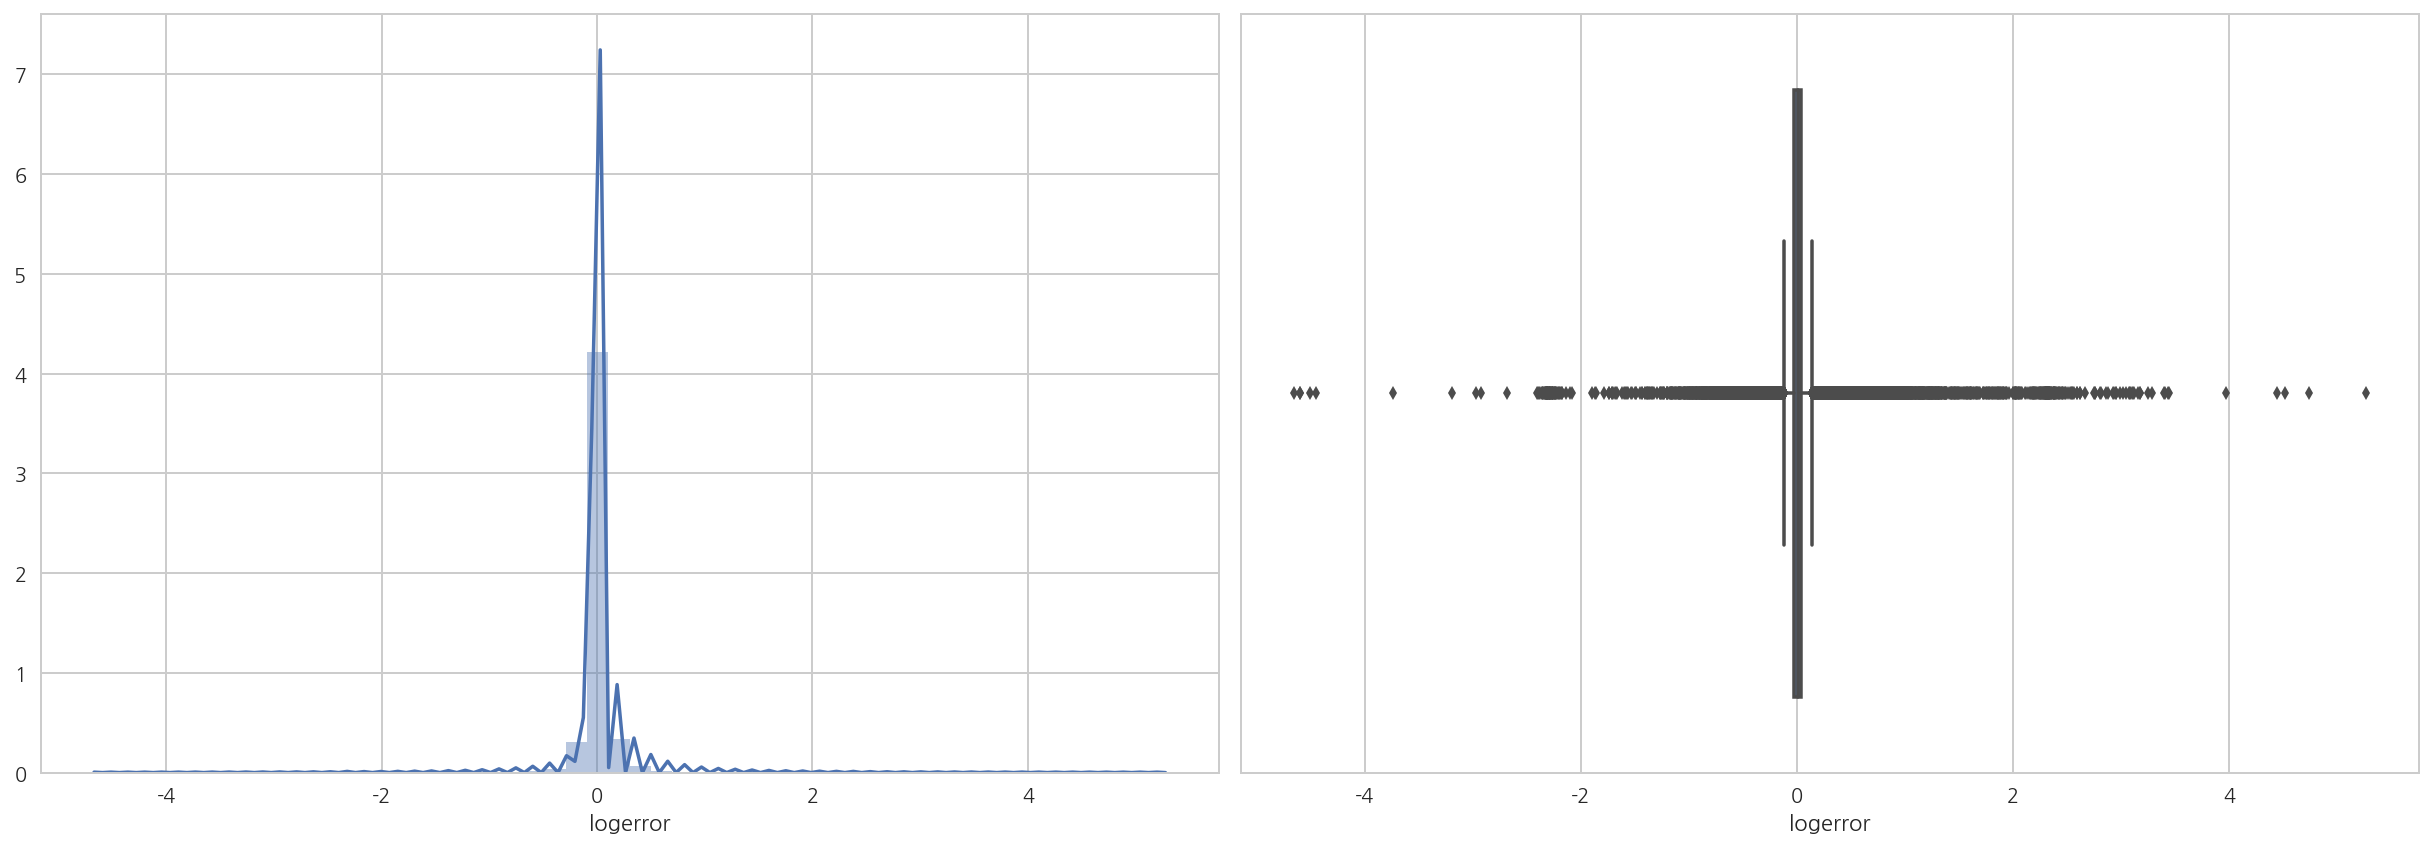

In [25]:
plt.figure(figsize=(17,6))

plt.subplot(121)
sns.distplot(merged["logerror"])

plt.subplot(122)
sns.boxplot(merged["logerror"])
plt.tight_layout()
plt.show()

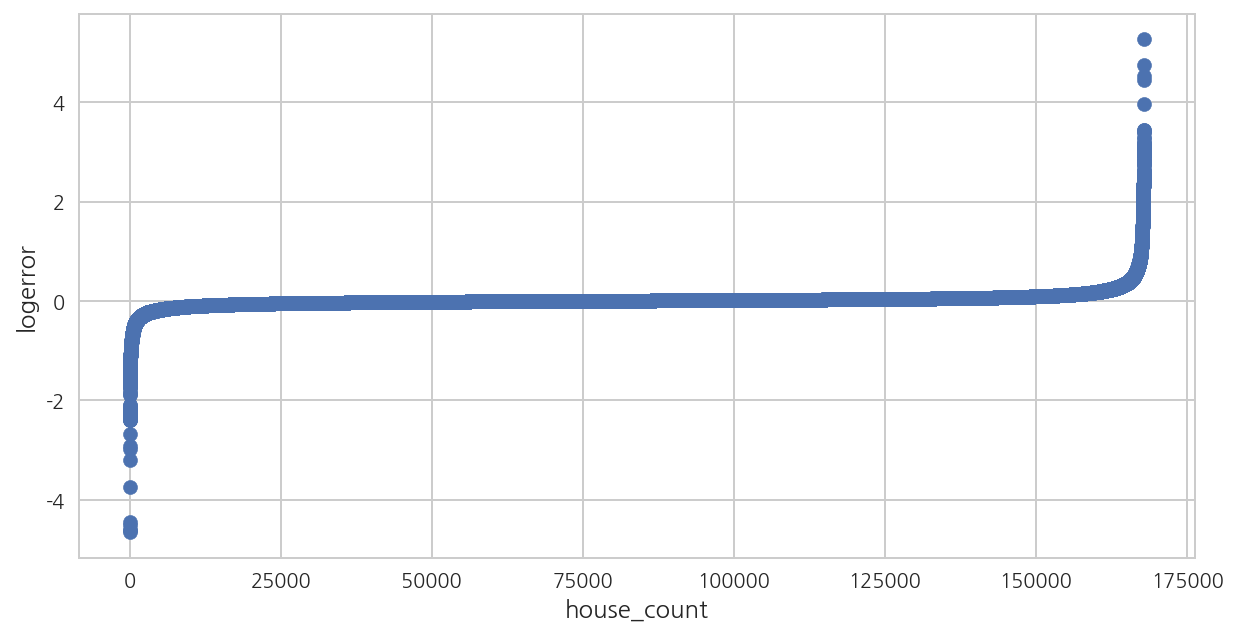

In [35]:
# logerror를 작은 값부터 정렬하여 분포를 살핌
plt.figure(figsize=(10,5))
plt.scatter(range(merged.shape[0]), np.sort(merged["logerror"]))
plt.xlabel('house_count', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

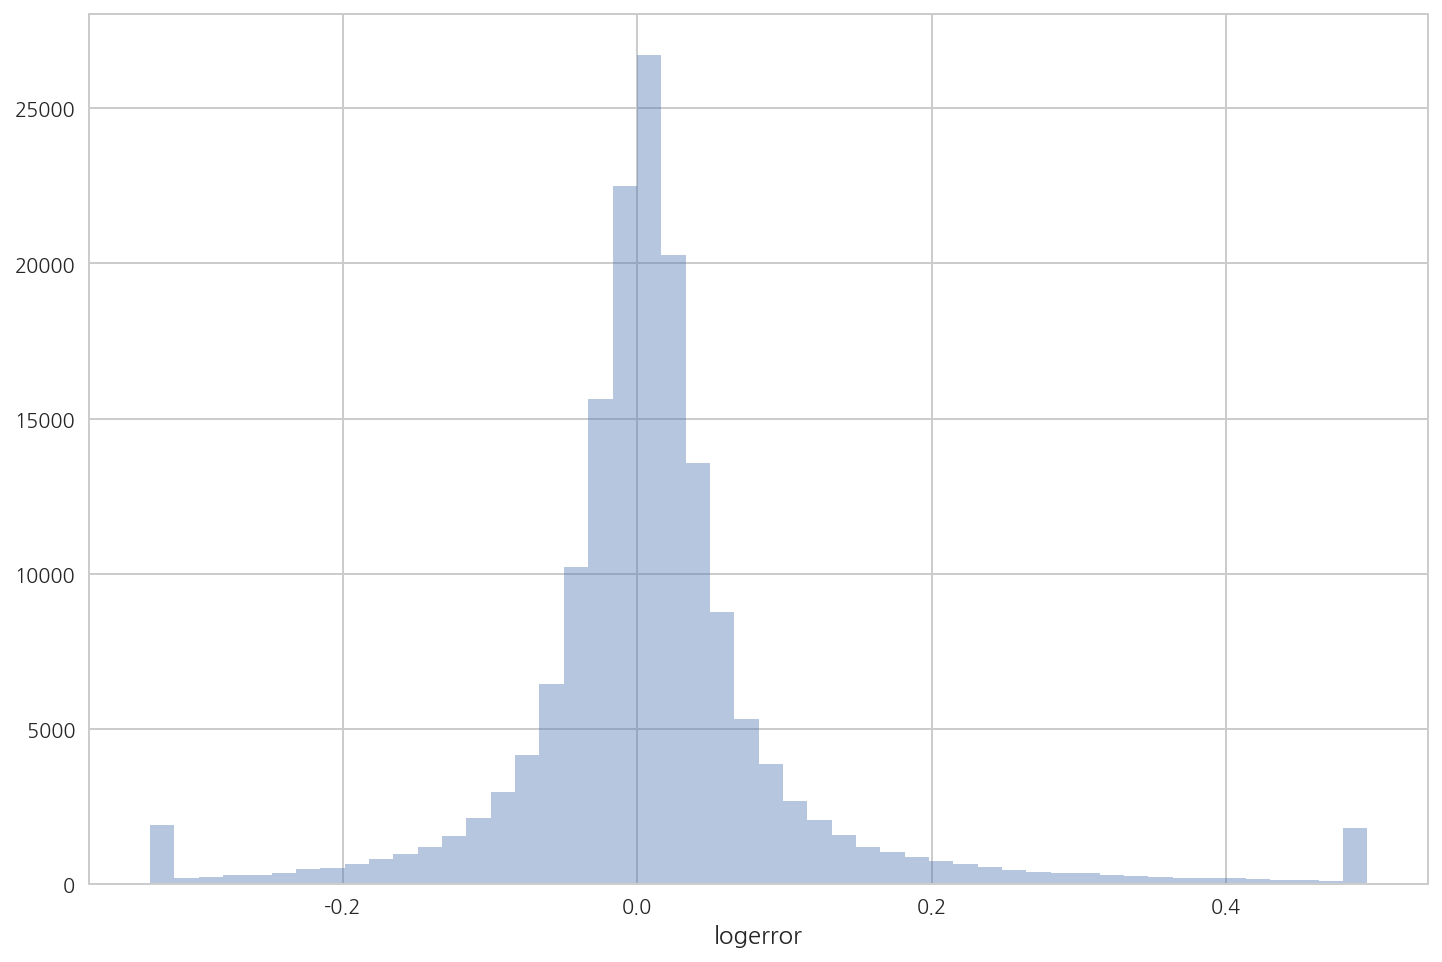

In [22]:
# 양 끝의 1%는 끝에 모아서 세워 그린 histogram
ulimit = np.percentile(merged.logerror.values, 99)
llimit = np.percentile(merged.logerror.values, 1)
merged['logerror'].loc[merged['logerror']>ulimit] = ulimit
merged['logerror'].loc[merged['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(merged["logerror"], bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

## 2.3 Exploring Feature Variables
- 독립변수를 주제별로 그룹지어 EDA
    - 변수의 의미, 분포를 파악
    - 적절한 missing value imputation 방안 
    - 추가적인 변수를 만들어낼 수 있는지 고민
- 주제별 분류
    1. 거래 날짜
    2. 집의 지리정보와 관련된 변수 (위도 경도 제외 카테고리 변수)
    3. 건물 특징, 타입 등에 대한 변수 (카테고리 변수)
    4. 집의 면적, 구조 등에 관련된 변수 (실수 변수 / 카테고리 변수)
    5. 세금과 관련된 변수 (실수 변수 / 카테고리 변수)    

### 1) 거래 관련 변수
- parcelid:
    - 대부분의 집들은 한번씩 거래됨 (거래횟수는 최대 3회까지 존재)
    - merged data의 167888개 row에서 unique한 parcelid의 개수는 165210개
- transactiondate

##### (1) parcelid: 집들은 몇번씩 거래되었나?

In [38]:
count = pd.DataFrame(columns=['count_all', 'count_2016', 'count_2017'])
count['count_all'] = (merged['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['count_2016'] = (train16['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['count_2017'] = (train17['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['index'] = ["1회", "2회", "3회"]
count.set_index("index")

count_all  count_2016  count_2017
index                                   
1회        162541       90026       77218
2회          2660         123         193
3회             9           1           3

In [39]:
len(list(merged["parcelid"].unique()))

165210

##### (2) transactiondate: 시점별 거래량과 logerror분포는 어떠한가?

##### 연도 및 월별 거래량

In [40]:
transaction_2016_month = merged["transaction_month"][merged['transaction_year'] == 2016].value_counts().reset_index()
transaction_2016_month = transaction_2016_month.rename(columns={'index':'month','transaction_month':'transaction_count'})
transaction_2016_month['year']=2016

In [41]:
transaction_2017_month = merged["transaction_month"][merged['transaction_year'] == 2017].value_counts().reset_index()
transaction_2017_month = transaction_2017_month.rename(columns={'index':'month','transaction_month':'transaction_count'})
transaction_2017_month['year']=2017

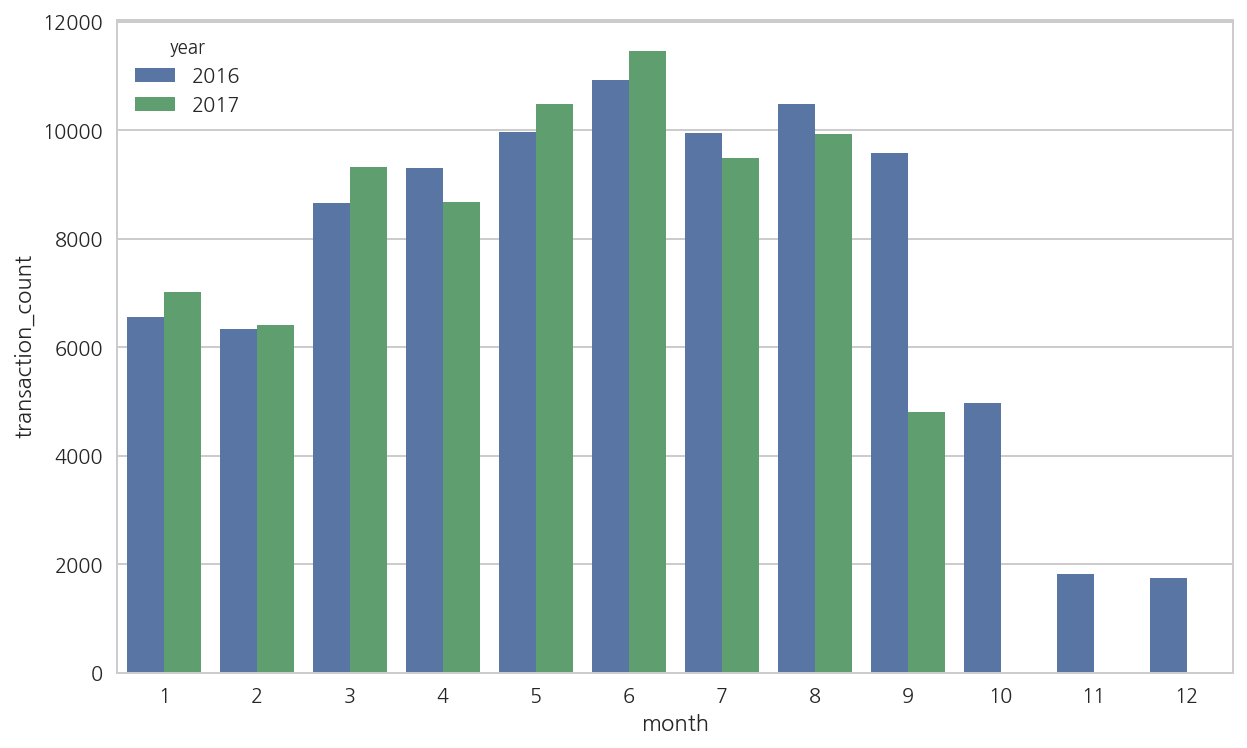

In [43]:
transaction_df = pd.concat([transaction_2016_month, transaction_2017_month]).reset_index(drop=True)
plt.figure(figsize=(10,6))
sns.barplot(data=transaction_df, x="month",y="transaction_count", hue="year")
plt.show()

##### 연도 및 월별 logerror

In [44]:
transaction_logerror_df = merged[['logerror','transaction_year','transaction_month']]
transaction_logerror_df.tail()

logerror  transaction_year  transaction_month
167883 -0.002245              2017                  9
167884  0.020615              2017                  9
167885  0.013209              2017                  9
167886  0.037129              2017                  9
167887  0.007204              2017                  9

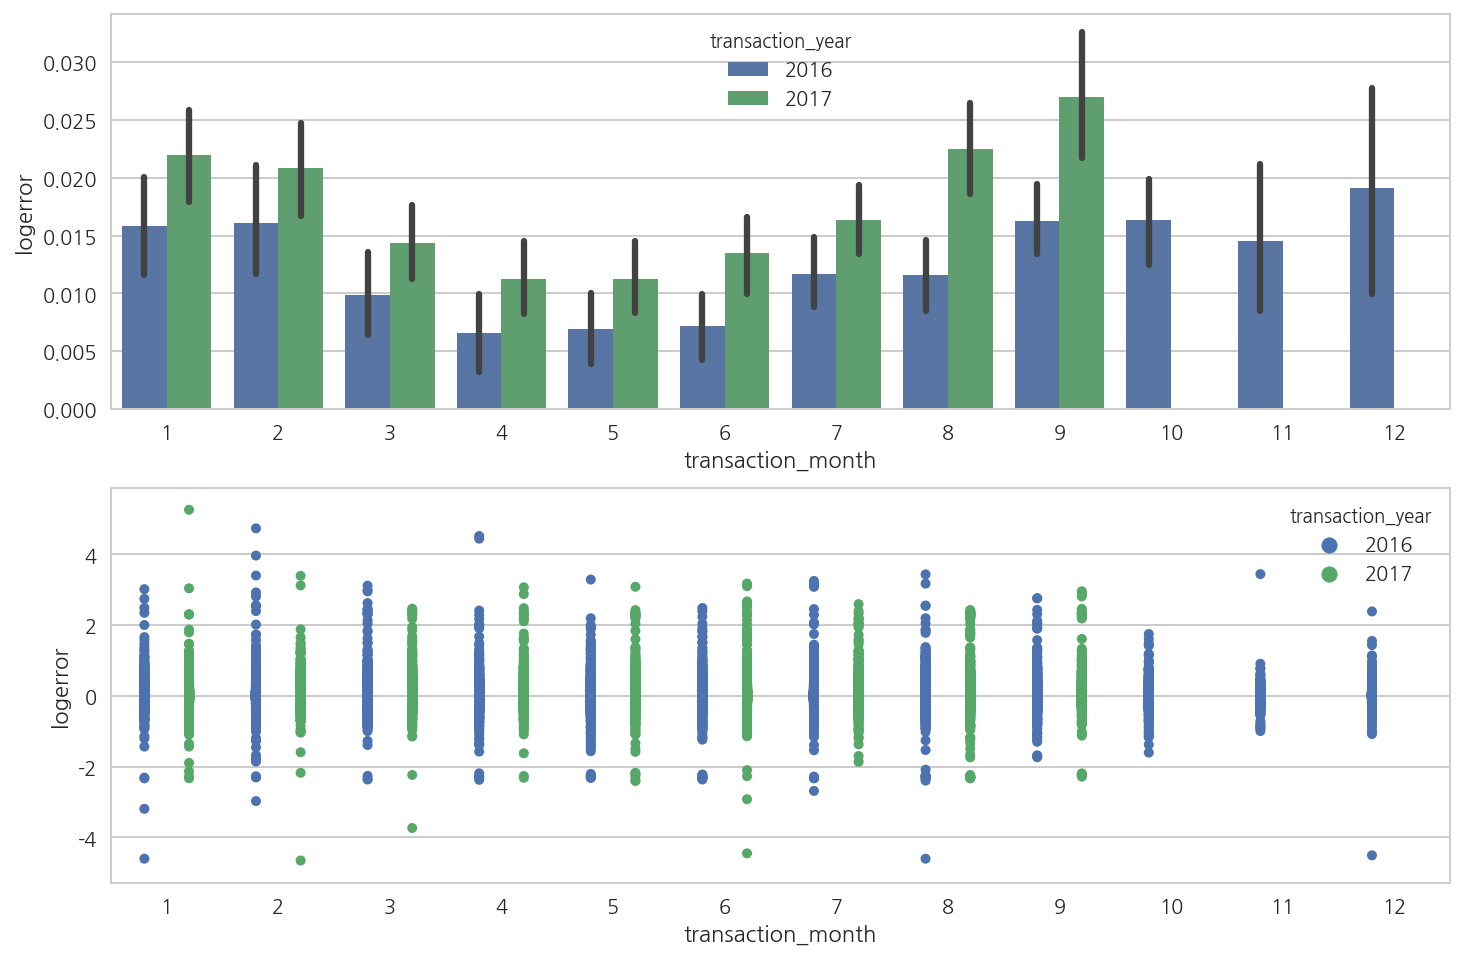

In [68]:
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(2, 1, 1)
sns.barplot(x = 'transaction_month', y = 'logerror', hue = "transaction_year", data = merged, ax = ax1)

ax2 = plt.subplot(2, 1, 2)
sns.stripplot(x = "transaction_month", y = "logerror", hue = "transaction_year",dodge=True, data = merged, ax = ax2)

plt.show()

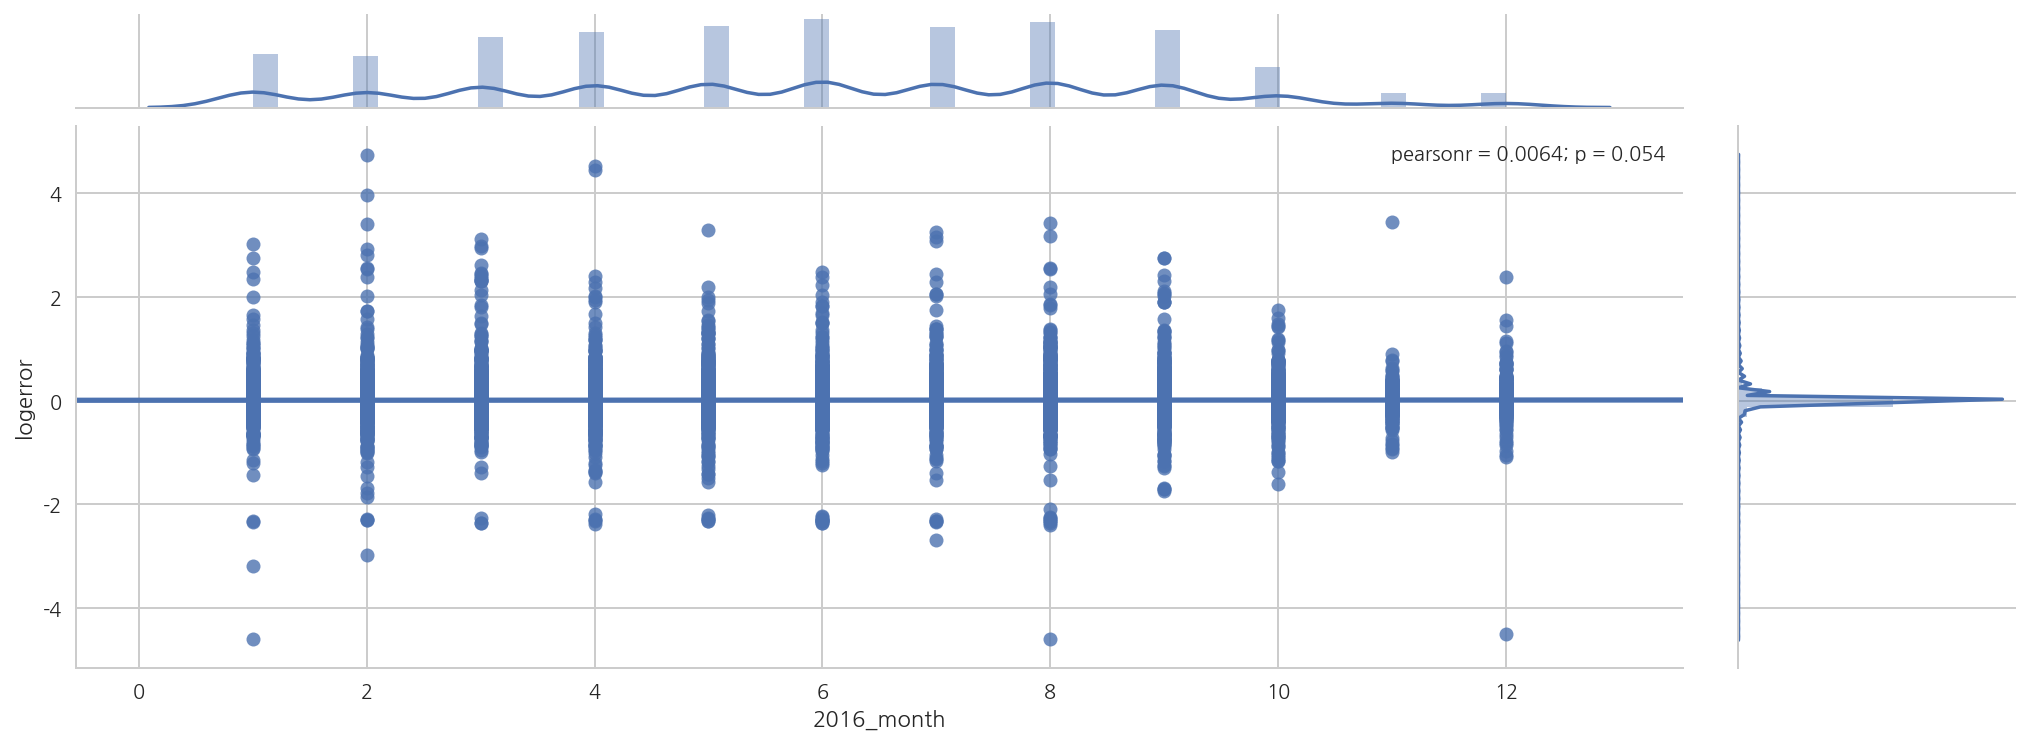

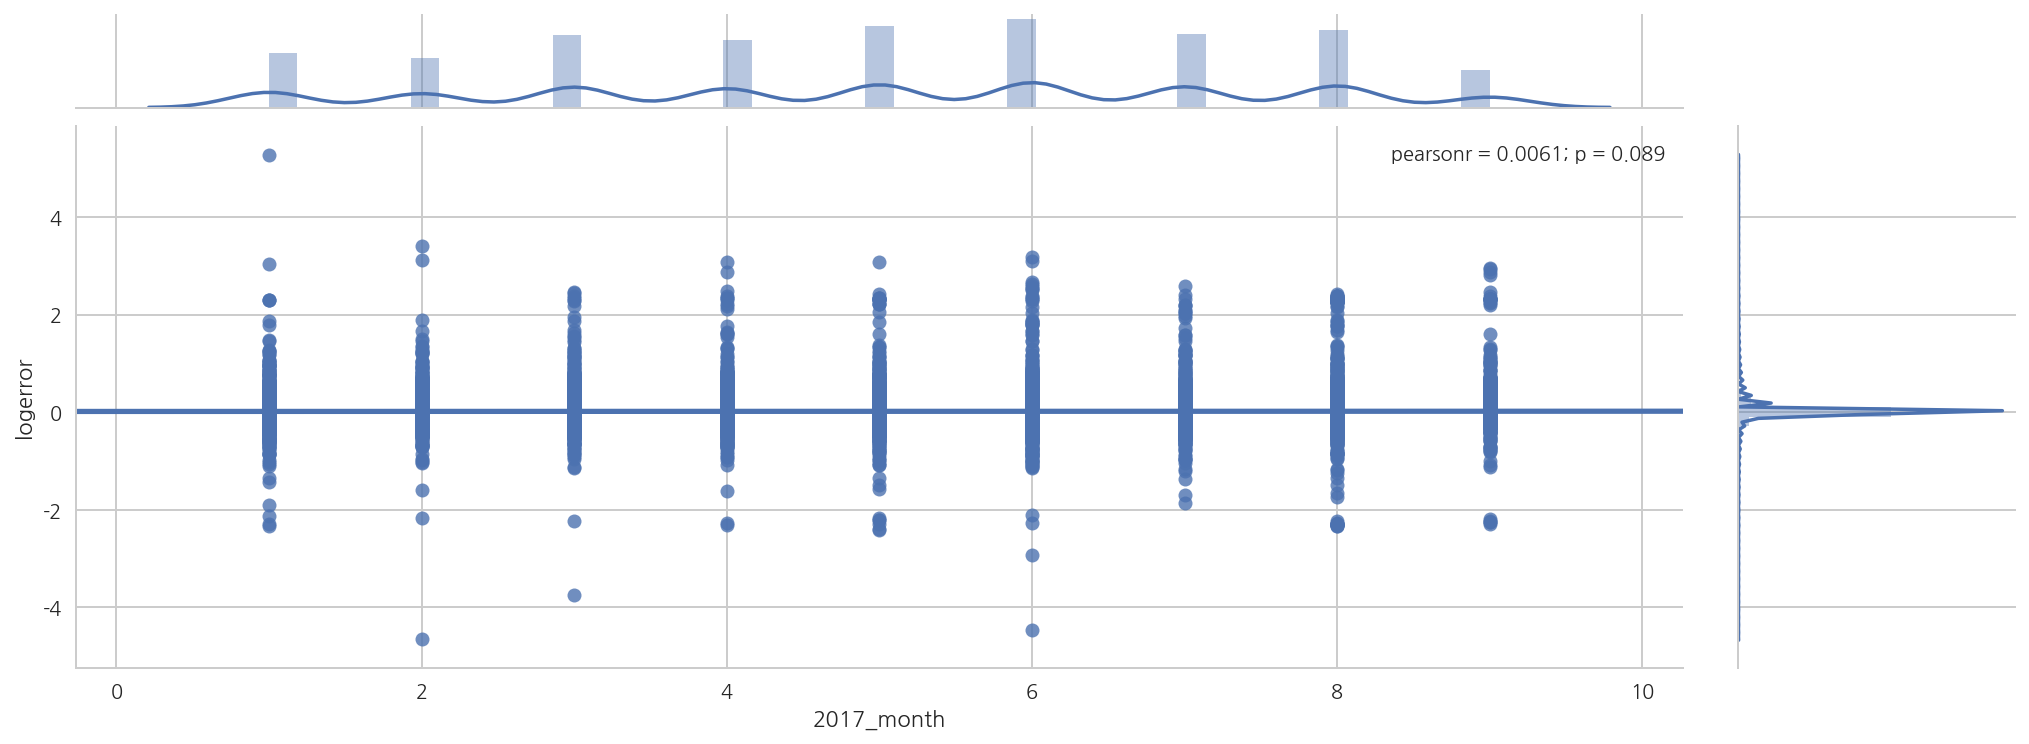

In [71]:
grid_1 = sns.jointplot(x = "transaction_month", y = "logerror", kind= "reg", size=8, data = merged[merged["transaction_year"]==2016])\
.set_axis_labels("2016_month", "logerror")
grid_1.fig.set_size_inches(15, 5)

grid_2 = sns.jointplot(x = "transaction_month", y = "logerror", kind= "reg", size=8, data = merged[merged["transaction_year"]==2017])\
.set_axis_labels("2017_month", "logerror")
grid_2.fig.set_size_inches(15, 5)

### 2) 집의 지리정보와 관련된 변수
- numerical variables: latitude, longitude
- categorical variables: fips, rawcensustractandblock, censustractandblock, regionidcounty, regionidcity, regionidzip, regionidneighborhood
    - county level 정보를 담고 있는 변수: fips, rawcensustractandblock와 censustractandblock의 앞 네 자리 코드
    - city level 이하의 정보를 담보 있는 변수: rawcensustractandblock와 censustractandblock의 5번째 자리 이후 코드, regionidcounty, regionidcity, regionidzip, regionidneighborhood

In [72]:
merged_des.loc[["fips","latitude", "longitude","rawcensustractandblock", "censustractandblock", "regionidcounty", "regionidcity",
                "regionidzip", "regionidneighborhood", "logerror"],["count", "mean", "min", "max", "dtype", "missing_ratio"]]

count       mean      min      max    dtype  \
fips                    167854        NaN      NaN      NaN   object   
latitude                167854    34.0068  33.3393  34.8188  float64   
longitude               167854   -118.201 -119.475 -117.555  float64   
rawcensustractandblock  167854        NaN      NaN      NaN   object   
censustractandblock     167002        NaN      NaN      NaN   object   
regionidcounty          167854        NaN      NaN      NaN   object   
regionidcity            164579        NaN      NaN      NaN   object   
regionidzip             167769    96586.4    95982   399675  float64   
regionidneighborhood     66986        NaN      NaN      NaN   object   
logerror                167888  0.0139063 -4.65542    5.263  float64   

                       missing_ratio  
fips                     0.000202516  
latitude                 0.000202516  
longitude                0.000202516  
rawcensustractandblock   0.000202516  
censustractandblock       0.00527733  
regionidcounty           0.000202516  
regionidcity               0.0197096  
regionidzip              0.000708806  
regionidneighborhood        0.601008  
logerror                           0

##### latitude & longitude

In [75]:
merged[["latitude","longitude"]].describe().transpose()

count        mean       std         min         25%         50%  \
latitude   167854.0   34.006778  0.265118   33.339295   33.812924   34.021700   
longitude  167854.0 -118.201117  0.360059 -119.475416 -118.413025 -118.176852   

                  75%         max  
latitude    34.173420   34.818767  
longitude -117.924692 -117.554636

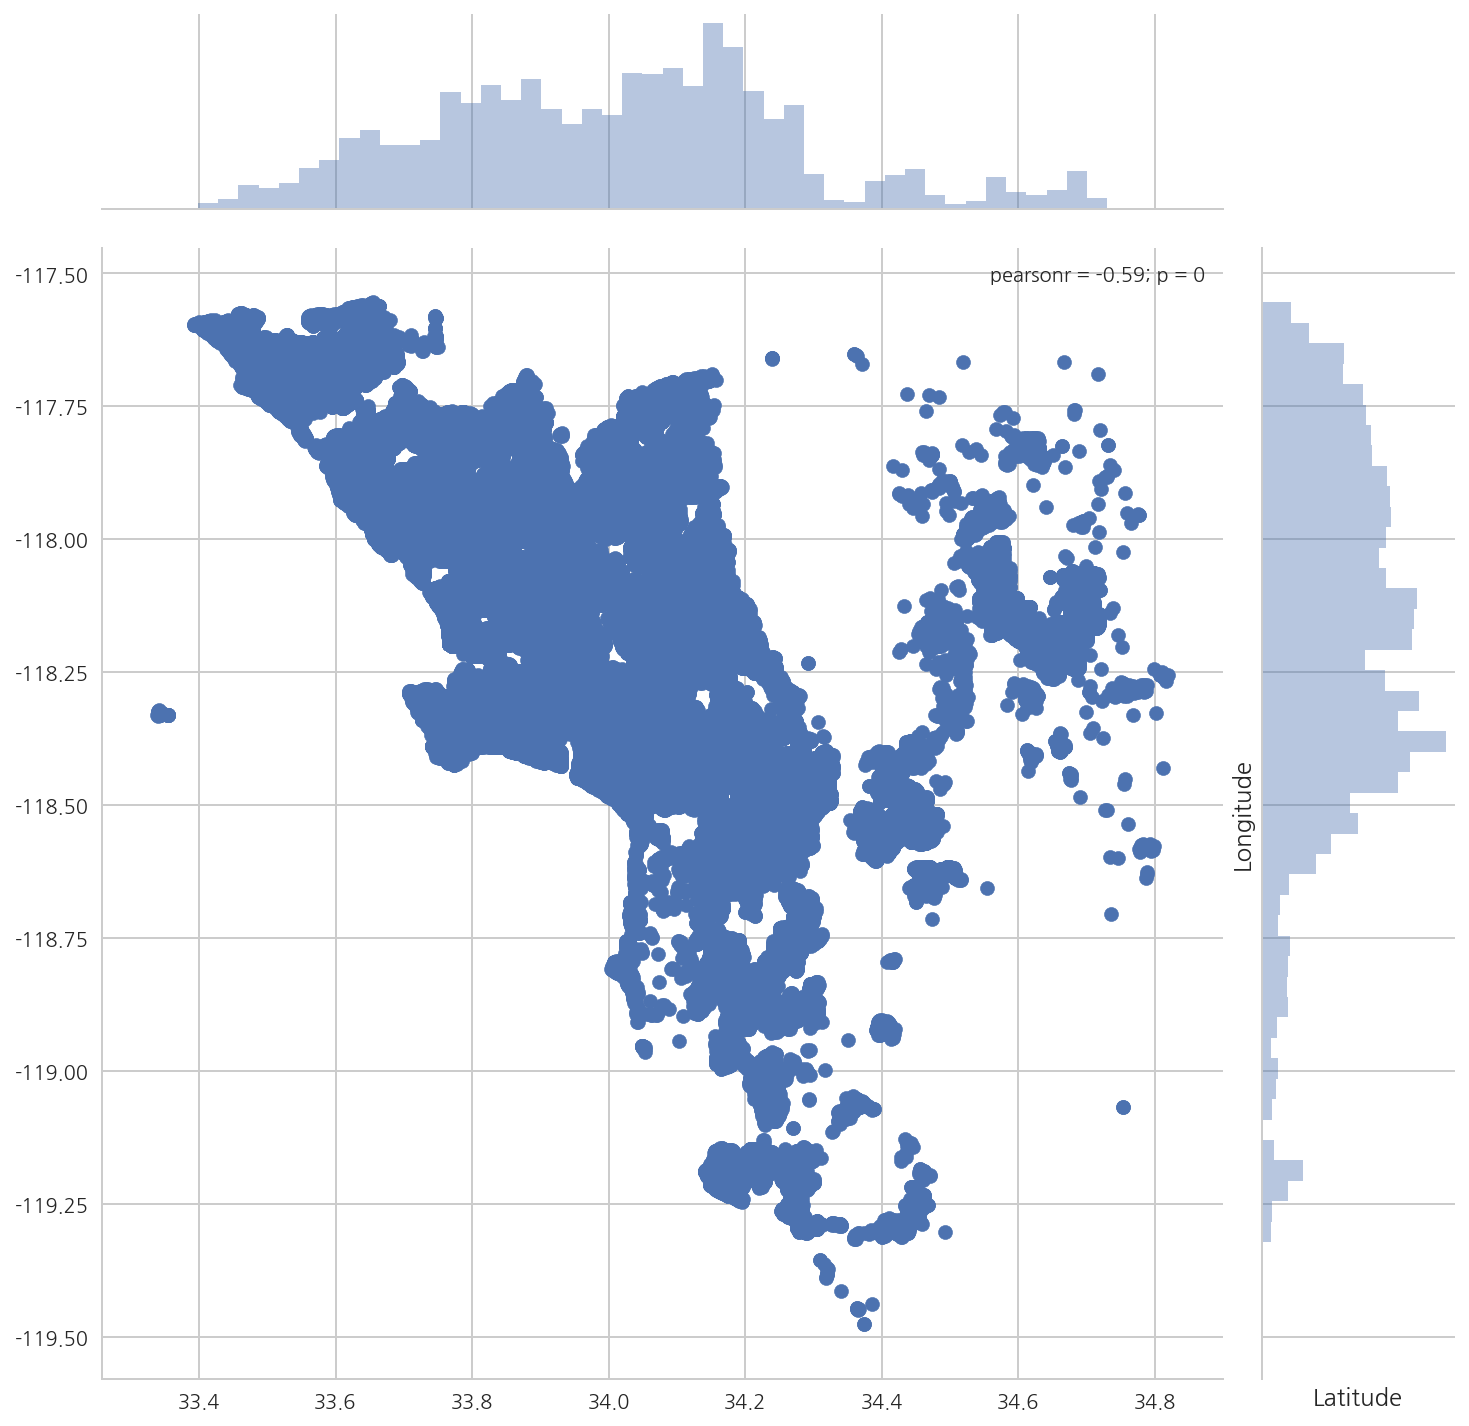

In [76]:
plt.figure(figsize=(8, 8))
sns.jointplot(x=merged.latitude.values, y=merged.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

##### **(1) county level의 정보를 나타내는 변수들**
- fips & regionidcounty: 완전히 동일한 정보를 가짐
    - fips: 6037=Los Angeles, 6059=Orange, 6111=Ventura County (6=CA)
    - regionidcounty: 3101=Los Angeles, 1286=Orange, 2061=Ventura County
- censustractandblock & rawcensustractandblock의 앞 네자리: fips 값을 담고 있음
- 집들은 LA(가장 많음), Orange, Ventura(가장 적음) 순으로 분포되어 있음
- 위 변수들은 사실상 거의 동일한 정보를 가지고 있음

In [26]:
# cencus와 rawcensus의 앞 네자리로 변수를 만들고 다른 변수들과 묶기
merged["census_1"] = merged["censustractandblock"].astype("str").apply(lambda x: x[:4])
merged["census_1"][merged["census_1"] == 'nan'] = np.nan
merged["raw_census_1"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[:4])
merged["raw_census_1"][merged["raw_census_1"] == 'nan'] = np.nan
county_df = merged[["fips", "regionidcounty", "census_1", "raw_census_1","logerror"]].tail()
county_df.tail()

fips regionidcounty census_1 raw_census_1  logerror
167883  6037.0         3101.0     6037         6037 -0.002245
167884  6037.0         3101.0     6037         6037  0.020615
167885  6111.0         2061.0     6111         6111  0.013209
167886  6037.0         3101.0     6037         6037  0.037129
167887  6037.0         3101.0     6037         6037  0.007204

In [27]:
# 변수별 분포
fips = merged["fips"].value_counts().reset_index().rename(columns={"index": "fips", "fips":"counts"})
regionidcounty = merged["regionidcounty"].value_counts().reset_index().rename(columns={"index": "regionidcounty", "regionidcounty":"counts"})
census_1 = merged["census_1"].value_counts().reset_index().rename(columns={"index": "census_1", "census_1":"counts"})
raw_census_1 = merged["raw_census_1"].value_counts().reset_index().rename(columns={"index": "raw_census_1", "raw_census_1":"counts"})
pd.concat([fips, regionidcounty, raw_census_1, census_1], axis=1)

fips    counts regionidcounty    counts raw_census_1    counts census_1  \
0  6037.0  109270.0         3101.0  109270.0         6037  109270.0     6037   
1  6059.0   45136.0         1286.0   45136.0         6059   45136.0     6059   
2  6111.0   13448.0         2061.0   13448.0         6111   13448.0     6111   
3     NaN       NaN            NaN       NaN          NaN       NaN     6071   
4     NaN       NaN            NaN       NaN          NaN       NaN     6065   
5     NaN       NaN            NaN       NaN          NaN       NaN     4830   

   counts  
0  108757  
1   44894  
2   13340  
3       8  
4       2  
5       1

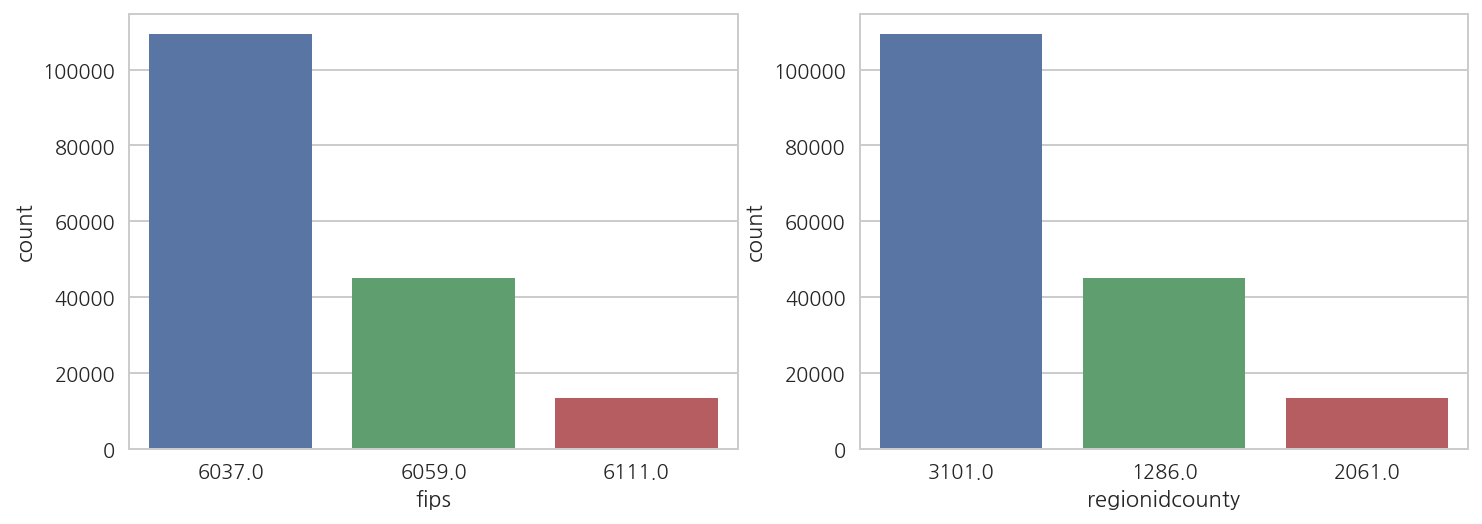

In [106]:
plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 2, 1)
sns.countplot(x = 'fips', data = merged, ax = ax1)

ax2 = plt.subplot(1, 2, 2)
sns.countplot(x = 'regionidcounty', data = merged, ax = ax2)

##### **(2) City level 이하의 정보를 나타내는 변수들**
- regionidcity: 179개 class
- census_2 & raw_census_2 (censustractandblock & rawcensustractandblock의 5-10의 여섯자리): census tract 값을 담고 있음 (유사한 인구적 특성을 가짐)
    - 각각 3017개, 3024개 class
- regionidzip: 391개 class
    - 입력오류로 보이는 3396765는 NaN값 처리
- regionidneighborhood: 506개 class 
    - missing value ratio가 60% 이상으로 꽤 높은데, imputation하기 어려울 것 같음

In [28]:
# censustractandblock & rawcensustractandblock의 5-10자리 부분: census tract → class가 3000개 이상이라 너무 많은 것으로 생각됨
merged["census_2"] = merged["censustractandblock"].astype("str").apply(lambda x: x[4:10])
merged["census_2"][merged["census_2"] == ""] = np.nan
census_2 = pd.DataFrame(merged["census_2"])
census_2 = census_2.groupby("census_2").size().reset_index(name='counts')

merged["raw_census_2"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[4:11])
merged["raw_census_2"][merged["raw_census_2"] == ""] = np.nan
raw_census_2 = pd.DataFrame(merged["raw_census_2"])
raw_census_2 = raw_census_2.groupby("raw_census_2").size().reset_index(name='counts')

In [29]:
# censustractandblock & rawcensustractandblock의 5-10자리 부분 중 첫째 자리로 카테고리화 (카테고리 수를 줄임)
merged["census_3"] = merged["censustractandblock"].astype("str").apply(lambda x: x[4:5])
merged["census_3"][merged["census_3"] == ''] = np.nan
census_3 = pd.DataFrame(merged["census_3"])
census_3 = census_3.groupby("census_3").size().reset_index(name='counts')

merged["raw_census_3"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[4:5])
merged["raw_census_3"][merged["raw_census_3"] == ''] = np.nan
raw_census_3 = pd.DataFrame(merged["raw_census_3"])
raw_census_3 = raw_census_3.groupby("raw_census_3").size().reset_index(name='counts')

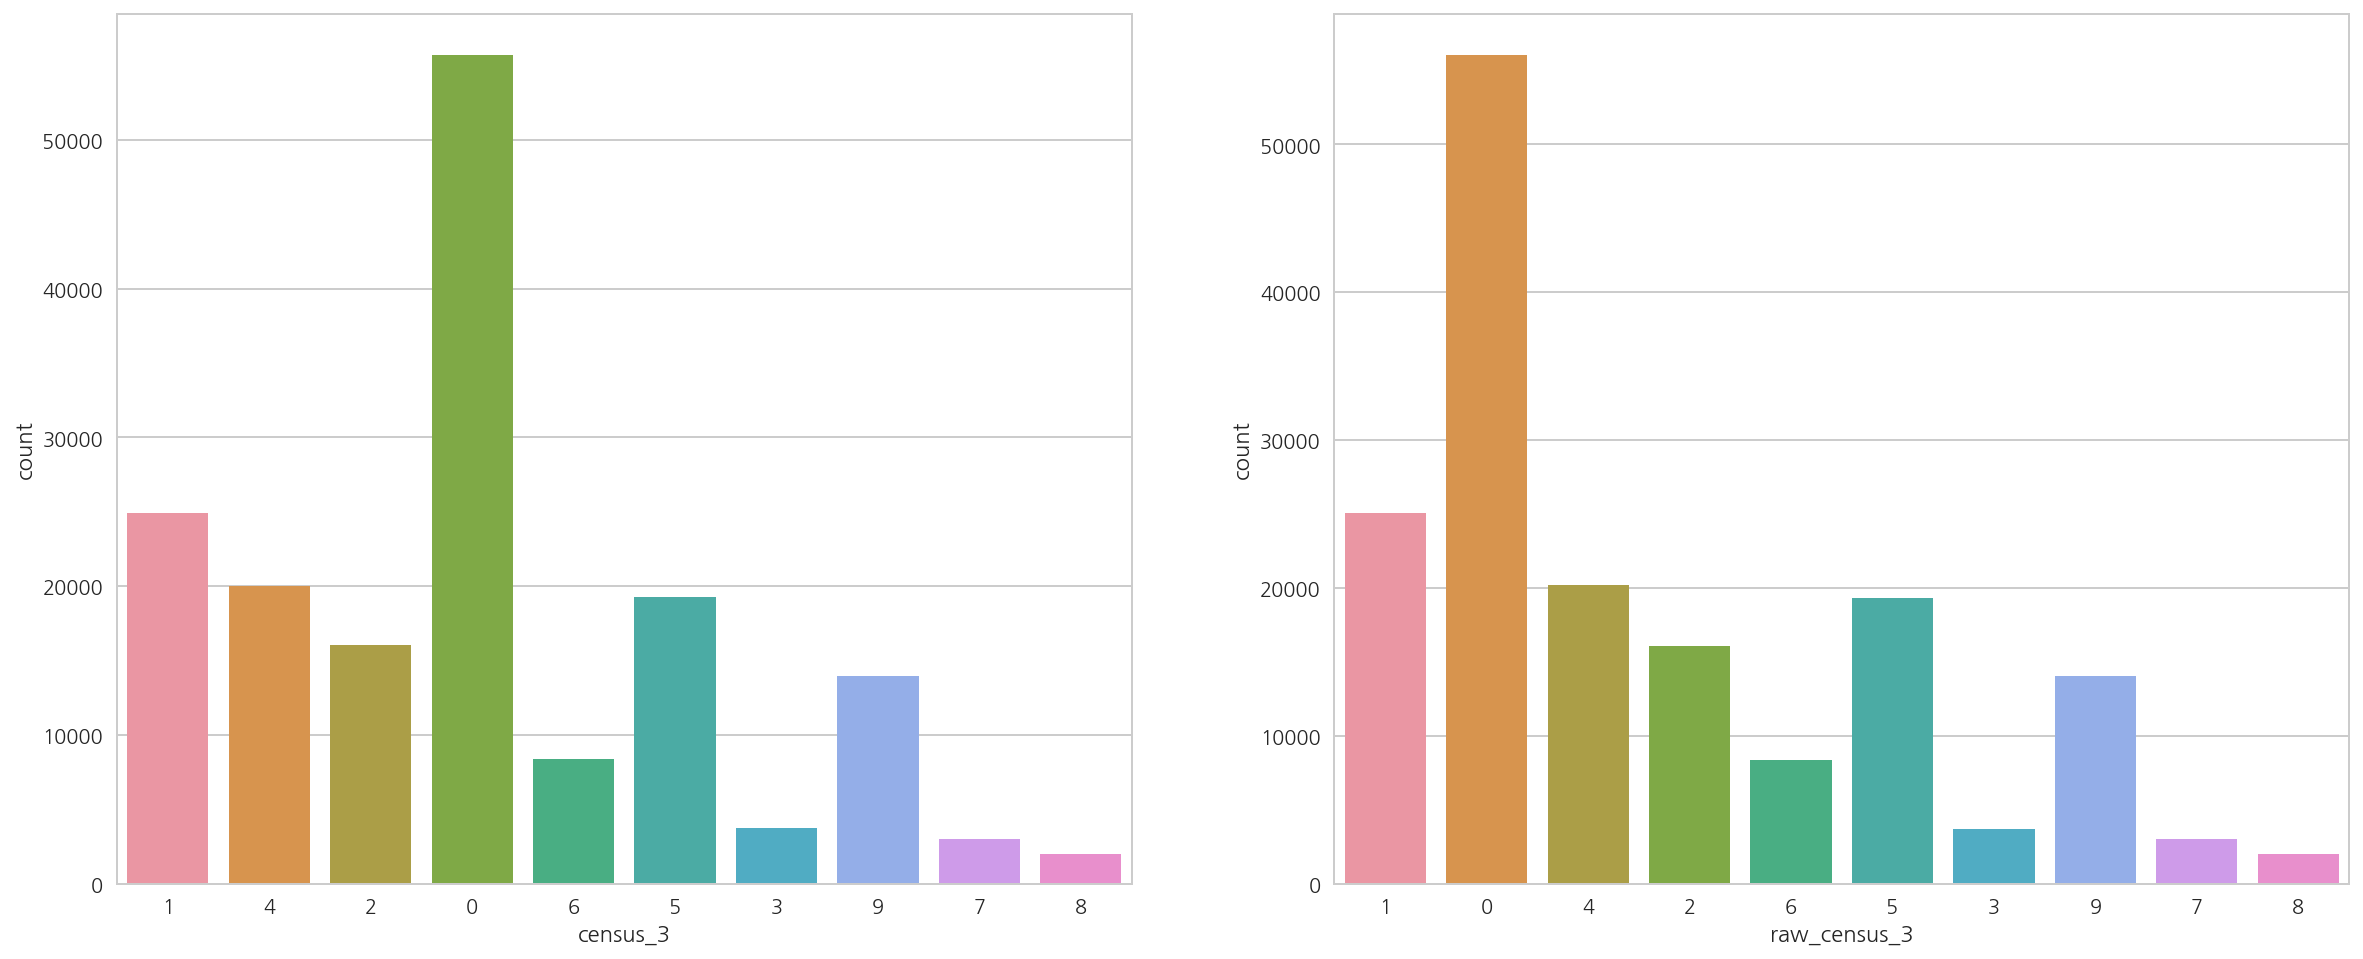

In [107]:
plt.figure(figsize=(20, 8))
ax1 = plt.subplot(1, 2, 1)
sns.countplot(x = 'census_3', data = merged, ax = ax1)

ax2 = plt.subplot(1, 2, 2)
sns.countplot(x = 'raw_census_3', data = merged, ax = ax2)
plt.show()

In [30]:
# censustractandblock & rawcensustractandblock의 1-5자리로 카테고리화
merged["census_4"] = merged["censustractandblock"].astype("str").apply(lambda x: x[:5])
merged["census_4"][merged["census_4"] == 'nan'] = np.nan
census_4 = pd.DataFrame(merged["census_4"])
census_4 = census_4.groupby("census_4").size().reset_index(name='counts')

merged["raw_census_4"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[:5])
merged["raw_census_4"][merged["raw_census_4"] == 'nan'] = np.nan
raw_census_4 = pd.DataFrame(merged["raw_census_4"])
raw_census_4 = raw_census_4.groupby("raw_census_4").size().reset_index(name='counts')

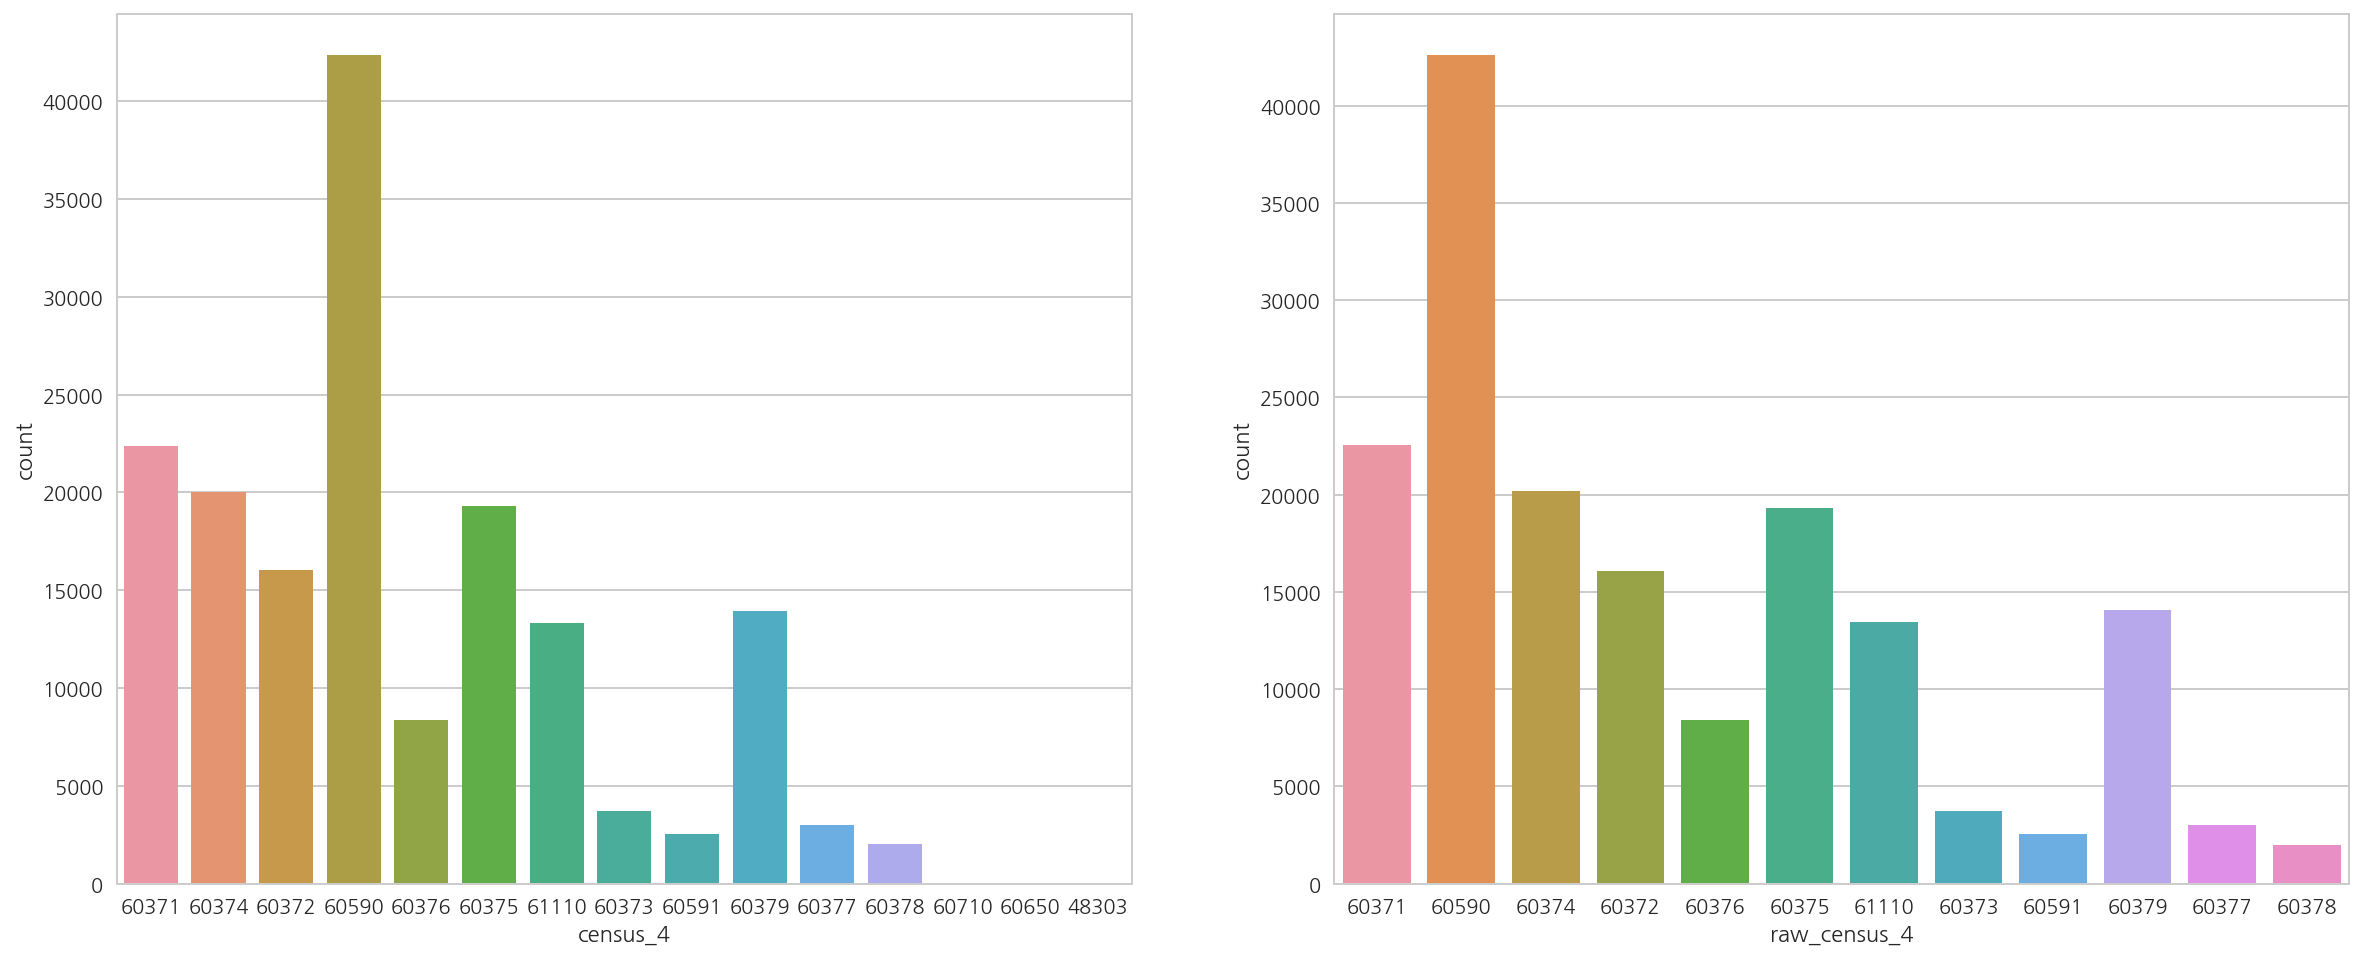

In [100]:
plt.figure(figsize=(20, 8))
ax1 = plt.subplot(1, 2, 1)
sns.countplot(x = 'census_4', data = merged, ax = ax1)

ax2 = plt.subplot(1, 2, 2)
sns.countplot(x = 'raw_census_4', data = merged, ax = ax2)
plt.show()

In [31]:
# what is 6-digit zip code??? (CA zipcode는 9로 시작하는 5자리수) (http://www.zipcodestogo.com/California/)
print("number of houses of wierd zipcode:", len(merged["regionidzip"][merged["regionidzip"] >= 100000]))
merged[merged["regionidzip"] >= 100000].tail()   # zipcode가 이상한 집들의 데이터 확인

number of houses of wierd zipcode: 25


parcelid  logerror transactiondate airconditioningtypeid  \
146359  12969394  0.000630      2017-07-11                   1.0   
153120  12969593  0.022602      2017-07-31                   NaN   
160027  12969702 -0.126013      2017-08-24                   1.0   
161938  12969611 -0.606399      2017-08-30                   1.0   
167393  12969775  0.035494      2017-09-15                   1.0   

       architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
146359                      NaN           NaN          5.0         5.0   
153120                      NaN           NaN          2.0         3.0   
160027                      NaN           NaN          3.0         4.0   
161938                      NaN           NaN          2.0         3.0   
167393                      NaN           NaN          3.0         5.0   

       buildingclasstypeid  buildingqualitytypeid     ...       \
146359                 NaN                    9.0     ...        
153120                 NaN                    7.0     ...        
160027                 NaN                    8.0     ...        
161938                 NaN                    8.0     ...        
167393                 NaN                    7.0     ...        

        transaction_year transaction_month  census_1  raw_census_1  census_2  \
146359              2017                 7      6037          6037    430200   
153120              2017                 7      6037          6037    430200   
160027              2017                 8      6037          6037    430200   
161938              2017                 8       NaN          6037       NaN   
167393              2017                 9      6037          6037    430200   

        raw_census_2  census_3  raw_census_3  census_4 raw_census_4  
146359       4302.00         4             4     60374        60374  
153120       4302.00         4             4     60374        60374  
160027       4302.00         4             4     60374        60374  
161938       4302.00       NaN             4       NaN        60374  
167393       4302.00         4             4     60374        60374  

[5 rows x 70 columns]

In [32]:
### 입력오류라고 보고 NaN값 처리
merged["regionidzip"][merged["regionidzip"]>=100000] = np.nan

In [33]:
### regionidneighborhood는 imputation이 어려울 것 같음 
regionidneighborhood = pd.DataFrame(merged["regionidneighborhood"])
regionidneighborhood = regionidneighborhood.groupby("regionidneighborhood").size().reset_index(name='counts')
regionidneighborhood.sort_values(by="counts", ascending = False).head(10)

regionidneighborhood  counts
121              27080.0    1476
345              48570.0    1461
29              118208.0    1447
267              37739.0    1400
343              48200.0    1178
106             268496.0    1163
347              51906.0    1160
348              54300.0    1062
0               113455.0     988
166             274049.0     946

In [35]:
# regionidcity: 179개 클래스를 가진 카테고리 변수
print("class number of regionidcity:", len(merged["regionidcity"].unique()))

# census_2, raw_census_2: tract
print("class number of cencus_2(tract):", len(merged["census_2"].unique()))
print("class number of raw_cencus_2(tract):", len(merged["raw_census_2"].unique()))

# census_3, raw_census_3: tract 첫 글자
print("class number of cencus_3(tract_1st):", len(merged["census_3"].unique()))
print("class number of raw_cencus_3(tract_1st):", len(merged["raw_census_3"].unique()))

# census_4, raw_census_4: county + tract 첫글자
print("class number of cencus_4(county+tract_1st):", len(merged["census_4"].unique()))
print("class number of raw_cencus_4(county+tract_1st):", len(merged["raw_census_4"].unique()))

# regionidzip: 클래스가 391개인 카테고리 변수
print("class number of regionzip:", len(merged["regionidzip"].unique()))

# regionidneighborhood: class 506개
print("class number of regionidneighborhood:", len(merged["regionidneighborhood"].unique()))

class number of regionidcity: 179
class number of cencus_2(tract): 3018
class number of raw_cencus_2(tract): 3025
class number of cencus_3(tract_1st): 11
class number of raw_cencus_3(tract_1st): 11
class number of cencus_4(county+tract_1st): 16
class number of raw_cencus_4(county+tract_1st): 13
class number of regionzip: 390
class number of regionidneighborhood: 506


##### 집의 지리정보와 관련된 변수 정리

In [36]:
merged.loc[:,["latitude", "longitude","fips", "regionidcounty", "raw_census_2", "census_2",
              "raw_census_3", "census_3",  "raw_census_4", "census_4", "regionidcity",
              "regionidzip", "regionidneighborhood"]].describe(include="all").transpose()

count unique      top    freq     mean       std  \
latitude              167854    NaN      NaN     NaN  34.0068  0.265118   
longitude             167854    NaN      NaN     NaN -118.201  0.360059   
fips                  167854      3   6037.0  109270      NaN       NaN   
regionidcounty        167854      3   3101.0  109270      NaN       NaN   
raw_census_2          167854   3024  0524.20     455      NaN       NaN   
census_2              167002   3017   052420     444      NaN       NaN   
raw_census_3          167854     10        0   56037      NaN       NaN   
census_3              167002     10        0   55699      NaN       NaN   
raw_census_4          167854     12    60590   42589      NaN       NaN   
census_4              167002     15    60590   42349      NaN       NaN   
regionidcity          164579    178  12447.0   38562      NaN       NaN   
regionidzip           167744    NaN      NaN     NaN  96541.2   412.111   
regionidneighborhood   66986    505  27080.0    1476      NaN       NaN   

                          min      25%      50%      75%      max  
latitude              33.3393  33.8129  34.0217  34.1734  34.8188  
longitude            -119.475 -118.413 -118.177 -117.925 -117.555  
fips                      NaN      NaN      NaN      NaN      NaN  
regionidcounty            NaN      NaN      NaN      NaN      NaN  
raw_census_2              NaN      NaN      NaN      NaN      NaN  
census_2                  NaN      NaN      NaN      NaN      NaN  
raw_census_3              NaN      NaN      NaN      NaN      NaN  
census_3                  NaN      NaN      NaN      NaN      NaN  
raw_census_4              NaN      NaN      NaN      NaN      NaN  
census_4                  NaN      NaN      NaN      NaN      NaN  
regionidcity              NaN      NaN      NaN      NaN      NaN  
regionidzip             95982    96193    96389    96987    97344  
regionidneighborhood      NaN      NaN      NaN      NaN      NaN

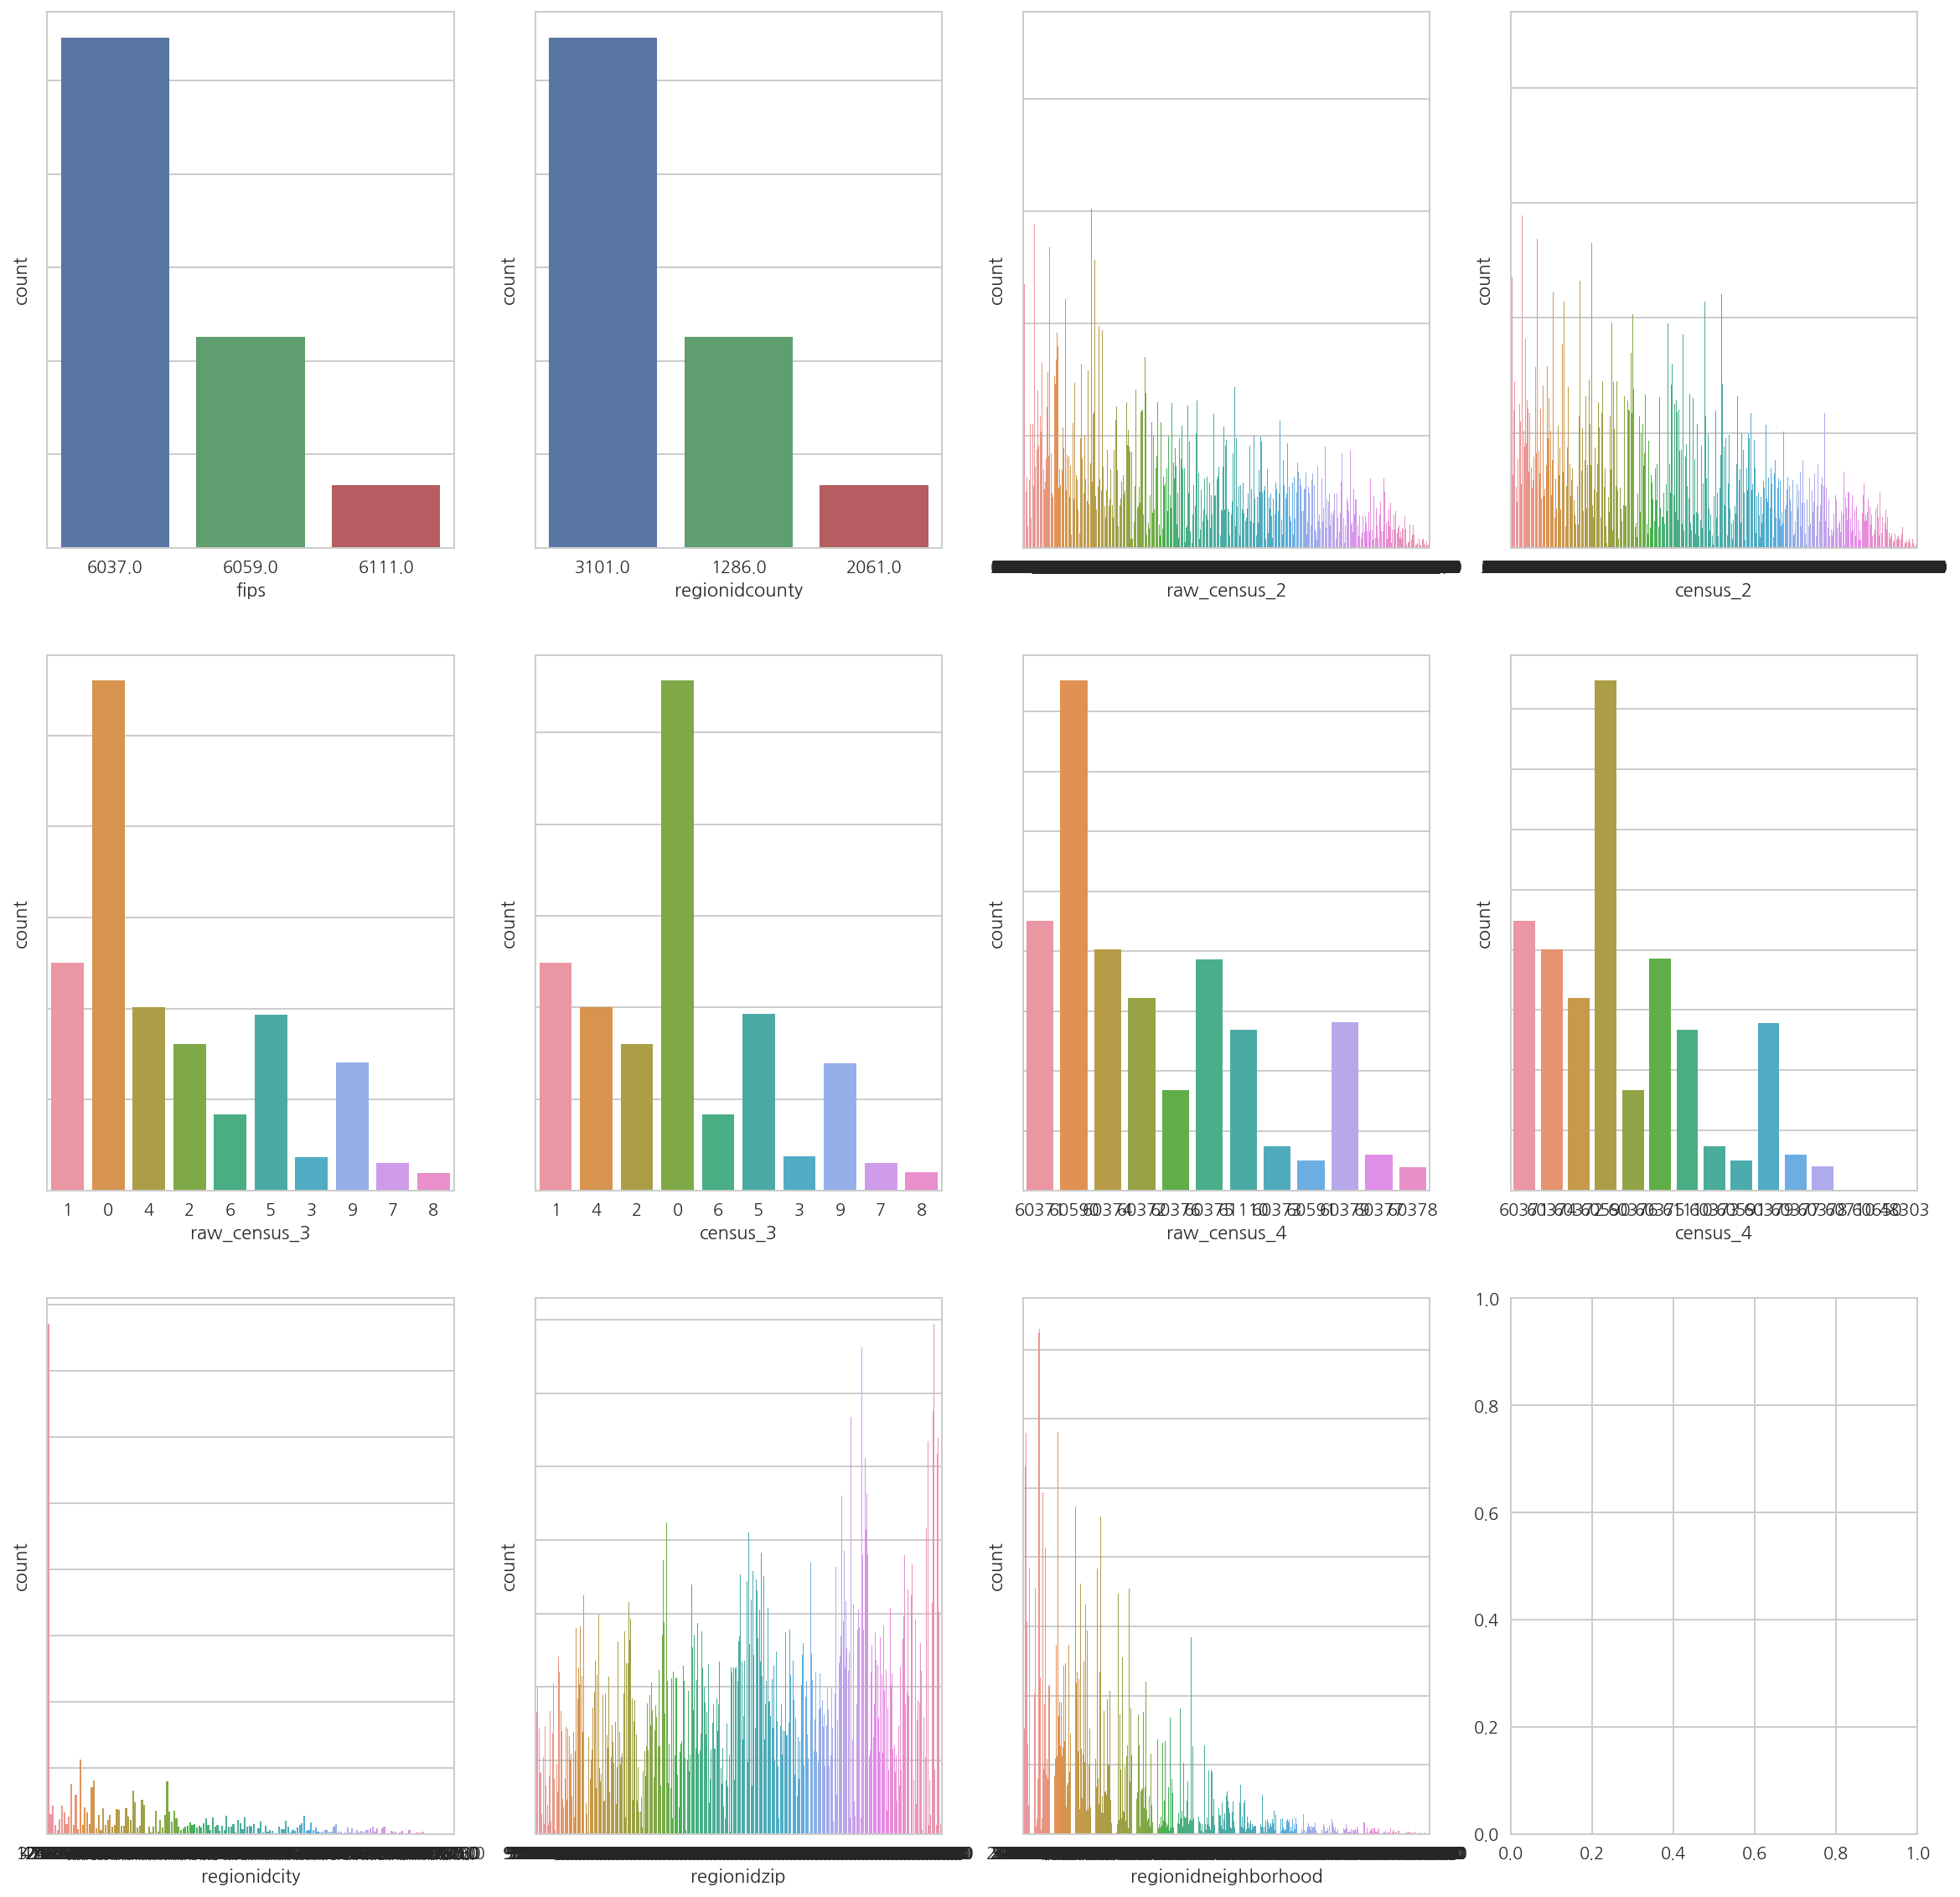

In [127]:
geo_cat = ["fips", "regionidcounty", "raw_census_2", "census_2",
           "raw_census_3", "census_3",  "raw_census_4", "census_4",
           "regionidcity", "regionidzip", "regionidneighborhood"]

fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(geo_cat):
    sns.countplot(x = n, data = merged, ax = ax[idx//4, idx % 4])
    ax[idx// 4, idx % 4].set(yticklabels=[])
    
    continue

### **3) 건물 특징, 타입 등에 대한 변수들**
- 건물의 특징 등에 대한 카테고리 변수들인데, missing value가 99% 이상인 값들이 많음
    - 최빈값으로 imputation 하고자 함
- numerical variable: buildingqualitytypeid (집에 대한 평가 점수 from 1 to 12)
- categorical variable: 
    - 건물 타입: architecturalstyletypeid, decktypeid, buildingclasstypeid, storytypeid, typeconstructiontypeid
    - 부지 용도 구분: propertycountylandusecode, propertylandusetypeid, propertyzoningdesc

In [128]:
merged_des.loc[["architecturalstyletypeid", "decktypeid", "buildingqualitytypeid", "buildingclasstypeid", "storytypeid",
              "typeconstructiontypeid", "propertycountylandusecode", "propertylandusetypeid", "propertyzoningdesc"],:]

count unique    top    freq first last     mean  \
architecturalstyletypeid      468      6    7.0     394   NaN  NaN      NaN   
decktypeid                   1272      1   66.0    1272   NaN  NaN      NaN   
buildingqualitytypeid      107173    NaN    NaN     NaN   NaN  NaN  6.01546   
buildingclasstypeid            31      2    4.0      30   NaN  NaN      NaN   
storytypeid                    93      1    7.0      93   NaN  NaN      NaN   
typeconstructiontypeid        522      4    6.0     516   NaN  NaN      NaN   
propertycountylandusecode  167853     90   0100   57628   NaN  NaN      NaN   
propertylandusetypeid      167854     14  261.0  113078   NaN  NaN      NaN   
propertyzoningdesc         108789   2346   LAR1   14444   NaN  NaN      NaN   

                              std  min  25%  50%  75%  max missing_ratio  \
architecturalstyletypeid      NaN  NaN  NaN  NaN  NaN  NaN      0.997212   
decktypeid                    NaN  NaN  NaN  NaN  NaN  NaN      0.992424   
buildingqualitytypeid      1.8828    1    4    7    7   12       0.36164   
buildingclasstypeid           NaN  NaN  NaN  NaN  NaN  NaN      0.999815   
storytypeid                   NaN  NaN  NaN  NaN  NaN  NaN      0.999446   
typeconstructiontypeid        NaN  NaN  NaN  NaN  NaN  NaN      0.996891   
propertycountylandusecode     NaN  NaN  NaN  NaN  NaN  NaN   0.000208472   
propertylandusetypeid         NaN  NaN  NaN  NaN  NaN  NaN   0.000202516   
propertyzoningdesc            NaN  NaN  NaN  NaN  NaN  NaN      0.352014   

                             dtype  
architecturalstyletypeid    object  
decktypeid                  object  
buildingqualitytypeid      float64  
buildingclasstypeid         object  
storytypeid                 object  
typeconstructiontypeid      object  
propertycountylandusecode   object  
propertylandusetypeid       object  
propertyzoningdesc          object

- **buildingqualitytypeid**
    - Overall assessment of condition of the building from best (lowest) to worst (highest)
    - missing value ratio: 0.36164
- **architecturalstyletypeid**
    - 집의 건축 스타일에 대한 1부터 27까지 categorical data
    - 27가지 class 중에 6가지 값이 나옴
- **decktypeid**
    - deck이 있는 경우 deck의 type, but data dict.에 type 분류 설명이 없어 값이 있는 '66'이 무슨 의미인지 알 수 없음
    - missing value ratio: 0.992424 → NaN은 deck이 없는 것이라고 보고 0으로 imputation(dummy 변수화)
- **buildingclasstypeid**
    - 건물이 fireproofed한 frame(non-combustible)를 갖고 있는지 분류 (0-5 cateogories, 5=non of above)
    - missing value ratio: 0.999815
- **storytypeid**
    - Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.)
    - missing value ratio: 0.999446
- **typeconstructiontypeid**
    - What type of construction material was used to construct the home
    - missing value ratio: 0.996891

- **propertycountylandusecode**
    - County land use code i.e. it's zoning at the county level
    - 숫자와 알파벳으로 이루어진 1~4자리 문자열
    - 90개 class

In [94]:
merged["propertycountylandusecode"].unique()

array(['0100', '1', '010C', '122', '1129', '34', '1128', '010E', '0104',
       '0101', '0200', '0700', '1111', '01DC', '010D', '1110', '0400',
       '012C', '010V', '1116', '01HC', '010G', '0300', '010F', '1117',
       '0103', '38', '1210', '0111', '010M', '96', '135', '0108', '1014',
       '1112', '0201', '0109', '1310', '010H', '1410', '1222', '1321',
       '1720', '1011', '1432', '0401', '0102', '012D', '73', '105',
       '0110', '100V', '0130', '8800', '0303', '0210', '1012', '1333',
       '0114', '01DD', '020G', '040A', '012E', '020M', '040V', '070D',
       '1200', '030G', '1722', '6050', '1421', '010', nan, '200', '0',
       '1420', '0131', '0301', '01HE', '0204', '0113', '0133', '040G',
       '1120', '0105', '0141', '0115', '010L', '040B', '0203', '020E'],
      dtype=object)

In [95]:
propertycountylandusecode = pd.DataFrame(merged["propertycountylandusecode"])
propertycountylandusecode_count = propertycountylandusecode.groupby("propertycountylandusecode").size().reset_index(name='counts')

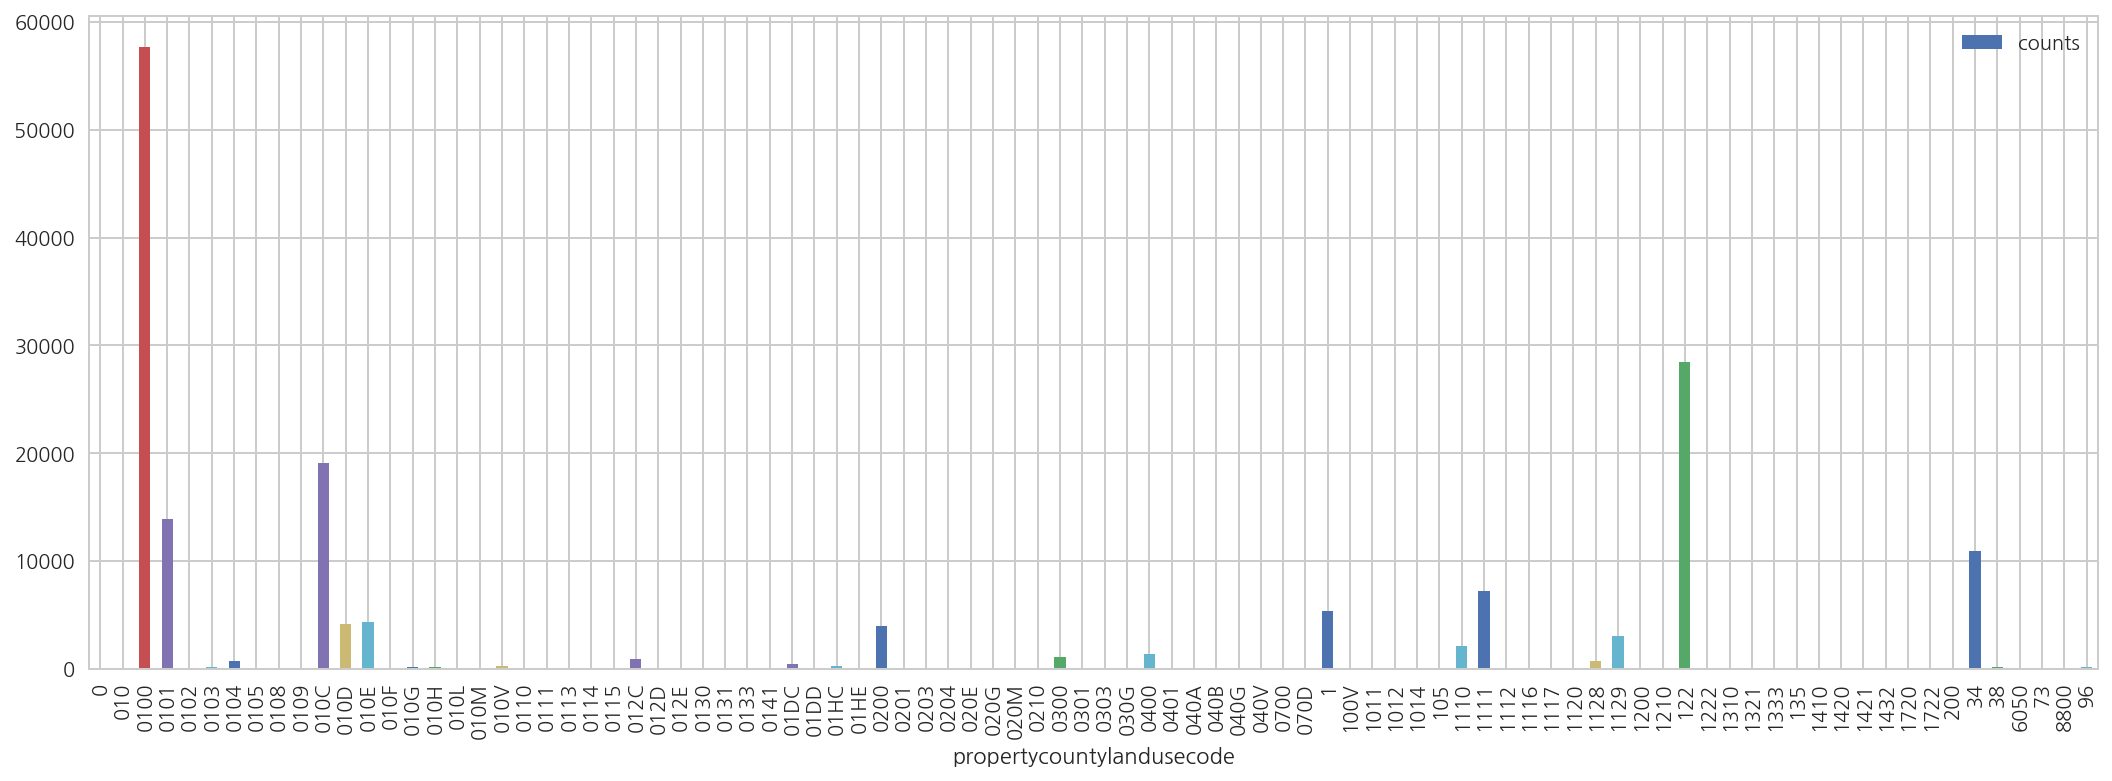

In [96]:
propertycountylandusecode_count.plot(x = 'propertycountylandusecode', y = 'counts', kind = 'bar', figsize=(18, 6))

- **propertylandusetypeid**
    - Type of land use the property is zoned for
    - 261 Single Family Residential과 266 Condominium이 데이터의 대부분을 차지함

- **propertyzoningdesc**
    - Description of the allowed land uses (zoning) for that property (Zoning affects what you can and cannot do with a property)
    - 알파벳과 숫자로 이루어진 문자열, 2347개 unique값, missing value ratio 35.2%
    - 주마다 zoning 규칙이 있지만 대체로 R이 residential, c는 commercial, I/M은 industrial 등으로 구분되어 있음
        - LA: https://library.municode.com/ca/los_angeles_county/codes/code_of_ordinances?nodeId=TIT22PLZO_DIV1PLZO_CH22.12ZODI_22.12.010ZODEURTAAU
        - Orange: https://library.municode.com/ca/orange/codes/code_of_ordinances?nodeId=TIT17ZO_CH17.06ZODIMA
        - Ventura: https://docs.vcrma.org/images/pdf/planning/ordinances/VCNCZO_Current.pdf
    - 코드를 살펴보면 앞의 두자리는 지역을 나타내는 것으로 추측
    - 첫번째 글자로 묶거나, 세번째자리 글자로 묶어 새로운 변수 두 가지를 만들어 봄    

In [100]:
pd.DataFrame(merged["propertyzoningdesc"].unique()).tail()

0
2342     GARR-MD
2343  DUR120000*
2344  LCRA 7500*
2345  LCRA7000-R
2346   BFA15000*

In [45]:
propertyzoningdesc = merged["propertyzoningdesc"].value_counts().reset_index().rename(columns={"index": "propertyzoningdesc", "propertyzoningdesc":"counts"})
propertyzoningdesc.head()

propertyzoningdesc  counts
0               LAR1   14444
1               LAR3    5251
2               LARS    2897
3              LBR1N    2684
4            LARD1.5    2437

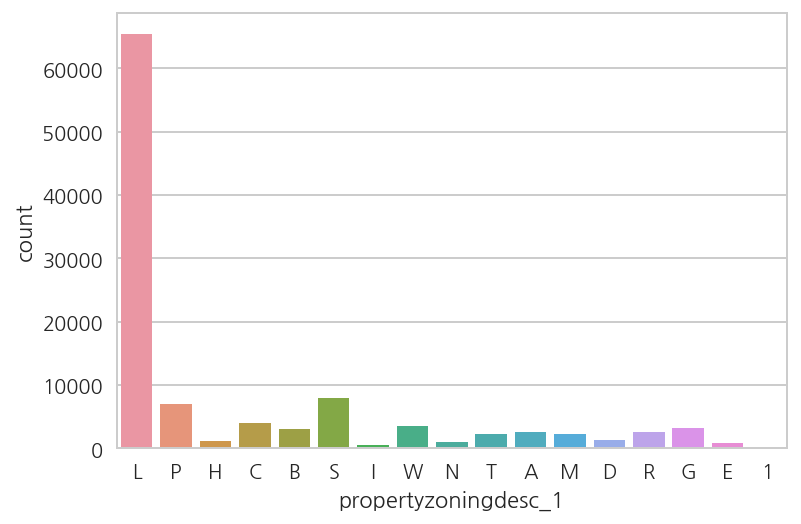

In [37]:
# 첫글자로 새로운 변수 만들기 (첫 글자로 카테고리화)
merged["propertyzoningdesc_1"] = merged["propertyzoningdesc"].astype("str").apply(lambda x: x[:1])
merged["propertyzoningdesc_1"][merged["propertyzoningdesc_1"] == "n"] = np.nan
sns.countplot(x = 'propertyzoningdesc_1', data=merged)
plt.show()

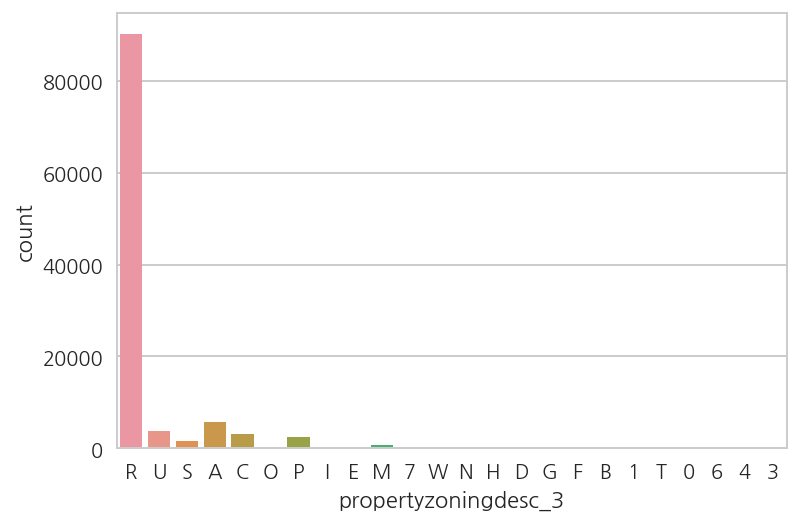

In [38]:
# 세번째 글자로 새로운 변수 만들기
merged["propertyzoningdesc_3"] = merged["propertyzoningdesc"].astype("str").apply(
    lambda x: x.replace("&", "").replace("-", "").replace(" ", ""))
merged["propertyzoningdesc_3"] = merged["propertyzoningdesc_3"].apply(lambda x: x[2:3])
merged["propertyzoningdesc_3"][merged["propertyzoningdesc_3"] == "n"] = np.nan
merged["propertyzoningdesc_3"][merged["propertyzoningdesc_3"] == ""] = np.nan
sns.countplot(x = 'propertyzoningdesc_3', data=merged)
plt.show()

##### 건물 특징, 타입 등에 대한 변수 정리

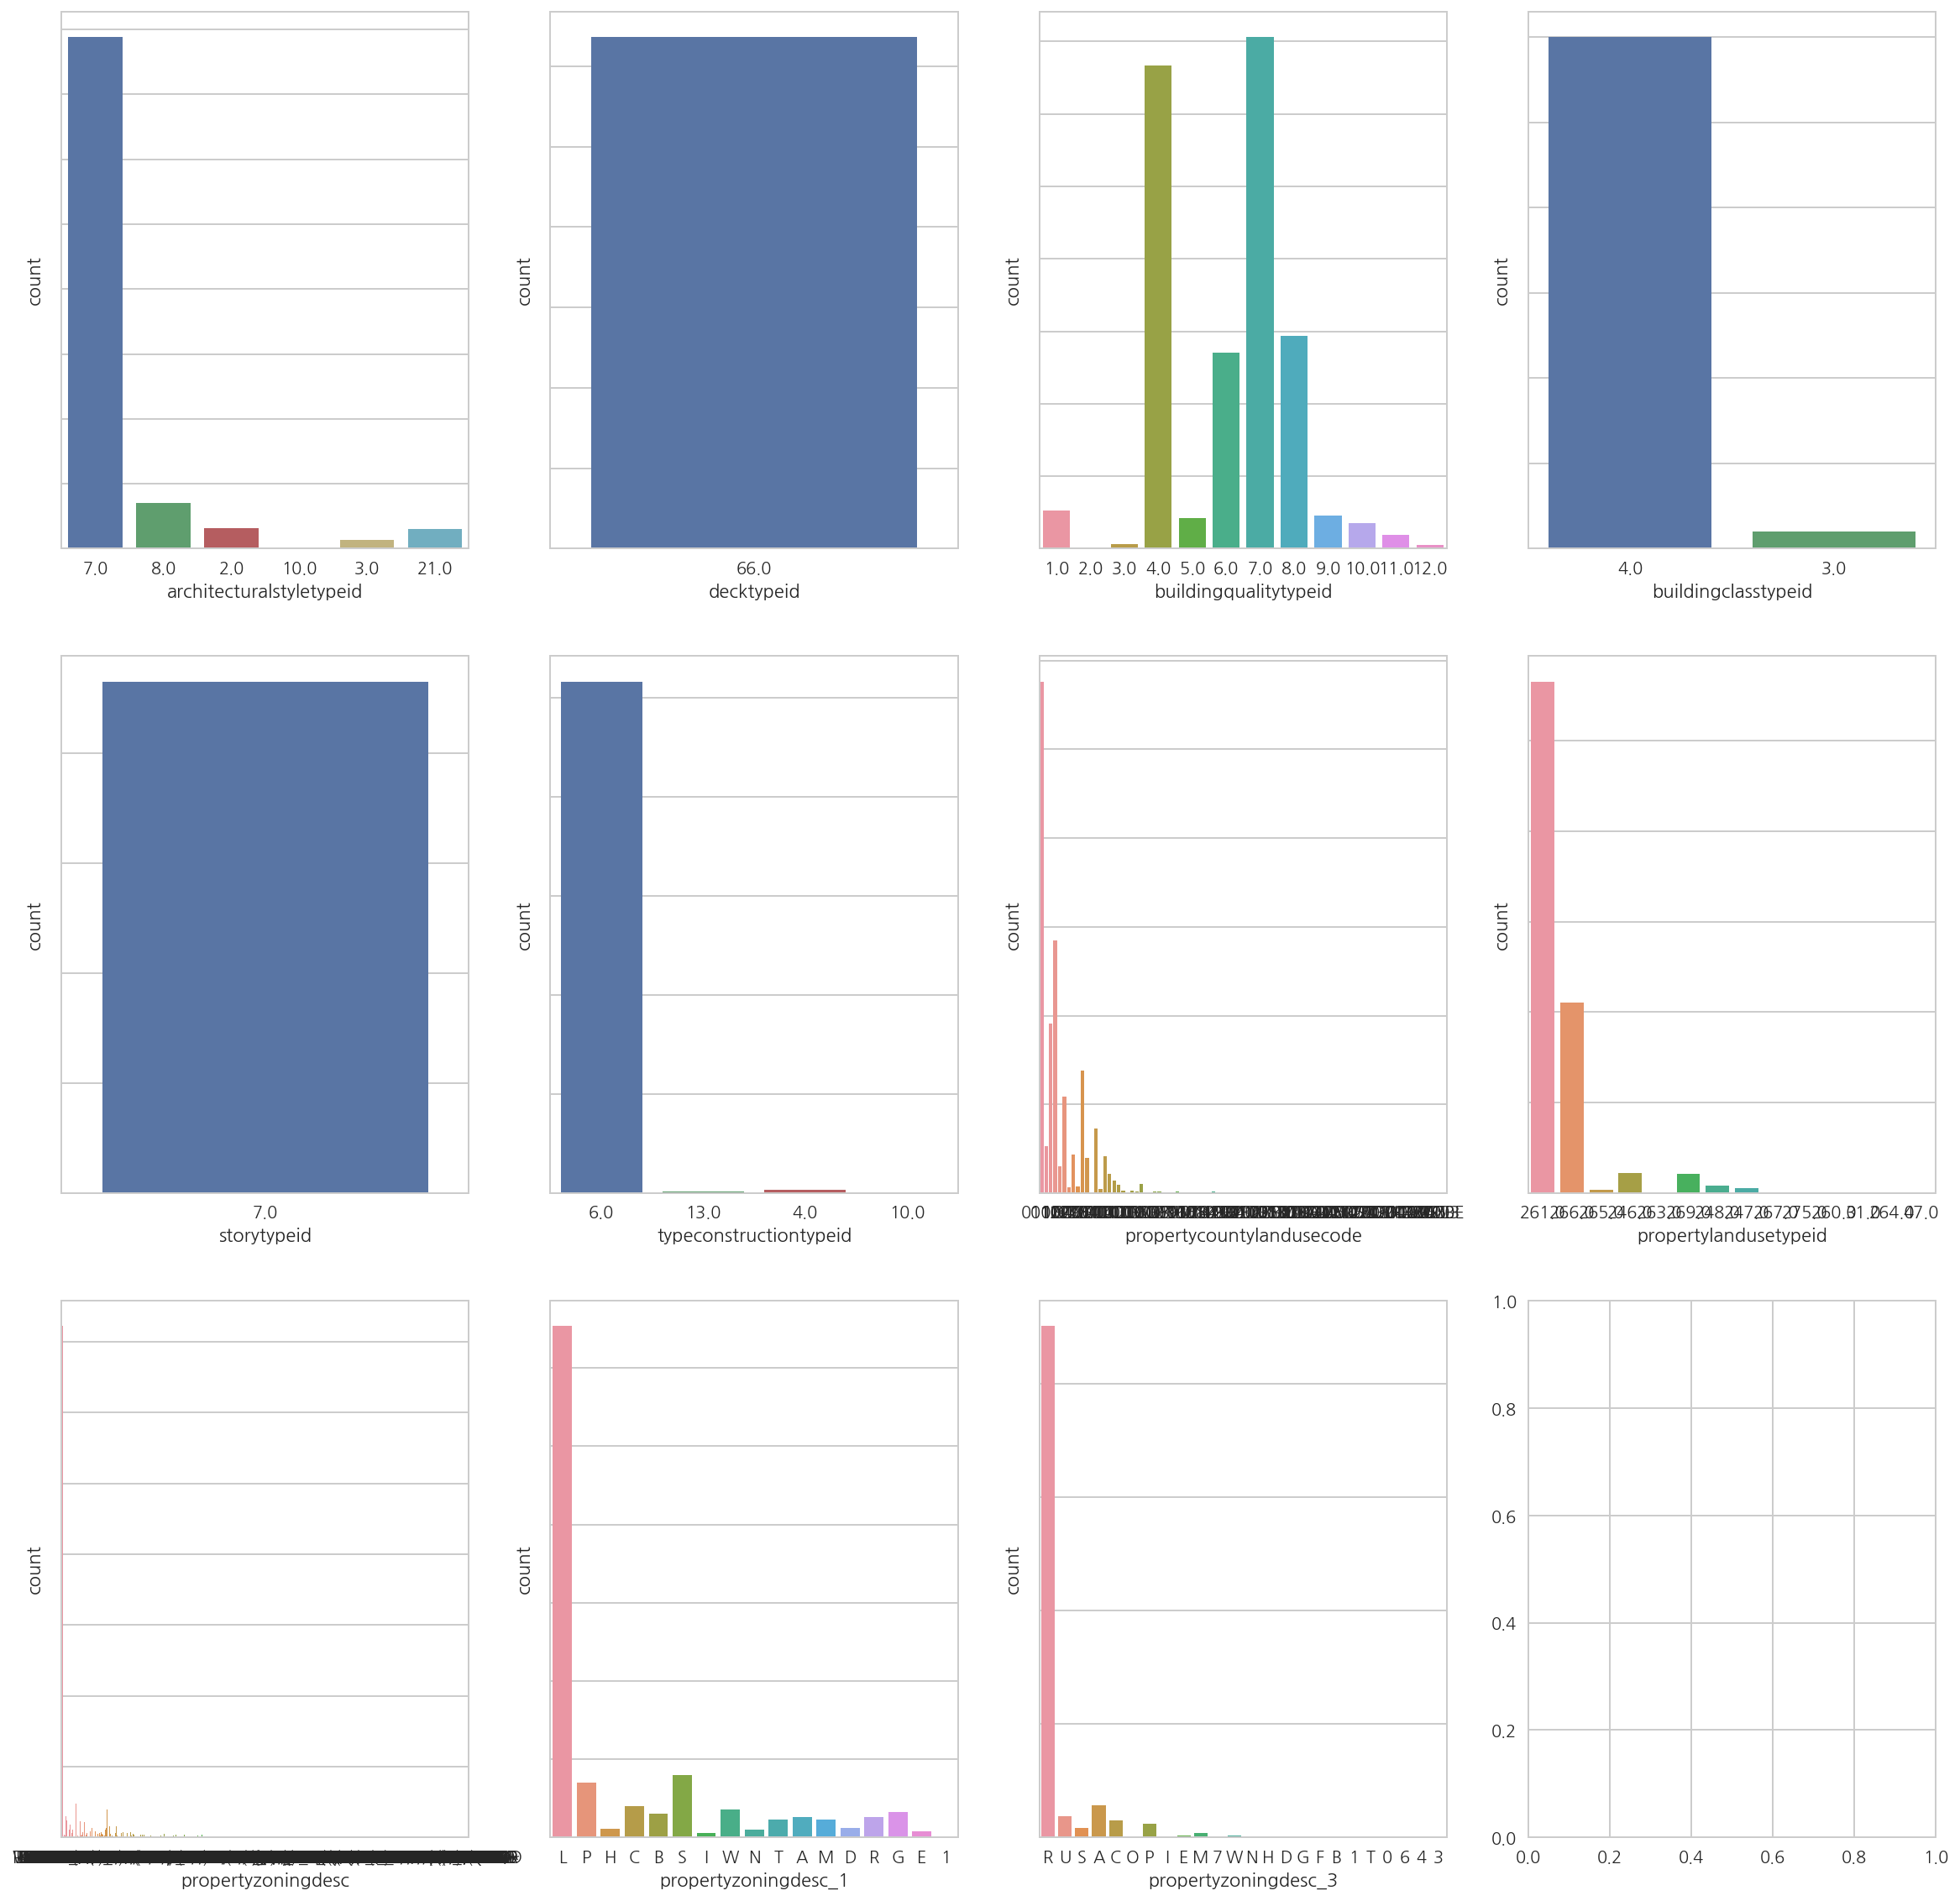

In [136]:
bdg_var = ["architecturalstyletypeid", "decktypeid", "buildingqualitytypeid", "buildingclasstypeid",
           "storytypeid", "typeconstructiontypeid", "propertycountylandusecode", "propertylandusetypeid",
           "propertyzoningdesc", "propertyzoningdesc_1", "propertyzoningdesc_3"]

fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(bdg_var):
    sns.countplot(x = n, data = merged, ax = ax[idx // 4, idx % 4])
    ax[idx // 4, idx % 4].set(yticklabels=[])
    
    continue

#### **3) 집 구조 등에 대한 변수들**
- 전체 리스트: bathroomcnt, calculatedbathnbr, threequarterbathnbr, fullbathcnt, numberofstories, roomcnt, bedroomcnt, unitcnt, yearbuilt 

In [117]:
merged_des.loc[["bathroomcnt", "calculatedbathnbr", "threequarterbathnbr", "fullbathcnt", "numberofstories", "roomcnt", "bedroomcnt", "unitcnt", "yearbuilt"],:]

count unique  top freq first last     mean       std  \
bathroomcnt          167854    NaN  NaN  NaN   NaN  NaN  2.28827   1.00084   
calculatedbathnbr    166056    NaN  NaN  NaN   NaN  NaN  2.31254  0.977808   
threequarterbathnbr   22115    NaN  NaN  NaN   NaN  NaN  1.00913  0.109294   
fullbathcnt          166056    NaN  NaN  NaN   NaN  NaN  2.24534  0.964703   
numberofstories       38169    NaN  NaN  NaN   NaN  NaN  1.43776  0.544508   
roomcnt              167854    NaN  NaN  NaN   NaN  NaN  1.47748    2.8215   
bedroomcnt           167854    NaN  NaN  NaN   NaN  NaN  3.04174   1.14913   
unitcnt              109056    NaN  NaN  NaN   NaN  NaN  1.11037  0.988168   
yearbuilt            166828    NaN  NaN  NaN   NaN  NaN  1968.57   23.7772   

                      min   25%   50%   75%   max missing_ratio    dtype  
bathroomcnt             0     2     2     3    20   0.000202516  float64  
calculatedbathnbr       1     2     2     3    20      0.010912  float64  
threequarterbathnbr     1     1     1     1     7      0.868275  float64  
fullbathcnt             1     2     2     3    20      0.010912  float64  
numberofstories         1     1     1     2     6      0.772652  float64  
roomcnt                 0     0     0     0    18   0.000202516  float64  
bedroomcnt              0     2     3     4    16   0.000202516  float64  
unitcnt                 1     1     1     1   237      0.350424  float64  
yearbuilt            1824  1953  1970  1987  2016    0.00631373  float64

- missing value ratio가 특히 높은 변수는 "threequarterbathnbr"과 "numberofstories", 그리고 "unitcnt"

##### bathroom 관련 변수들
- fullbath란 tub까지 모두 갖춘 화장실, 3/4 bath란 tub이 없고 샤워부스만 있는 화장실, half bath는 변기와 세면대만 있는 화장실을 말함
- bathroomcnt와 calculatedbathnbr: Number of bathrooms in home including fractional bathrooms(=0.5?)
- threequarterbathnbr: missing value 높음 (imputation: 0 or 1)
- fullbathcnt

In [120]:
bathroomcnt = pd.DataFrame(merged["bathroomcnt"])
bathroomcnt = bathroomcnt.groupby("bathroomcnt").size().reset_index(name='counts')
# bathroomcnt

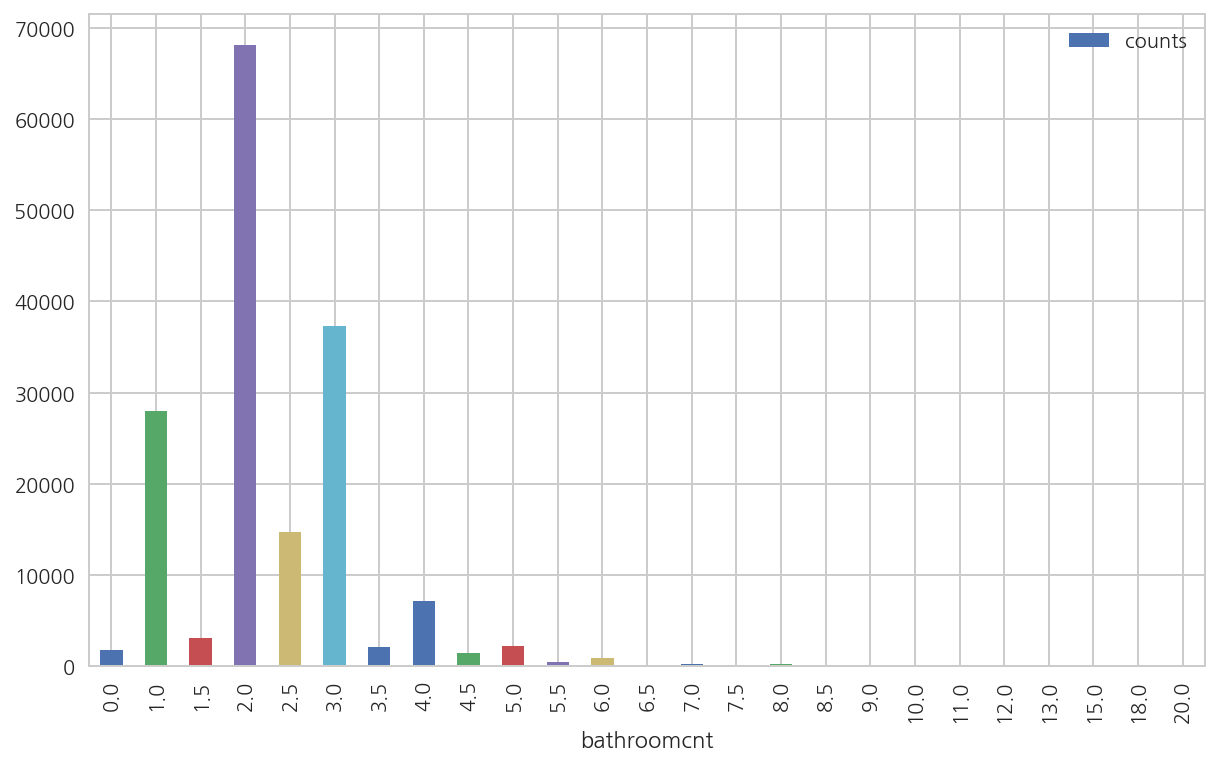

In [121]:
bathroomcnt.plot(x = 'bathroomcnt', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

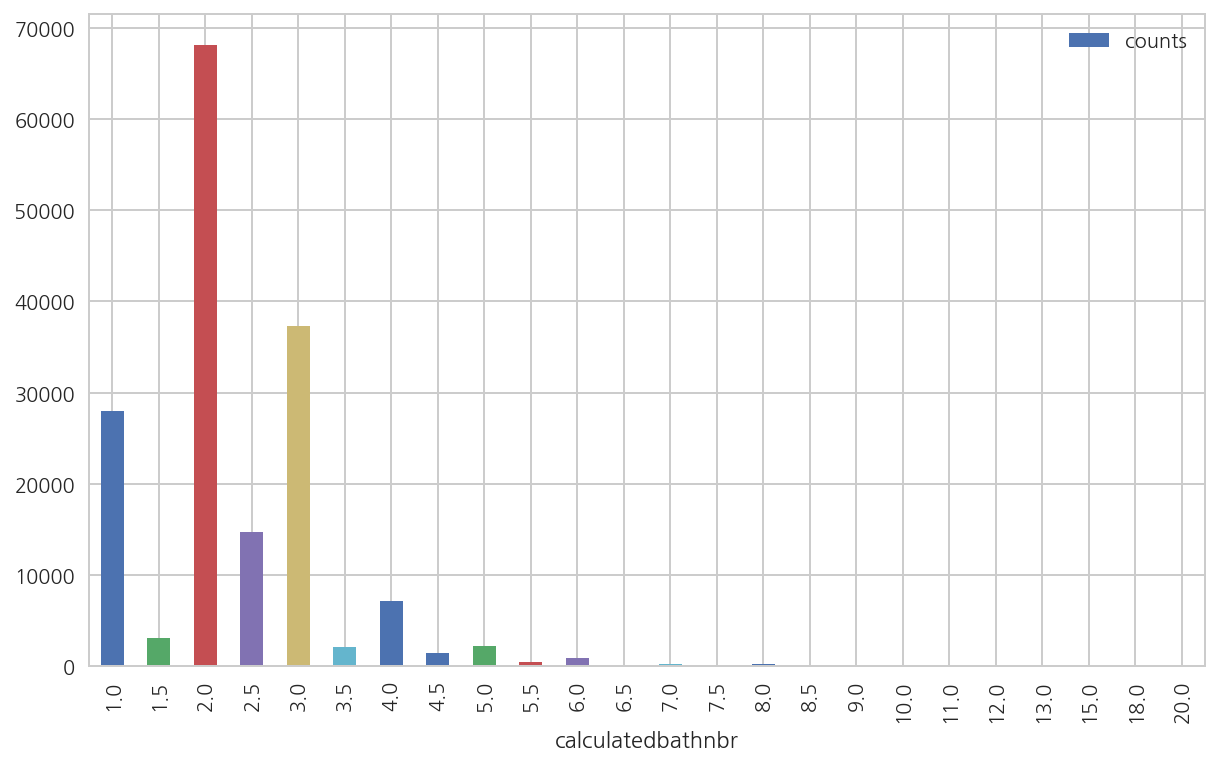

In [124]:
calculatedbathnbr = pd.DataFrame(merged["calculatedbathnbr"])
calculatedbathnbr = calculatedbathnbr.groupby("calculatedbathnbr").size().reset_index(name='counts')
calculatedbathnbr.plot(x = 'calculatedbathnbr', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

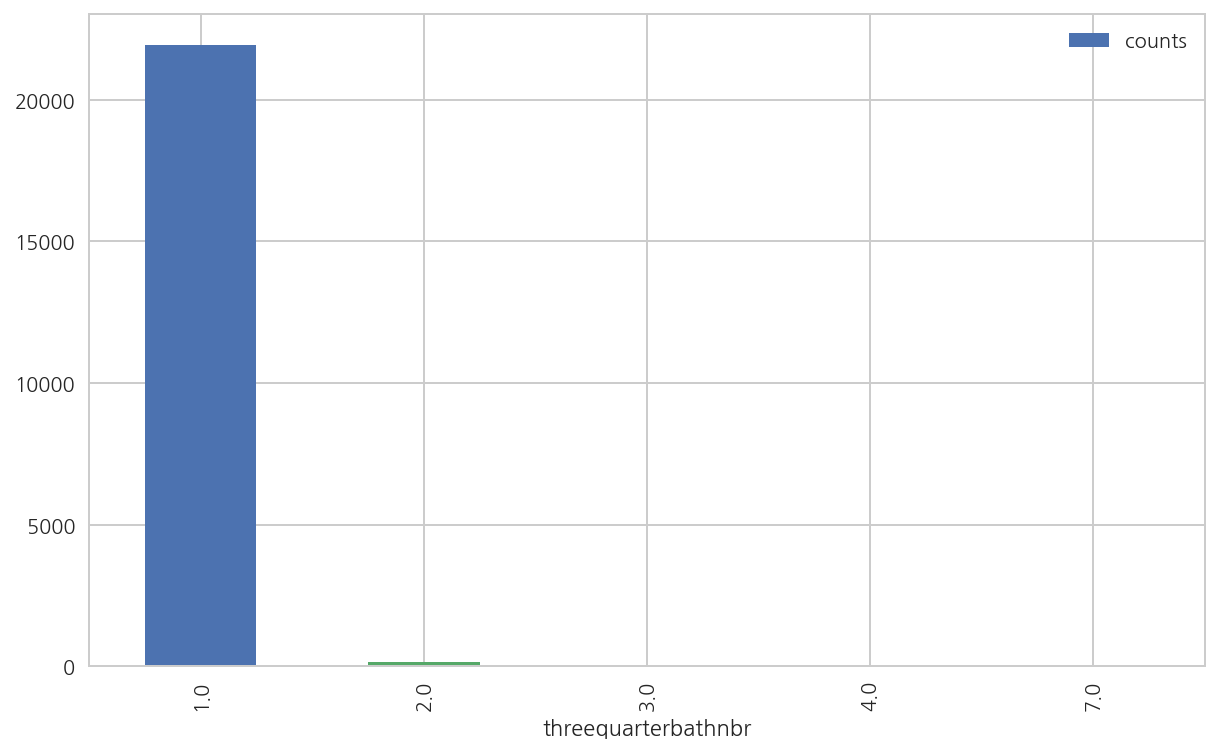

In [126]:
threequarterbathnbr = pd.DataFrame(merged["threequarterbathnbr"])
threequarterbathnbr = threequarterbathnbr.groupby("threequarterbathnbr").size().reset_index(name='counts')
threequarterbathnbr.plot(x = 'threequarterbathnbr', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

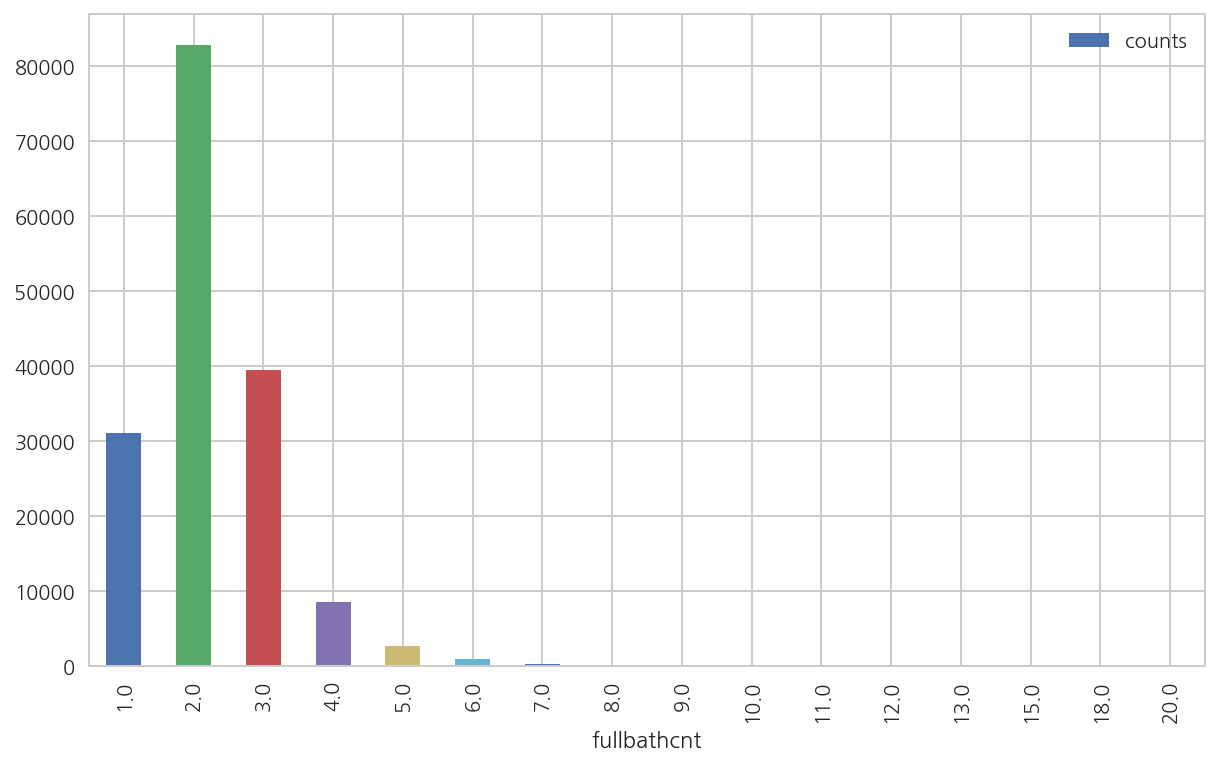

In [127]:
fullbathcnt = pd.DataFrame(merged["fullbathcnt"])
fullbathcnt = fullbathcnt.groupby("fullbathcnt").size().reset_index(name='counts')
fullbathcnt.plot(x = 'fullbathcnt', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

##### Numberofstories
- 최빈값인 1로 imputation 할 수 있겠음 (보통은 1층집)

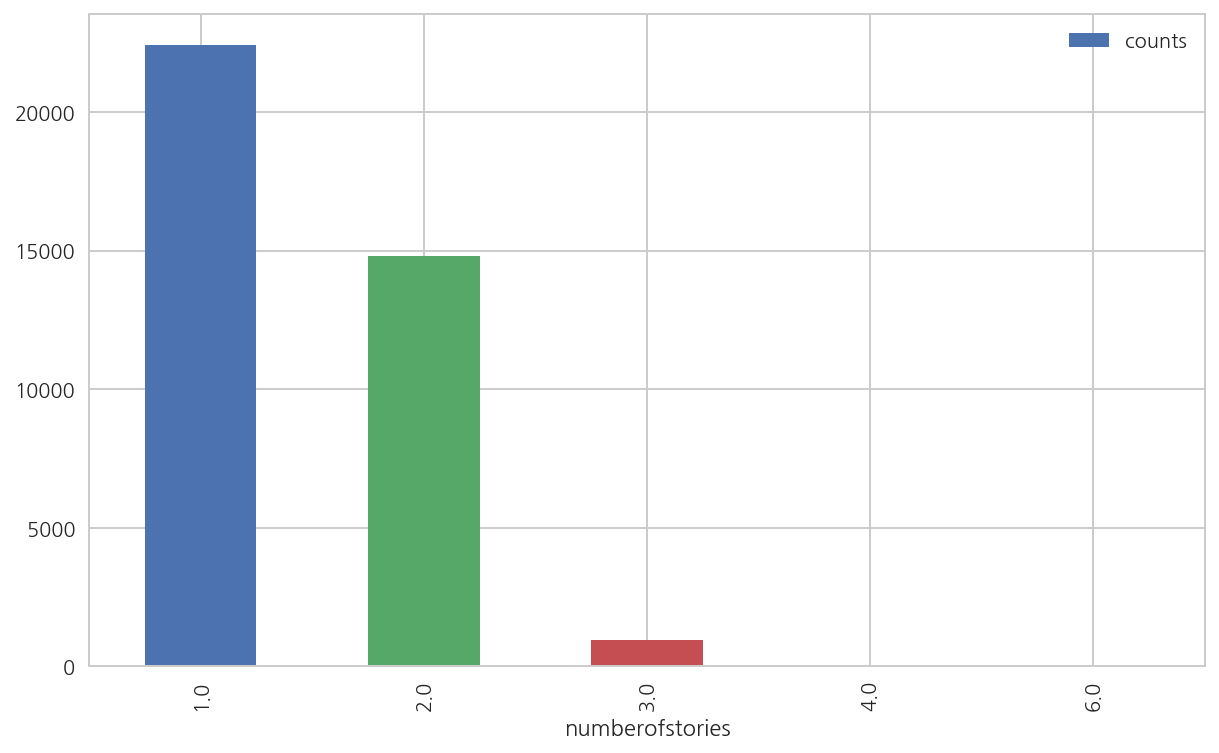

In [145]:
numberofstories = pd.DataFrame(merged["numberofstories"])
numberofstories = numberofstories.groupby("numberofstories").size().reset_index(name='counts')
numberofstories.plot(x = 'numberofstories', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

##### roomcnt & bedroomcnt
- roomcnt: Total number of rooms in the principal residence
    - 0이 많다는 점이 특징

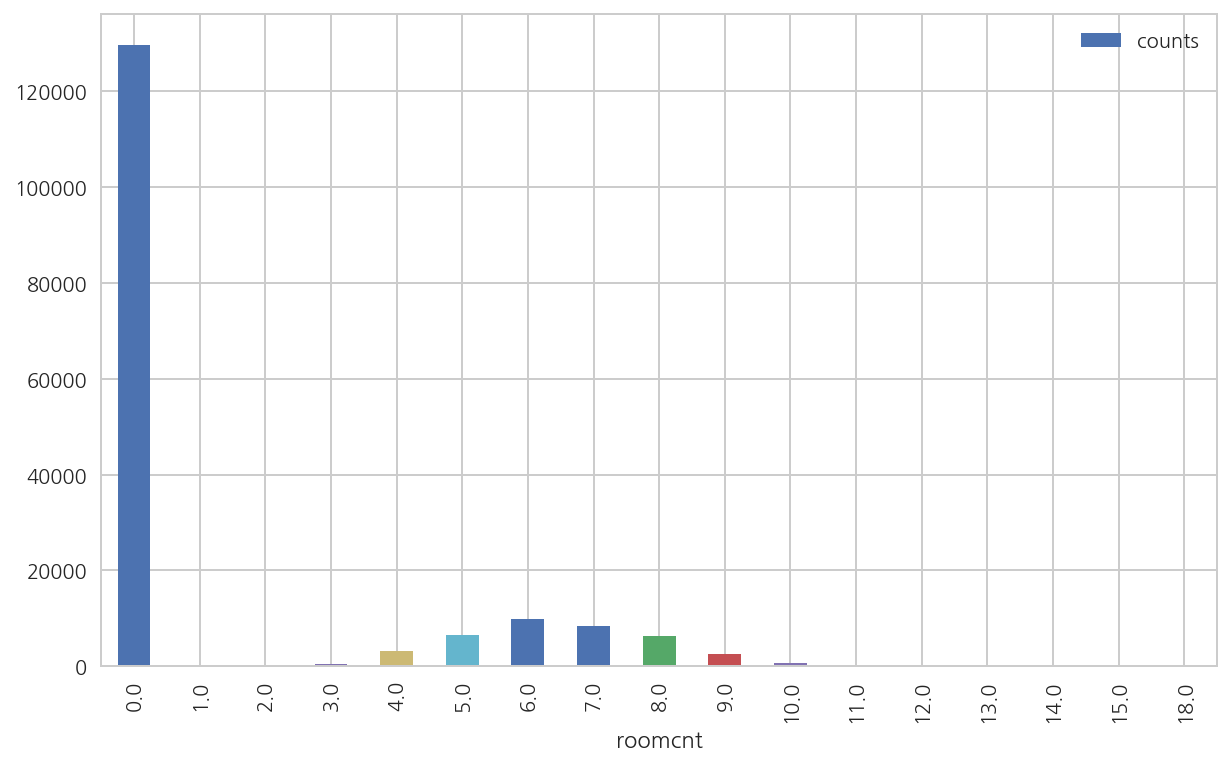

In [128]:
roomcnt = pd.DataFrame(merged["roomcnt"])
roomcnt = roomcnt.groupby("roomcnt").size().reset_index(name='counts')
roomcnt.plot(x = 'roomcnt', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

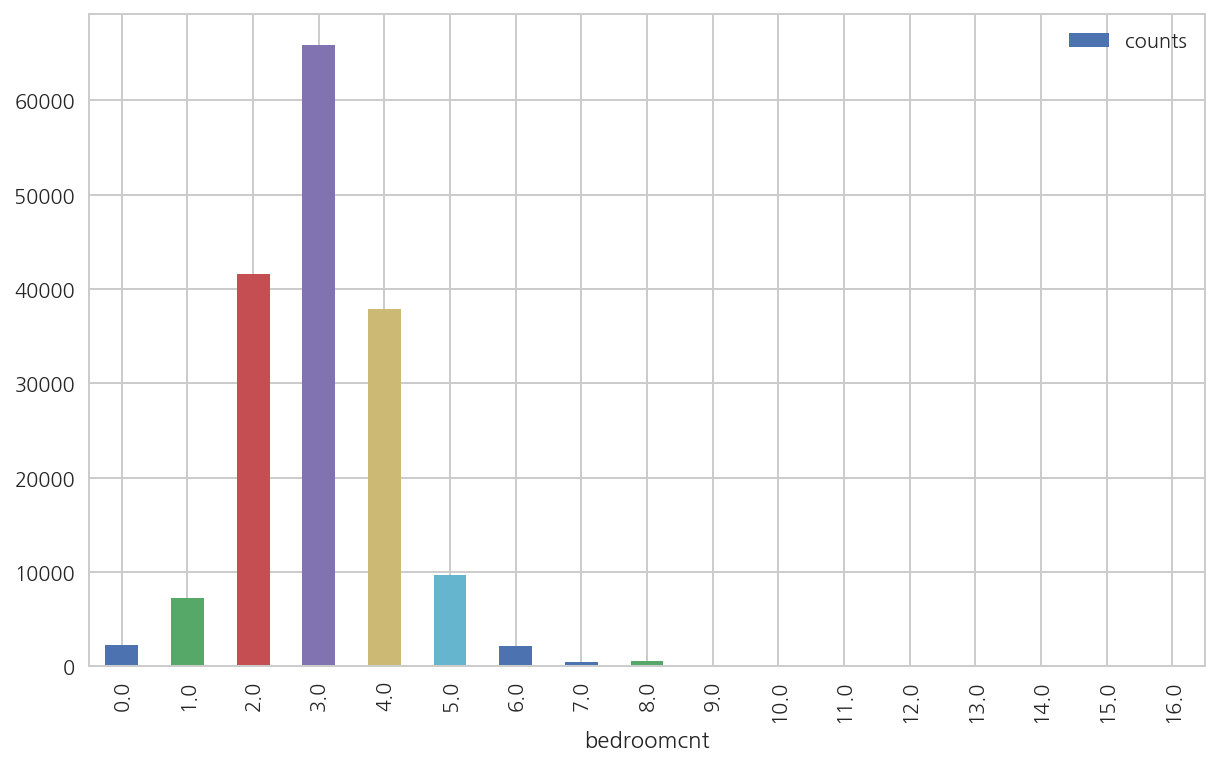

In [129]:
bedroomcnt = pd.DataFrame(merged["bedroomcnt"])
bedroomcnt = bedroomcnt.groupby("bedroomcnt").size().reset_index(name='counts')
bedroomcnt.plot(x = 'bedroomcnt', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

In [133]:
# df_rooms = pd.concat([feet_df_desc.loc['roomcnt'], feet_df_desc.loc['bedroomcnt']], axis=1)
# df_rooms
merged_des.loc[["roomcnt", "bedroomcnt"],:]

count unique  top freq first last     mean      std min 25% 50%  \
roomcnt     167854    NaN  NaN  NaN   NaN  NaN  1.47748   2.8215   0   0   0   
bedroomcnt  167854    NaN  NaN  NaN   NaN  NaN  3.04174  1.14913   0   2   3   

           75% max missing_ratio    dtype  
roomcnt      0  18   0.000202516  float64  
bedroomcnt   4  16   0.000202516  float64

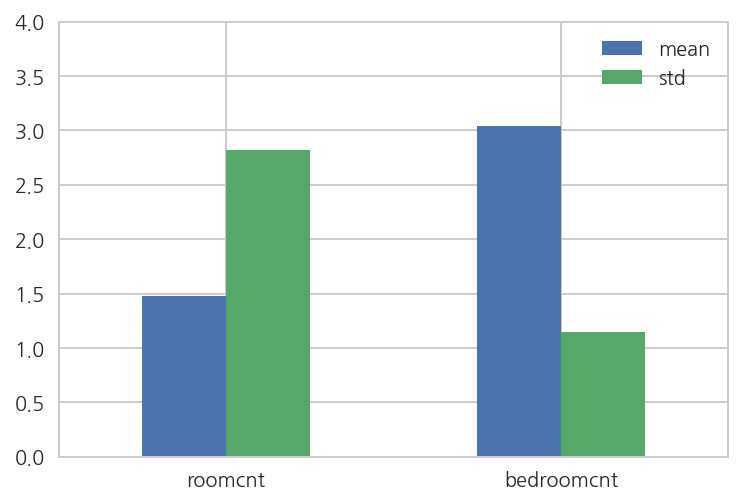

In [134]:
merged_des.loc[["roomcnt", "bedroomcnt"],["mean","std"]].plot.bar(rot=0)
plt.ylim(0, 4)
plt.show()

##### unitcnt
- imputation: 최빈값인 1로 할 수 있겠음 (대부분 집은 1가구)

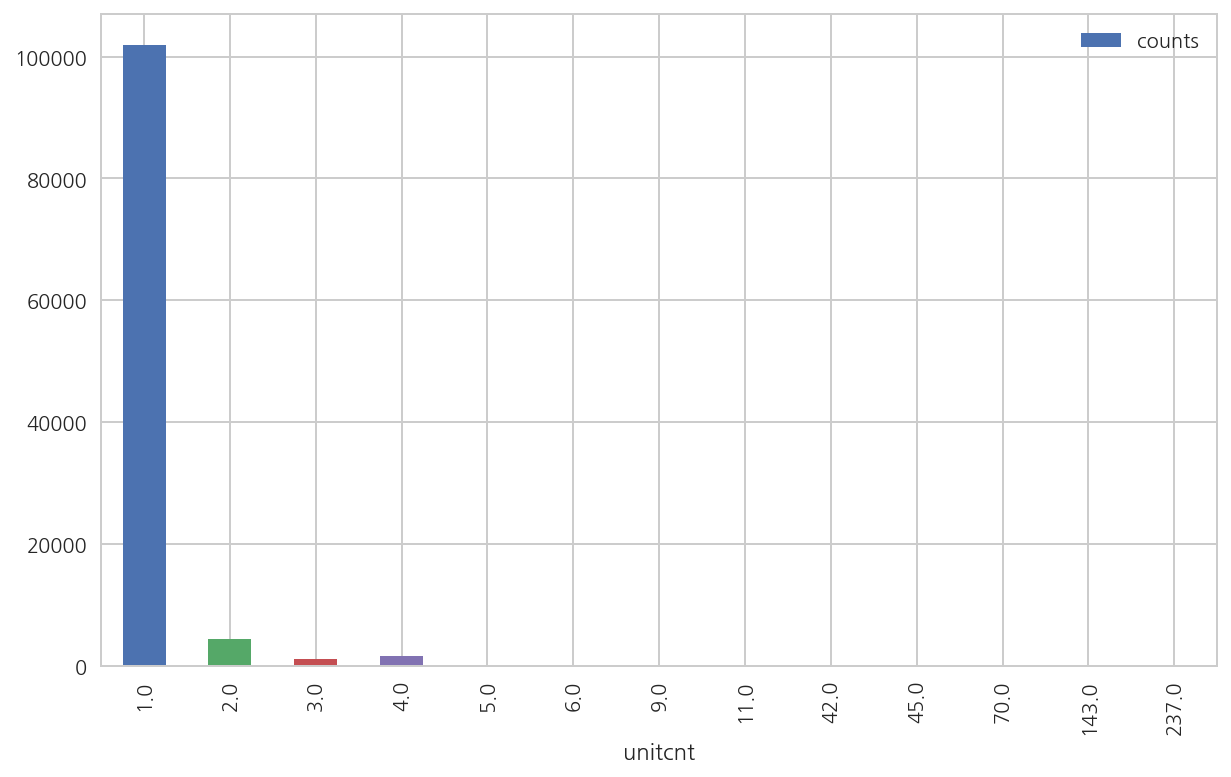

In [59]:
unitcnt = pd.DataFrame(merged["unitcnt"])
unitcnt = unitcnt.groupby("unitcnt").size().reset_index(name='counts')
unitcnt.plot(x = 'unitcnt', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

##### yearbuilt

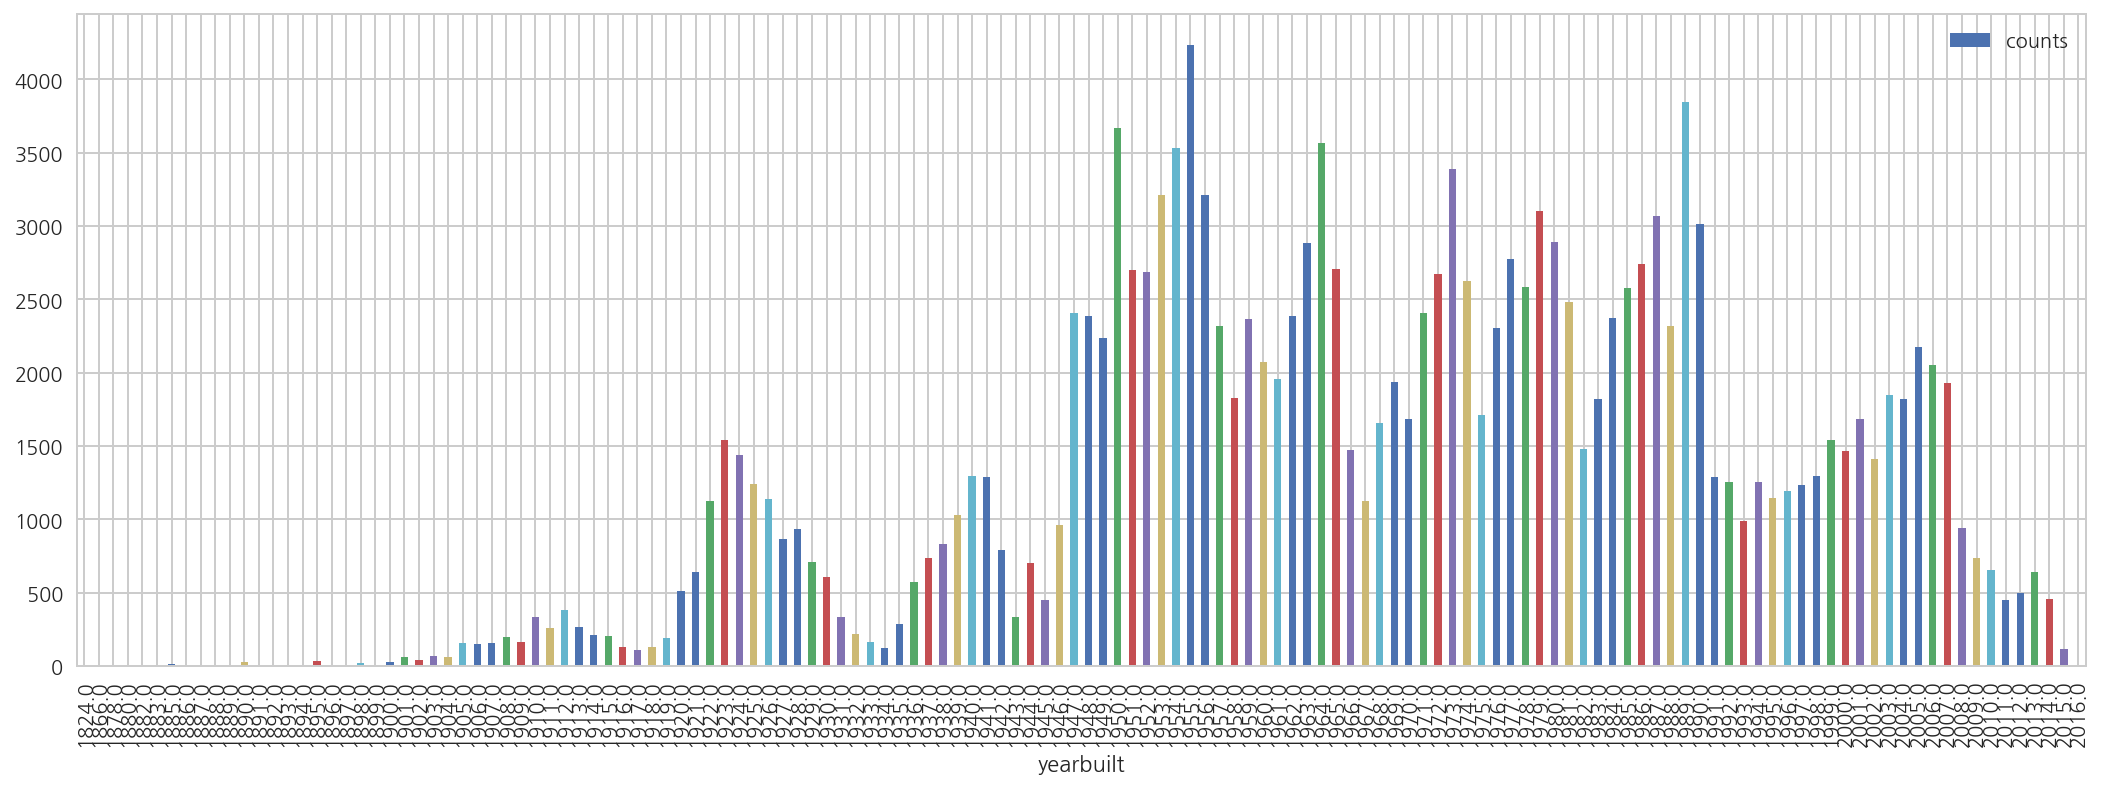

In [139]:
yearbuilt = pd.DataFrame(merged["yearbuilt"])
yearbuilt = yearbuilt.groupby("yearbuilt").size().reset_index(name='counts')
yearbuilt.plot(x = 'yearbuilt', y = 'counts', kind = 'bar', figsize=(18, 6))
plt.show()

#### **4) 집의 기타 특징(유틸리티 등)에 대한 변수들**
- 전체 리스트: heatingorsystemtypeid, airconditioningtypeid, hashottuborspa, fireplacecnt, fireplaceflag, poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7
- fireplacecnt, poolcnt는 count 변수
- heating/airconditioning type은 카테고리 변수
- hashottuborspa,  pooltypeid10, pooltypeid2, pooltypeid7는 dummy 변수

In [93]:
merged_des.loc[["heatingorsystemtypeid", "airconditioningtypeid", "hashottuborspa", "fireplacecnt", "fireplaceflag", "poolcnt",
                "poolsizesum", "pooltypeid10", "pooltypeid2", "pooltypeid7"],:]

count unique   top   freq first last     mean  \
heatingorsystemtypeid  105651     12   2.0  71936   NaN  NaN      NaN   
airconditioningtypeid   53788      6   1.0  49854   NaN  NaN      NaN   
hashottuborspa           3904      1  True   3904   NaN  NaN      NaN   
fireplacecnt            17896    NaN   NaN    NaN   NaN  NaN  1.18943   
fireplaceflag             394      1  True    394   NaN  NaN      NaN   
poolcnt                 34075    NaN   NaN    NaN   NaN  NaN        1   
poolsizesum              1838    NaN   NaN    NaN   NaN  NaN  518.931   
pooltypeid10             1626    NaN   NaN    NaN   NaN  NaN        1   
pooltypeid2              2278    NaN   NaN    NaN   NaN  NaN        1   
pooltypeid7             31776    NaN   NaN    NaN   NaN  NaN        1   

                            std  min  25%  50%  75%   max missing_ratio  \
heatingorsystemtypeid       NaN  NaN  NaN  NaN  NaN   NaN      0.370705   
airconditioningtypeid       NaN  NaN  NaN  NaN  NaN   NaN       0.67962   
hashottuborspa              NaN  NaN  NaN  NaN  NaN   NaN      0.976746   
fireplacecnt           0.487327    1    1    1    1     5      0.893405   
fireplaceflag               NaN  NaN  NaN  NaN  NaN   NaN      0.997653   
poolcnt                       0    1    1    1    1     1      0.797037   
poolsizesum             155.733   24  420  500  600  1750      0.989052   
pooltypeid10                  0    1    1    1    1     1      0.990315   
pooltypeid2                   0    1    1    1    1     1      0.986431   
pooltypeid7                   0    1    1    1    1     1      0.810731   

                         dtype  
heatingorsystemtypeid   object  
airconditioningtypeid   object  
hashottuborspa          object  
fireplacecnt           float64  
fireplaceflag           object  
poolcnt                float64  
poolsizesum            float64  
pooltypeid10           float64  
pooltypeid2            float64  
pooltypeid7            float64

- missing value ratio가 높은 변수들이 많음
- pool 관련 변수, fireplace, hot tub or spa는 NaN 값은 없는 경우로 보아 0으로 imputation
- heating system, airconditioning type은 imputation이 애매한 경우

##### heatingorsystemtypeid & airconditioningtypeid
- 난방과 에어컨 타입에 대한 카테고리 변수
- 난방: 2-Central, 7-Floor/Wall, 13-None, 24-Yes
    - class에 none과 yes도 있음으로 미루어 NaN값의 분포도 유사할 것이라고 추측, 최빈값인 2로 imputation 가능
    - 혹은 13과 NaN을 0으로, 나머지는 1로 하여 heating_flag 같은 변수로 만들 수 있음
- 에어컨: 1-Central, 5-None, 11-Wall unit, 13-Yes
    - class에 none과 yes도 있음으로 미루어 NaN값의 분포도 유사할 것이라고 추측, 최빈값인 1로 imputation 가능
    - 혹은 5과 NaN을 0으로, 나머지는 1로 하여 aircond_flag 같은 변수로 만들 수 있음
- 하지만 난방의 37%와 에어컨의 68%를 '없다'고 가정하는 것은 무리가 있어 보임

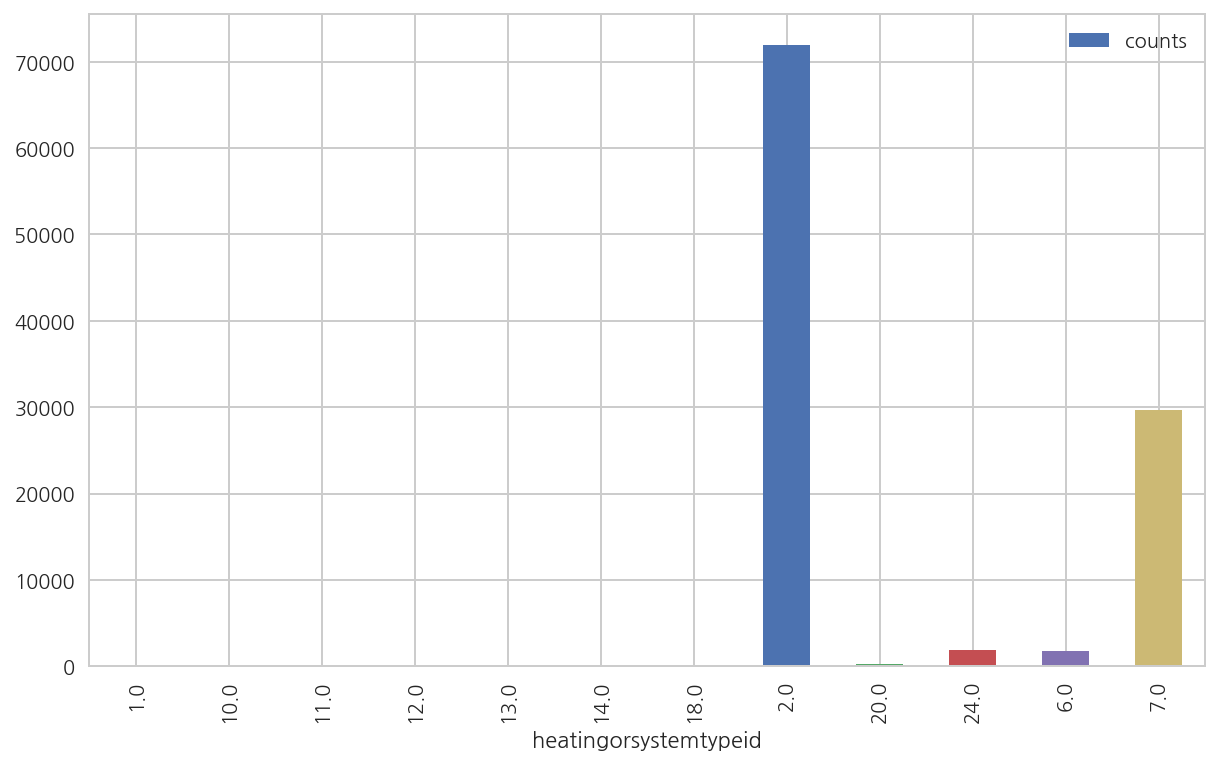

In [142]:
heatingorsystemtypeid = pd.DataFrame(merged["heatingorsystemtypeid"])
heatingorsystemtypeid = heatingorsystemtypeid.groupby("heatingorsystemtypeid").size().reset_index(name='counts')
heatingorsystemtypeid.plot(x = 'heatingorsystemtypeid', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

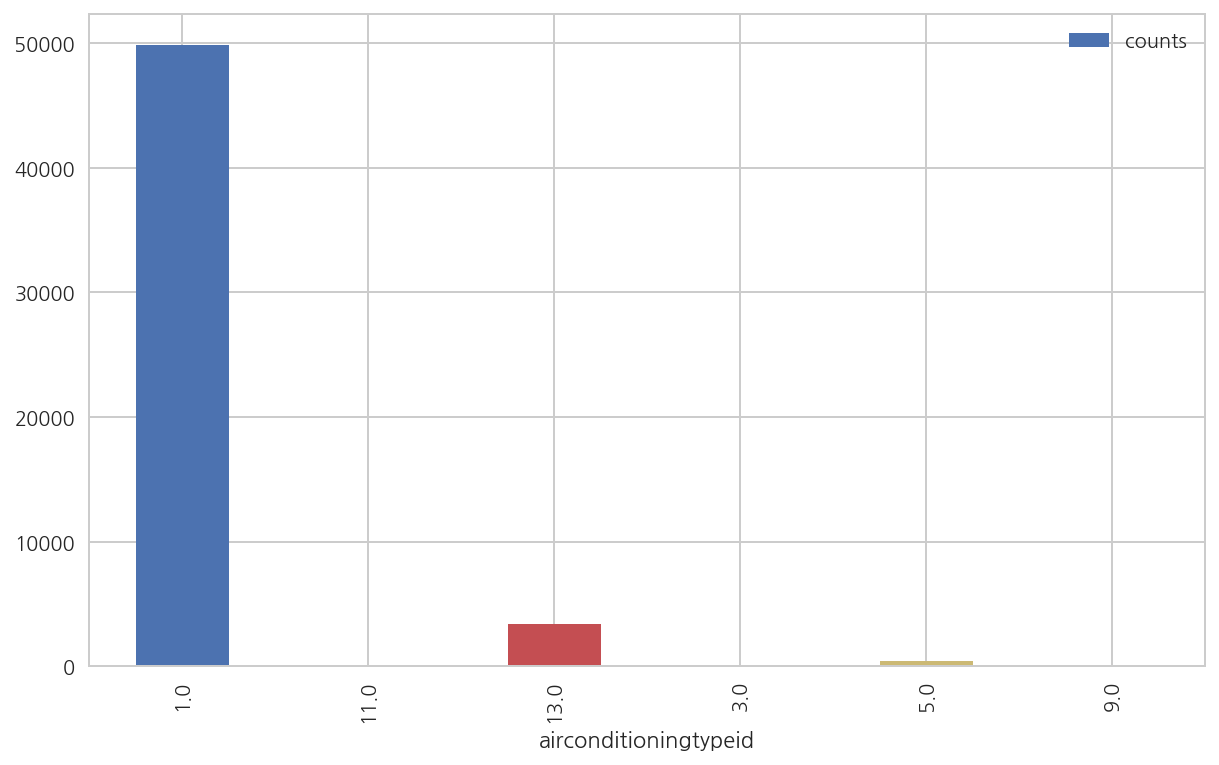

In [60]:
airconditioningtypeid = pd.DataFrame(merged["airconditioningtypeid"])
airconditioningtypeid = airconditioningtypeid.groupby("airconditioningtypeid").size().reset_index(name='counts')
airconditioningtypeid.plot(x = 'airconditioningtypeid', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

##### fireplacecnt & fireplaceflag
- NaN값은 없는 경우라고 간주, 0으로 imputation

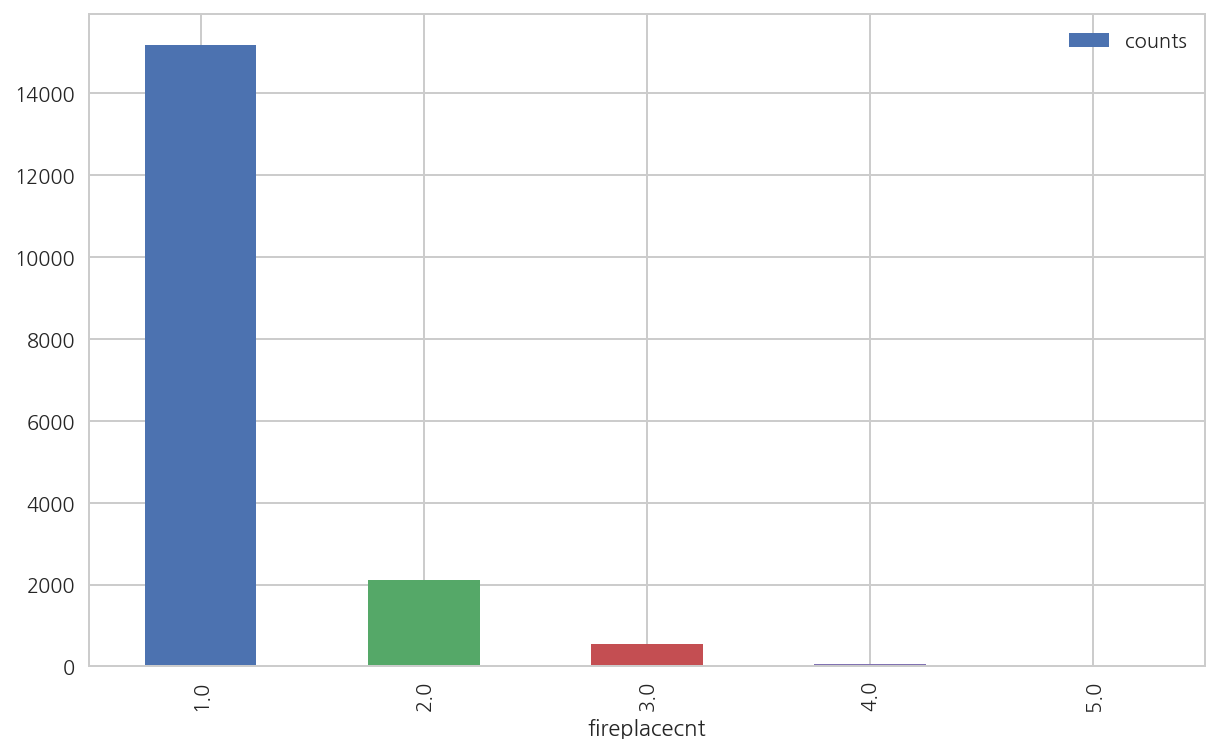

In [148]:
fireplacecnt = pd.DataFrame(merged["fireplacecnt"])
fireplacecnt = fireplacecnt.groupby("fireplacecnt").size().reset_index(name='counts')
fireplacecnt.plot(x = 'fireplacecnt', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

In [153]:
fireplaceflag = pd.DataFrame(merged["fireplaceflag"])
fireplaceflag = fireplaceflag.groupby("fireplaceflag").size().reset_index(name='counts')
fireplaceflag

fireplaceflag  counts
0           True     394

##### pool 관련 변수들
- poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7, hashottuborspa
- 이 변수들은 NaN 값을 없는 경우로 간주, 0으로 imputation

In [155]:
# poolcnt: pool의 개수
pd.DataFrame(merged['poolcnt'].value_counts().sort_index())

poolcnt
1.0    34075

In [160]:
# hashottuborspa: Does the home have a hot tub or spa
pd.DataFrame(merged['hashottuborspa'].value_counts().sort_index())

hashottuborspa
True            3904

In [156]:
# pooltypeid10: Spa or Hot Tub
pd.DataFrame(merged['pooltypeid10'].value_counts().sort_index())

pooltypeid10
1.0          1626

In [158]:
# pooltypeid7: Pool without hot tub
pd.DataFrame(merged['pooltypeid2'].value_counts().sort_index())

pooltypeid2
1.0         2278

In [166]:
pd.DataFrame(merged['pooltypeid7'].value_counts().sort_index())

pooltypeid7
1.0        31776

In [ ]:
poolsizesum

#### **5) 집의 면적에 대한 변수들**
- basementsqft, finishedfloor1squarefeet, calculatedfinishedsquarefeet, finishedsquarefeet6, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, yardbuildingsqft17, yardbuildingsqft26, garagecarcnt, garagetotalsqft, lotsizesquarefeet

In [74]:
merged_des.loc[["basementsqft", "calculatedfinishedsquarefeet", "finishedfloor1squarefeet", "finishedsquarefeet6",
                "finishedsquarefeet12", "finishedsquarefeet13","finishedsquarefeet15","finishedsquarefeet50",
                "yardbuildingsqft17","yardbuildingsqft26","garagecarcnt","garagetotalsqft", "lotsizesquarefeet"],
               ["count", "mean", "std", "min", "25%", "50%", "75%", "max", "missing_ratio", "dtype"]]

count     mean       std   min   25%   50%  \
basementsqft                      93  695.376   583.952    38   280   588   
calculatedfinishedsquarefeet  166992  1778.63   940.356     2  1183  1541   
finishedfloor1squarefeet       12893  1356.49   661.069    44   945  1252   
finishedsquarefeet6              807  2197.29   1300.55   257  1057  1886   
finishedsquarefeet12          159519  1752.33   921.361     2  1172  1520   
finishedsquarefeet13              75  1395.71   116.539  1056  1344  1440   
finishedsquarefeet15            6591  2368.33    1124.3   560  1634  2099   
finishedsquarefeet50           12893  1367.65   698.669    44   945  1252   
yardbuildingsqft17              5039  307.919   227.431    11   175   252   
yardbuildingsqft26               165  271.261   293.611    12    88   160   
garagecarcnt                   55457  1.81351  0.599447     0     2     2   
garagetotalsqft                55457  347.604   264.566     0     0   434   
lotsizesquarefeet             149446  29510.6    122459   167  5702  7200   

                                  75%          max missing_ratio    dtype  
basementsqft                      819         3560      0.999446  float64  
calculatedfinishedsquarefeet     2103        35640    0.00533689  float64  
finishedfloor1squarefeet         1615         7625      0.923205  float64  
finishedsquarefeet6              3240         7224      0.995193  float64  
finishedsquarefeet12             2065        21929     0.0498487  float64  
finishedsquarefeet13             1440         1584      0.999553  float64  
finishedsquarefeet15             2845        35640      0.960742  float64  
finishedsquarefeet50             1619        12467      0.923205  float64  
yardbuildingsqft17                375         3191      0.969986  float64  
yardbuildingsqft26                320         1366      0.999017  float64  
garagecarcnt                        2           24      0.669679  float64  
garagetotalsqft                   488         7339      0.669679  float64  
lotsizesquarefeet             11746.8  6.97101e+06      0.109847  float64

##### (5)-1. basementsqft
- Finished living area below or partially below ground level(지면보다 낮거나 부분적으로 낮은 부분)

(array([31., 32., 14.,  7.,  5.,  2.,  0.,  0.,  1.,  1.]),
 array([  38. ,  390.2,  742.4, 1094.6, 1446.8, 1799. , 2151.2, 2503.4,
        2855.6, 3207.8, 3560. ]),
 <a list of 10 Patch objects>)

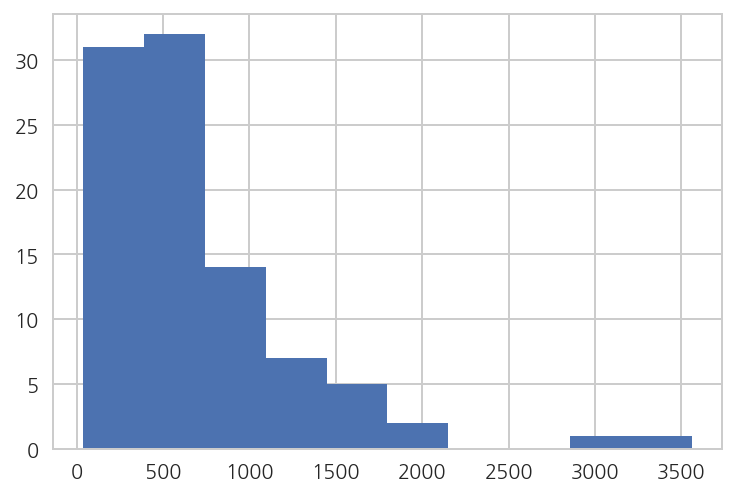

In [171]:
plt.hist(merged[merged['basementsqft'].notnull()==True]['basementsqft'])

In [ ]:
# sns.distplot(feet_df['basementsqft'].notnull(), kde=True, rug=True)

##### (5)-2. calculatedfinishedsquarefeet
- Calculated total finished living area of the home(가정의 (마감)완료된 총 거주 면적)

(array([1.59086e+05, 7.52300e+03, 3.37000e+02, 3.00000e+01, 8.00000e+00,
        5.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([2.00000e+00, 3.56580e+03, 7.12960e+03, 1.06934e+04, 1.42572e+04,
        1.78210e+04, 2.13848e+04, 2.49486e+04, 2.85124e+04, 3.20762e+04,
        3.56400e+04]),
 <a list of 10 Patch objects>)

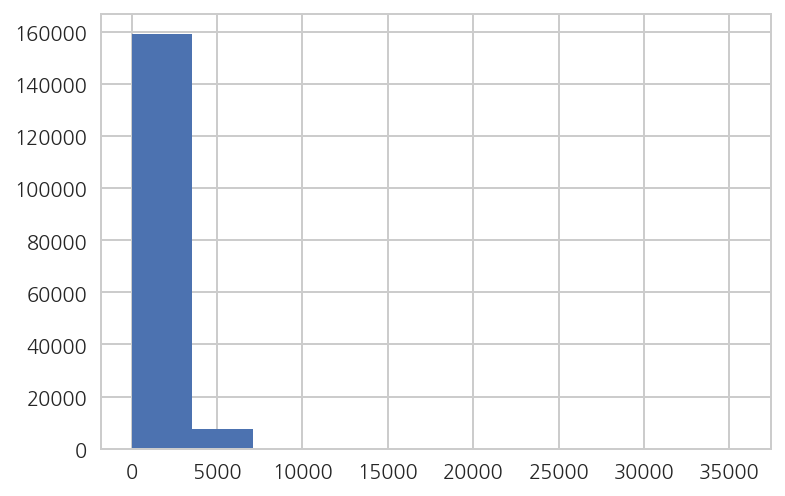

In [172]:
plt.hist(merged[merged['calculatedfinishedsquarefeet'].notnull()==True]['calculatedfinishedsquarefeet'])

##### (5)-3. finishedfloor1squarefeet
- Size of the finished living area on the first (entry) floor of the home (주택 1층 생활 공간의 규모)

(array([2.060e+03, 7.216e+03, 2.753e+03, 5.500e+02, 1.870e+02, 7.800e+01,
        2.800e+01, 1.000e+01, 8.000e+00, 3.000e+00]),
 array([  44. ,  802.1, 1560.2, 2318.3, 3076.4, 3834.5, 4592.6, 5350.7,
        6108.8, 6866.9, 7625. ]),
 <a list of 10 Patch objects>)

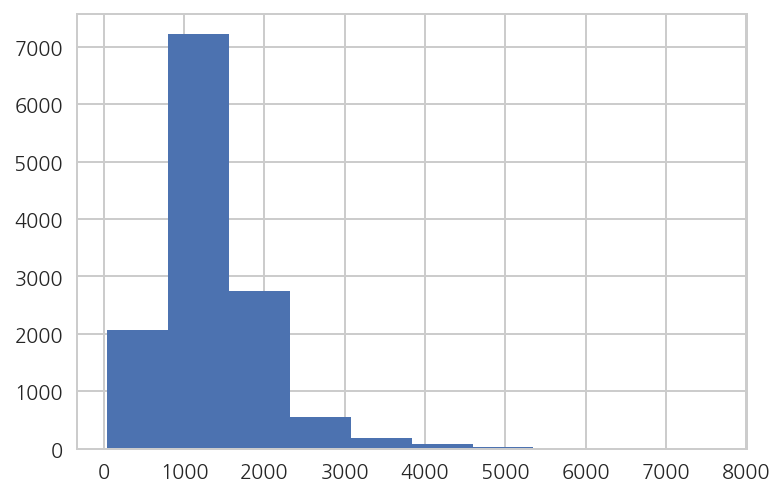

In [173]:
plt.hist(merged[merged['finishedfloor1squarefeet'].notnull()==True]['finishedfloor1squarefeet'])

##### (5)-4. finishedsquarefeet6
- Base unfinished and finished area (기본 완료 및 완료되지 않은 영역)

(array([166., 181., 142.,  90.,  97.,  93.,  27.,   7.,   3.,   1.]),
 array([ 257. ,  953.7, 1650.4, 2347.1, 3043.8, 3740.5, 4437.2, 5133.9,
        5830.6, 6527.3, 7224. ]),
 <a list of 10 Patch objects>)

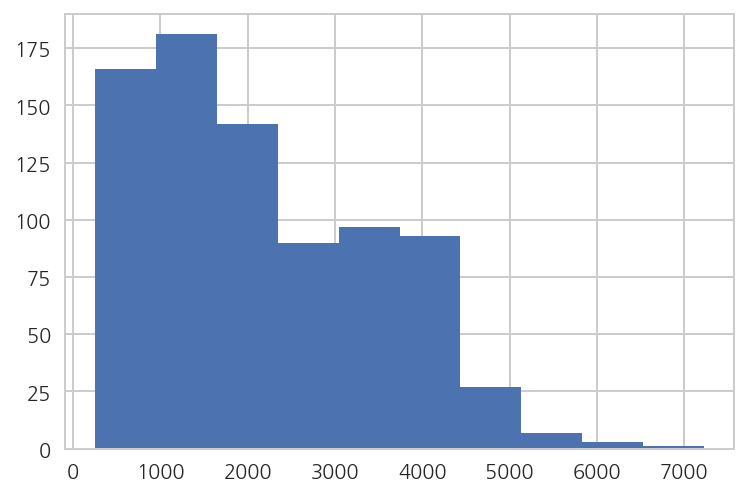

In [174]:
plt.hist(merged[merged['finishedsquarefeet6'].notnull()==True]['finishedsquarefeet6'])

##### (5)-5. finishedsquarefeet12
- Finished living area ((마감)완료된 생활 공간)

(array([1.25263e+05, 3.13550e+04, 2.36900e+03, 4.02000e+02, 8.90000e+01,
        2.40000e+01, 8.00000e+00, 4.00000e+00, 2.00000e+00, 3.00000e+00]),
 array([2.00000e+00, 2.19470e+03, 4.38740e+03, 6.58010e+03, 8.77280e+03,
        1.09655e+04, 1.31582e+04, 1.53509e+04, 1.75436e+04, 1.97363e+04,
        2.19290e+04]),
 <a list of 10 Patch objects>)

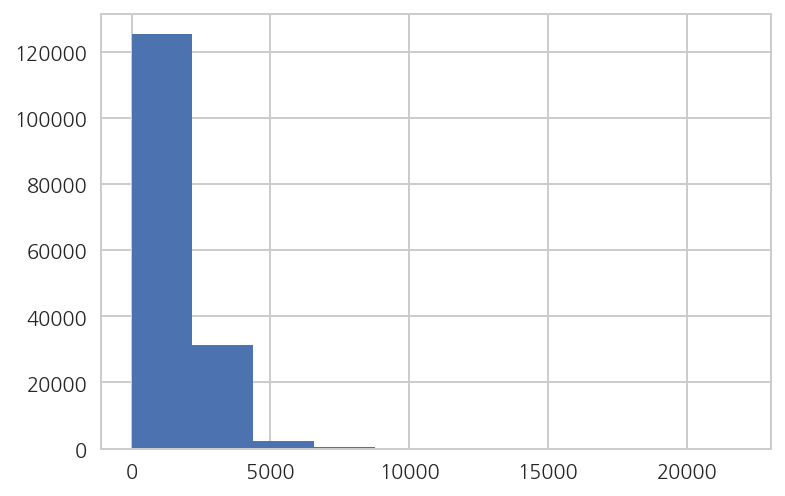

In [175]:
plt.hist(merged[merged['finishedsquarefeet12'].notnull()==True]['finishedsquarefeet12'])

##### (5)-6. finishedsquarefeet13
- Perimeter  living area

(array([ 3.,  3.,  1.,  5.,  1.,  9.,  5., 36.,  4.,  8.]),
 array([1056. , 1108.8, 1161.6, 1214.4, 1267.2, 1320. , 1372.8, 1425.6,
        1478.4, 1531.2, 1584. ]),
 <a list of 10 Patch objects>)

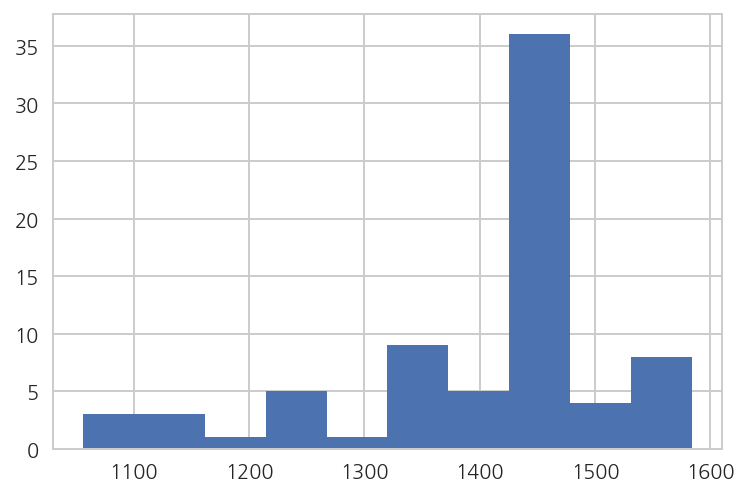

In [176]:
plt.hist(merged[merged['finishedsquarefeet13'].notnull()==True]['finishedsquarefeet13'])

##### (5)-7. finishedsquarefeet15
- Total area (총 면적)

(array([6.141e+03, 4.420e+02, 5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  560.,  4068.,  7576., 11084., 14592., 18100., 21608., 25116.,
        28624., 32132., 35640.]),
 <a list of 10 Patch objects>)

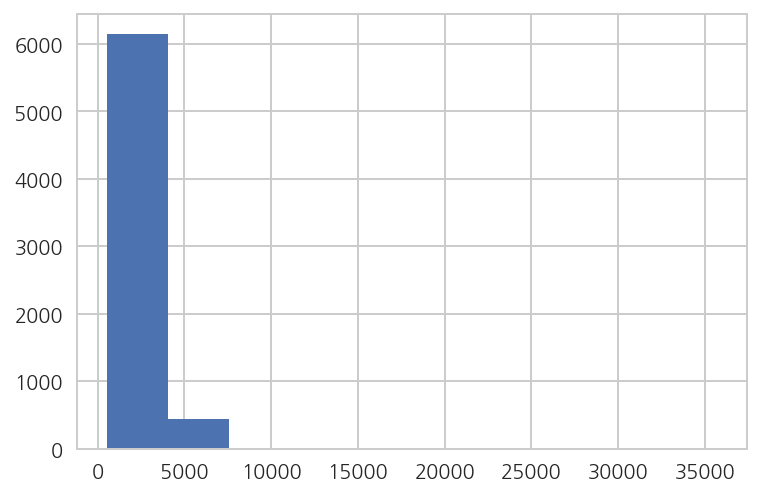

In [177]:
plt.hist(merged[merged['finishedsquarefeet15'].notnull()==True]['finishedsquarefeet15'])

##### (5)-8. finishedsquarefeet50
- Size of the finished living area on the first (entry) floor of the home (주택 1층 생활 공간의 규모)

(array([6.793e+03, 5.440e+03, 5.000e+02, 1.140e+02, 2.500e+01, 1.400e+01,
        5.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([   44. ,  1286.3,  2528.6,  3770.9,  5013.2,  6255.5,  7497.8,
         8740.1,  9982.4, 11224.7, 12467. ]),
 <a list of 10 Patch objects>)

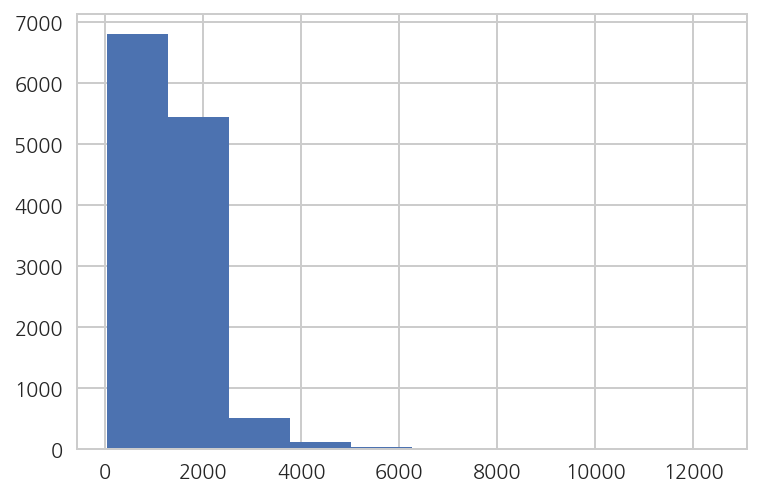

In [178]:
plt.hist(merged[merged['finishedsquarefeet50'].notnull()==True]['finishedsquarefeet50'])

##### (5)-9. yardbuildingsqft17
- Patio in  yard (마당의 파티오(보통 집 뒤쪽에 만드는 테라스))

(array([3.376e+03, 1.339e+03, 2.270e+02, 6.600e+01, 1.500e+01, 7.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 2.000e+00]),
 array([  11.,  329.,  647.,  965., 1283., 1601., 1919., 2237., 2555.,
        2873., 3191.]),
 <a list of 10 Patch objects>)

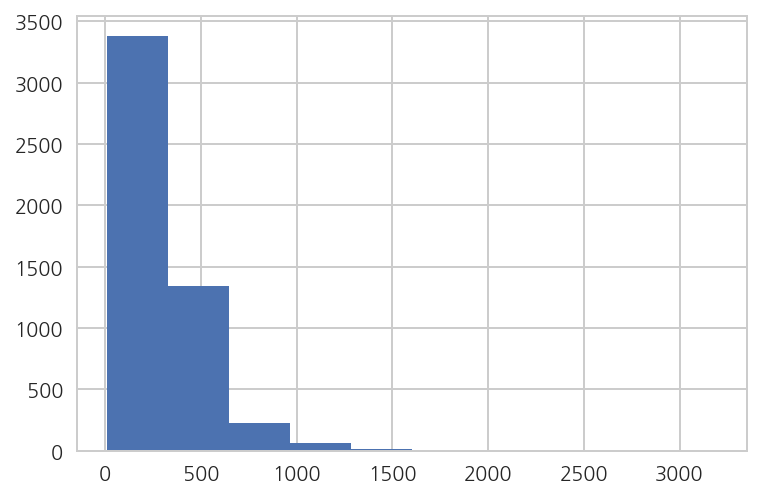

In [179]:
plt.hist(merged[merged['yardbuildingsqft17'].notnull()==True]['yardbuildingsqft17'])

##### (5)-10. yardbuildingsqft26
- Storage shed/building in yard (마당의 저장 창고)

(array([79., 35., 19., 11.,  6.,  1.,  4.,  3.,  5.,  2.]),
 array([  12. ,  147.4,  282.8,  418.2,  553.6,  689. ,  824.4,  959.8,
        1095.2, 1230.6, 1366. ]),
 <a list of 10 Patch objects>)

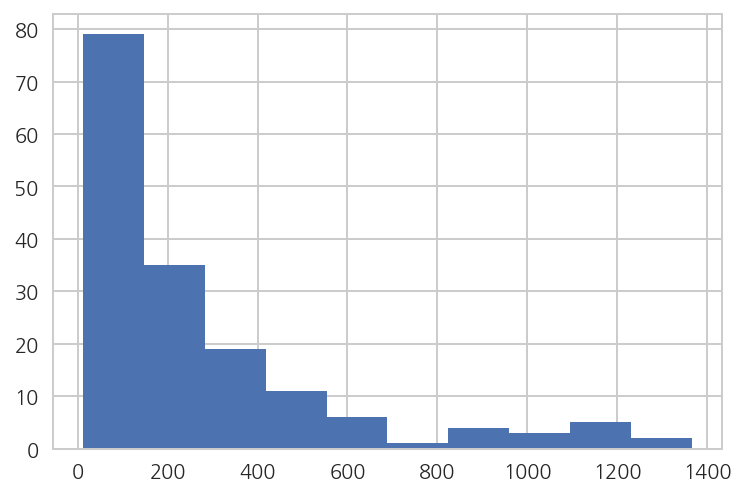

In [180]:
plt.hist(merged[merged['yardbuildingsqft26'].notnull()==True]['yardbuildingsqft26'])

##### (5)-11. garagecarcnt
- Total number of garages on the lot including an attached garage (부착된 차고를 포함한 부지의 총 차고 수)

(array([5.347e+04, 1.813e+03, 1.440e+02, 1.700e+01, 8.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

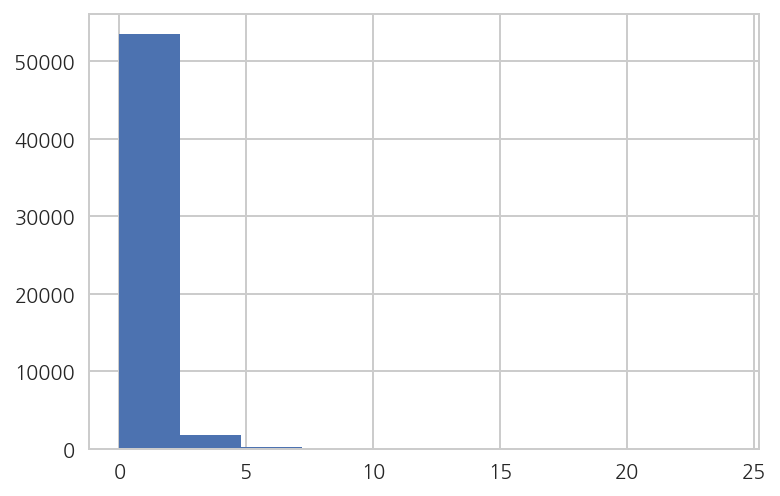

In [181]:
plt.hist(merged[merged['garagecarcnt'].notnull()==True]['garagecarcnt'])

##### (5)-12. garagetotalsqft
-  Total number of square feet of all garages on lot including an attached garage (부착된 차고를 포함하여 부지에있는 모든 차고의 총 평방 피트)

(array([5.3807e+04, 1.5670e+03, 5.4000e+01, 1.8000e+01, 6.0000e+00,
        4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,  733.9, 1467.8, 2201.7, 2935.6, 3669.5, 4403.4, 5137.3,
        5871.2, 6605.1, 7339. ]),
 <a list of 10 Patch objects>)

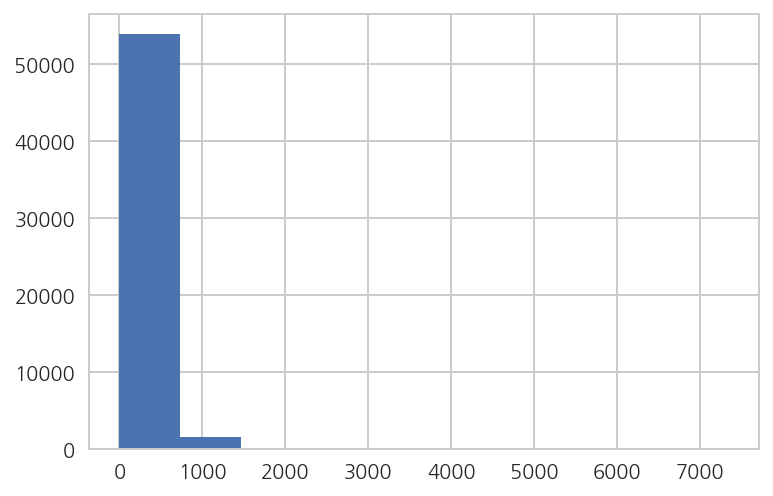

In [182]:
plt.hist(merged[merged['garagetotalsqft'].notnull()==True]['garagetotalsqft'])

##### (5)-13. lotsizesquarefeet
- Area of the lot in square feet (부지의 평방 피트 면적)

(array([1.48831e+05, 4.97000e+02, 7.50000e+01, 3.00000e+00, 1.00000e+00,
        2.40000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.50000e+01]),
 array([1.6700000e+02, 6.9725130e+05, 1.3943356e+06, 2.0914199e+06,
        2.7885042e+06, 3.4855885e+06, 4.1826728e+06, 4.8797571e+06,
        5.5768414e+06, 6.2739257e+06, 6.9710100e+06]),
 <a list of 10 Patch objects>)

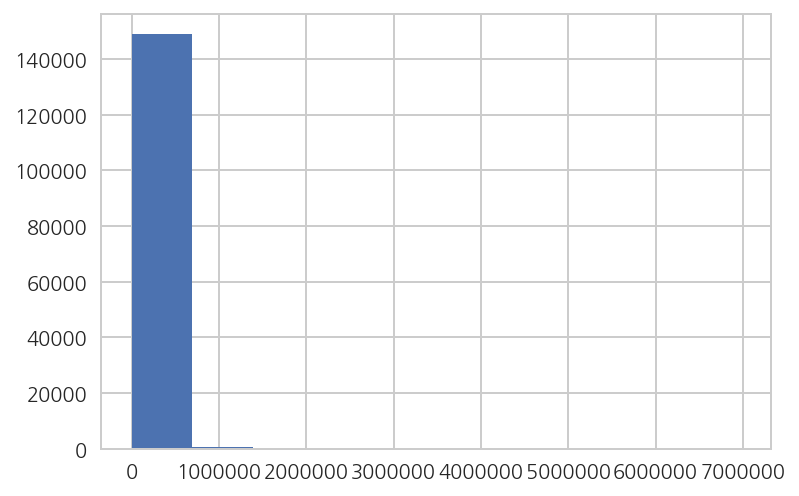

In [183]:
plt.hist(merged[merged['lotsizesquarefeet'].notnull()==True]['lotsizesquarefeet'])

##### 6) tax와 관련된 변수들 (total 7)
- taxvaluedollarcnt
- structuretaxvaluedollarcnt
- landtaxvaluedollarcnt
- taxamount
- assessmentyear
- taxdelinquencyflag
- taxdelinquencyyear

In [75]:
merged_des.loc[["taxvaluedollarcnt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt","taxamount",
                "assessmentyear", "taxdelinquencyflag", "taxdelinquencyyear"],:]

count unique     top   freq first last     mean  \
taxvaluedollarcnt           167852    NaN     NaN    NaN   NaN  NaN   472683   
structuretaxvaluedollarcnt  167359    NaN     NaN    NaN   NaN  NaN   184346   
landtaxvaluedollarcnt       167851    NaN     NaN    NaN   NaN  NaN   288880   
taxamount                   167843    NaN     NaN    NaN   NaN  NaN  5989.52   
assessmentyear              167854      2  2015.0  90275   NaN  NaN      NaN   
taxdelinquencyflag            4683    NaN     NaN    NaN   NaN  NaN        1   
taxdelinquencyyear            4683     13    15.0   2078   NaN  NaN      NaN   

                                std    min      25%      50%      75%  \
taxvaluedollarcnt            602837     22   202652   350000   554002   
structuretaxvaluedollarcnt   219284     44    82568   134051   214257   
landtaxvaluedollarcnt        445645     22    83730   197776   355334   
taxamount                   7214.73  19.92  2798.07  4501.04  6914.16   
assessmentyear                  NaN    NaN      NaN      NaN      NaN   
taxdelinquencyflag                0      1        1        1        1   
taxdelinquencyyear              NaN    NaN      NaN      NaN      NaN   

                                    max missing_ratio    dtype  
taxvaluedollarcnt           4.90612e+07   0.000214429  float64  
structuretaxvaluedollarcnt  1.14218e+07    0.00315091  float64  
landtaxvaluedollarcnt       4.89522e+07   0.000220385  float64  
taxamount                        586639   0.000268036  float64  
assessmentyear                      NaN   0.000202516   object  
taxdelinquencyflag                    1      0.972106  float64  
taxdelinquencyyear                  NaN      0.972106   object

##### (6)-1. taxvaluedollarcnt
- The total tax assessed value of the parcel (토지(땅의 구획)의 총 세금 평가 가치)

(array([1.67448e+05, 3.38000e+02, 4.70000e+01, 9.00000e+00, 5.00000e+00,
        4.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([2.20000000e+01, 4.90614340e+06, 9.81226480e+06, 1.47183862e+07,
        1.96245076e+07, 2.45306290e+07, 2.94367504e+07, 3.43428718e+07,
        3.92489932e+07, 4.41551146e+07, 4.90612360e+07]),
 <a list of 10 Patch objects>)

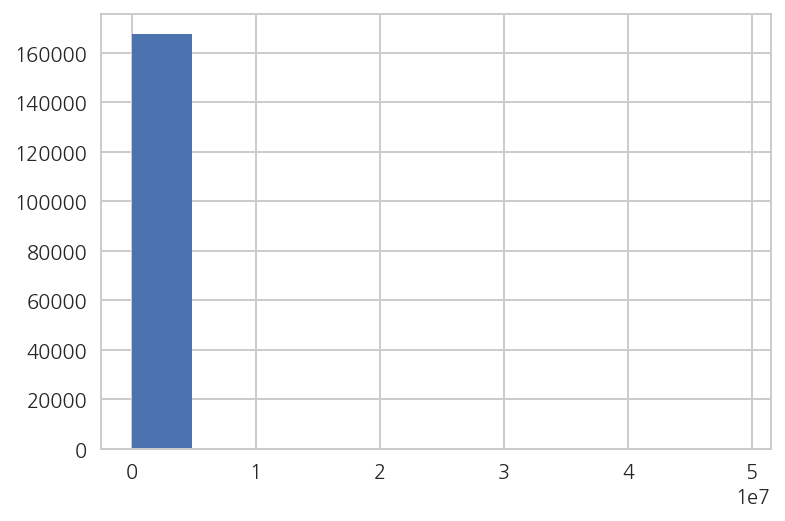

In [186]:
plt.hist(merged[merged['taxvaluedollarcnt'].notnull()==True]['taxvaluedollarcnt'])

##### (6)-2. structuretaxvaluedollarcnt
- The assessed value of the built structure on the parcel (건설된 구조물에 대한 토지(땅의 구획)의 평가 값)

(array([1.66173e+05, 9.73000e+02, 1.41000e+02, 3.70000e+01, 1.90000e+01,
        5.00000e+00, 8.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([4.40000000e+01, 1.14221860e+06, 2.28439320e+06, 3.42656780e+06,
        4.56874240e+06, 5.71091700e+06, 6.85309160e+06, 7.99526620e+06,
        9.13744080e+06, 1.02796154e+07, 1.14217900e+07]),
 <a list of 10 Patch objects>)

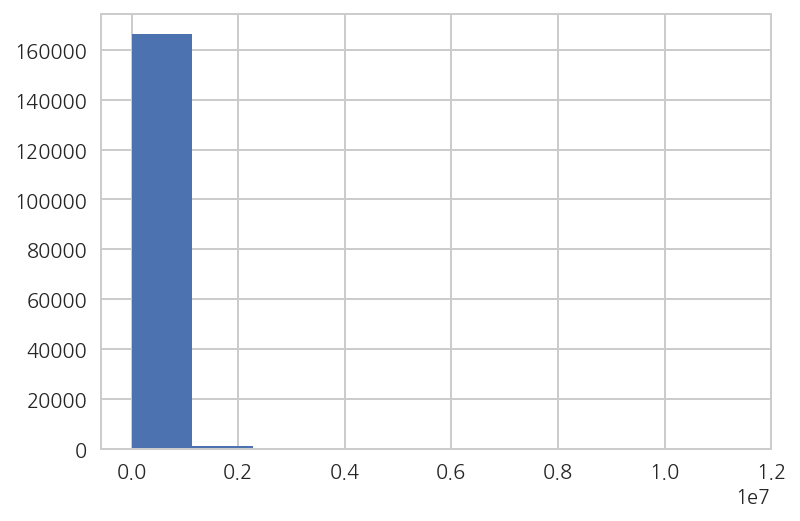

In [187]:
plt.hist(merged[merged['structuretaxvaluedollarcnt'].notnull()==True]['structuretaxvaluedollarcnt'])

##### (6)-3. landtaxvaluedollarcnt
- The assessed value of the land area of the parcel (토지(땅의 구획)의 토지 면적에 대한 평가 값)

(array([1.6767e+05, 1.4800e+02, 2.2000e+01, 8.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.20000000e+01, 4.89523960e+06, 9.79045720e+06, 1.46856748e+07,
        1.95808924e+07, 2.44761100e+07, 2.93713276e+07, 3.42665452e+07,
        3.91617628e+07, 4.40569804e+07, 4.89521980e+07]),
 <a list of 10 Patch objects>)

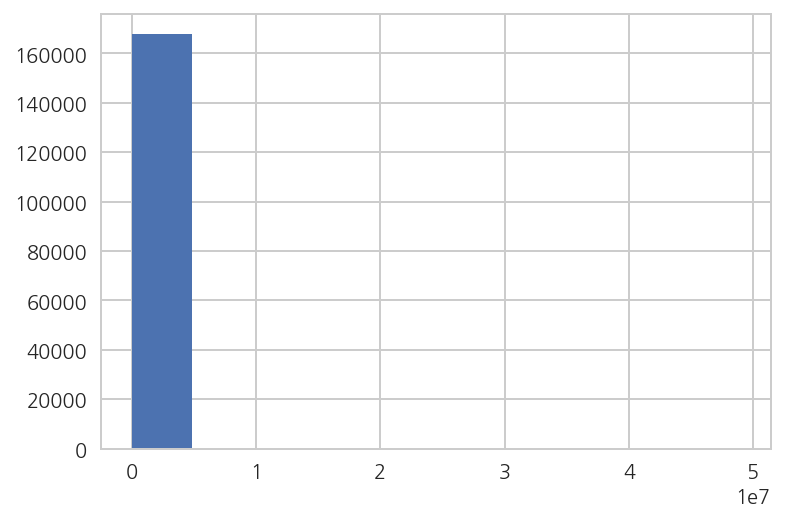

In [188]:
plt.hist(merged[merged['landtaxvaluedollarcnt'].notnull()==True]['landtaxvaluedollarcnt'])

##### (6)-4. taxamount
- The total property tax assessed for that assessment year (해당 과세 연도에 대해 평가된 총 재산세)

(array([1.67441e+05, 3.37000e+02, 4.50000e+01, 1.00000e+01, 6.00000e+00,
        3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.99200000e+01, 5.86818580e+04, 1.17343796e+05, 1.76005734e+05,
        2.34667672e+05, 2.93329610e+05, 3.51991548e+05, 4.10653486e+05,
        4.69315424e+05, 5.27977362e+05, 5.86639300e+05]),
 <a list of 10 Patch objects>)

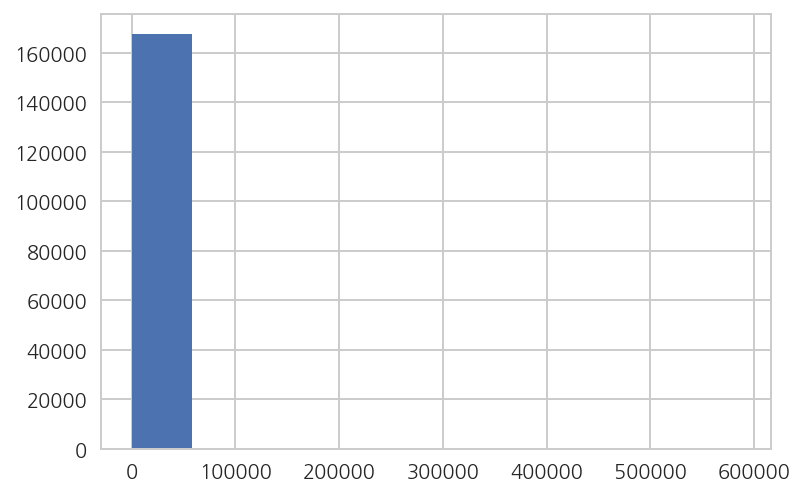

In [189]:
plt.hist(merged[merged['taxamount'].notnull()==True]['taxamount'])

##### (6)-5. assessmentyear
- The year of the property tax assessment (재산세 평가 년도)

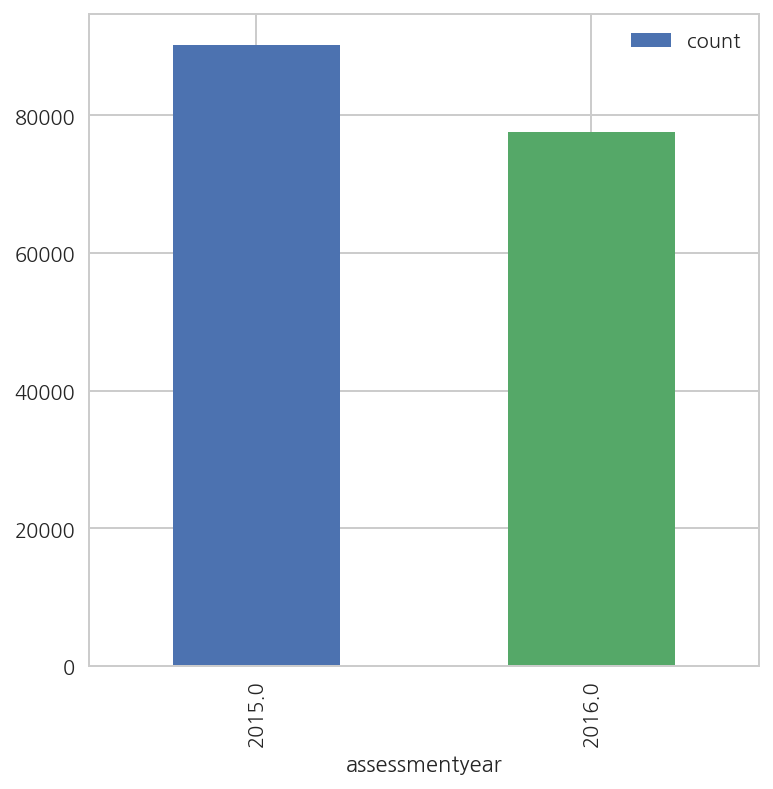

In [191]:
merged.groupby("assessmentyear").size().reset_index(name='count')\
.plot(x = 'assessmentyear', y = 'count', kind = 'bar', figsize=(6, 6))
plt.show()

##### (6)-6.  & taxdelinquencyyear & taxdelinquencyyear
- taxdelinquencyflag: 재산세 미납 여부 → NaN값은 미납되지 않았다고 간주, 0으로 imputation
- taxdelinquencyyear: Year for which the unpaid propert taxes were due (미납 된 재산세 (예정이었던) 납부시기)

In [151]:
merged['taxdelinquencyflag'].value_counts().reset_index()

index  taxdelinquencyflag
0     Y                4683

In [160]:
merged['taxdelinquencyyear'].value_counts().reset_index()

index  taxdelinquencyyear
0    15.0                2078
1    14.0                1429
2    13.0                 397
3    12.0                 267
4    11.0                 183
5    10.0                 155
6     9.0                 110
7     8.0                  38
8     7.0                  18
9     6.0                   4
10   99.0                   2
11    4.0                   1
12    3.0                   1

In [39]:
merged["taxdelinquencyyear_past"] = merged["transaction_year"] - merged["taxdelinquencyyear"]
merged['taxdelinquencyyear_past'].value_counts().reset_index()

index  taxdelinquencyyear_past
0     2.0                     2188
1     3.0                     1011
2     1.0                      518
3     4.0                      341
4     5.0                      198
5     6.0                      187
6     7.0                      129
7     8.0                       71
8     9.0                       22
9    10.0                       13
10   13.0                        1
11   11.0                        1
12   14.0                        1
13   17.0                        1
14   18.0                        1

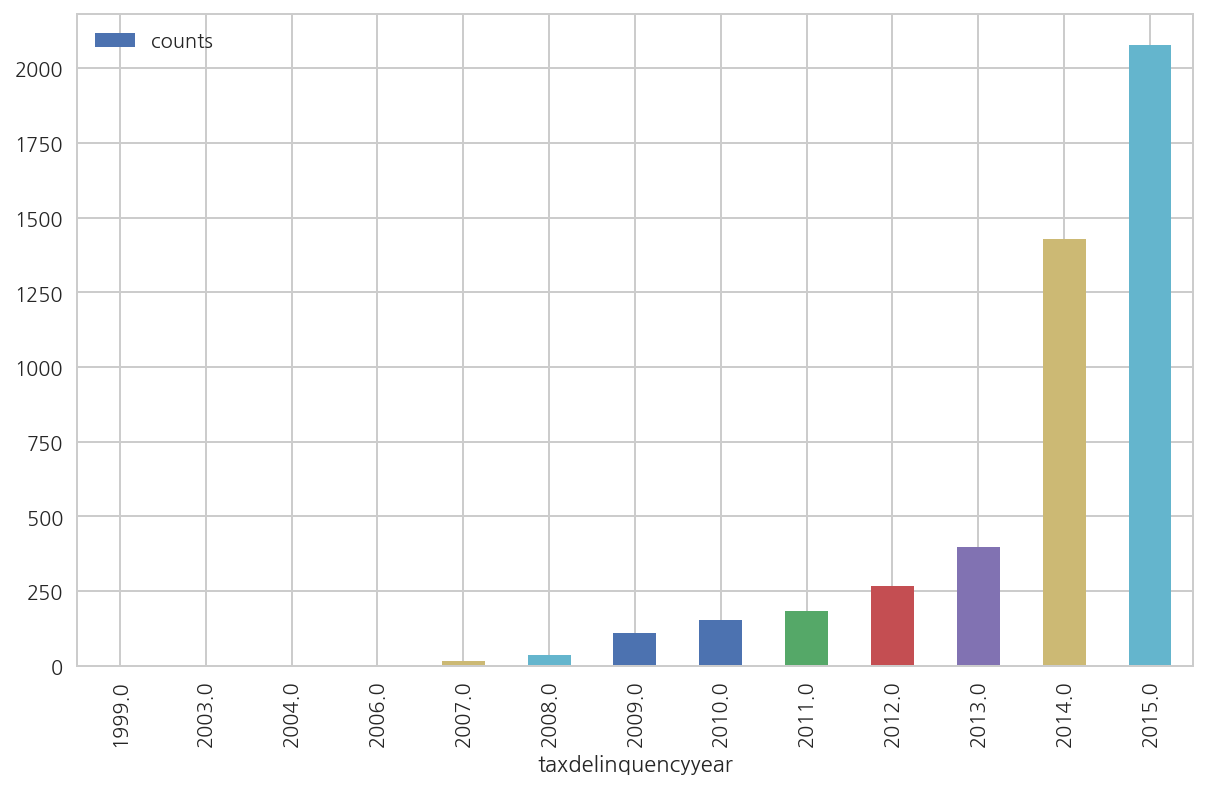

In [40]:
taxdelinquencyyear = pd.DataFrame(merged["taxdelinquencyyear"])
taxdelinquencyyear = taxdelinquencyyear.groupby("taxdelinquencyyear").size().reset_index(name='counts')
taxdelinquencyyear.plot(x = 'taxdelinquencyyear', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

### 2.4 Relationship between Logerror and variables

In [ ]:
    4. 집의 구조, 면적 등에 관련된 변수 (실수 변수 / 카테고리 변수)
    5. 세금과 관련된 변수 (실수 변수 / 카테고리 변수)  

#### **1) 집의 지리정보와 관련된 변수**
- numerical variable: latitude, longitude
- categorical variable: fips, census_3, census_4, raw_census_3, raw_census_4, regionidcounty, regionidcity, regionidzip, regionidneighborhood

##### 위도 경도와 logerror

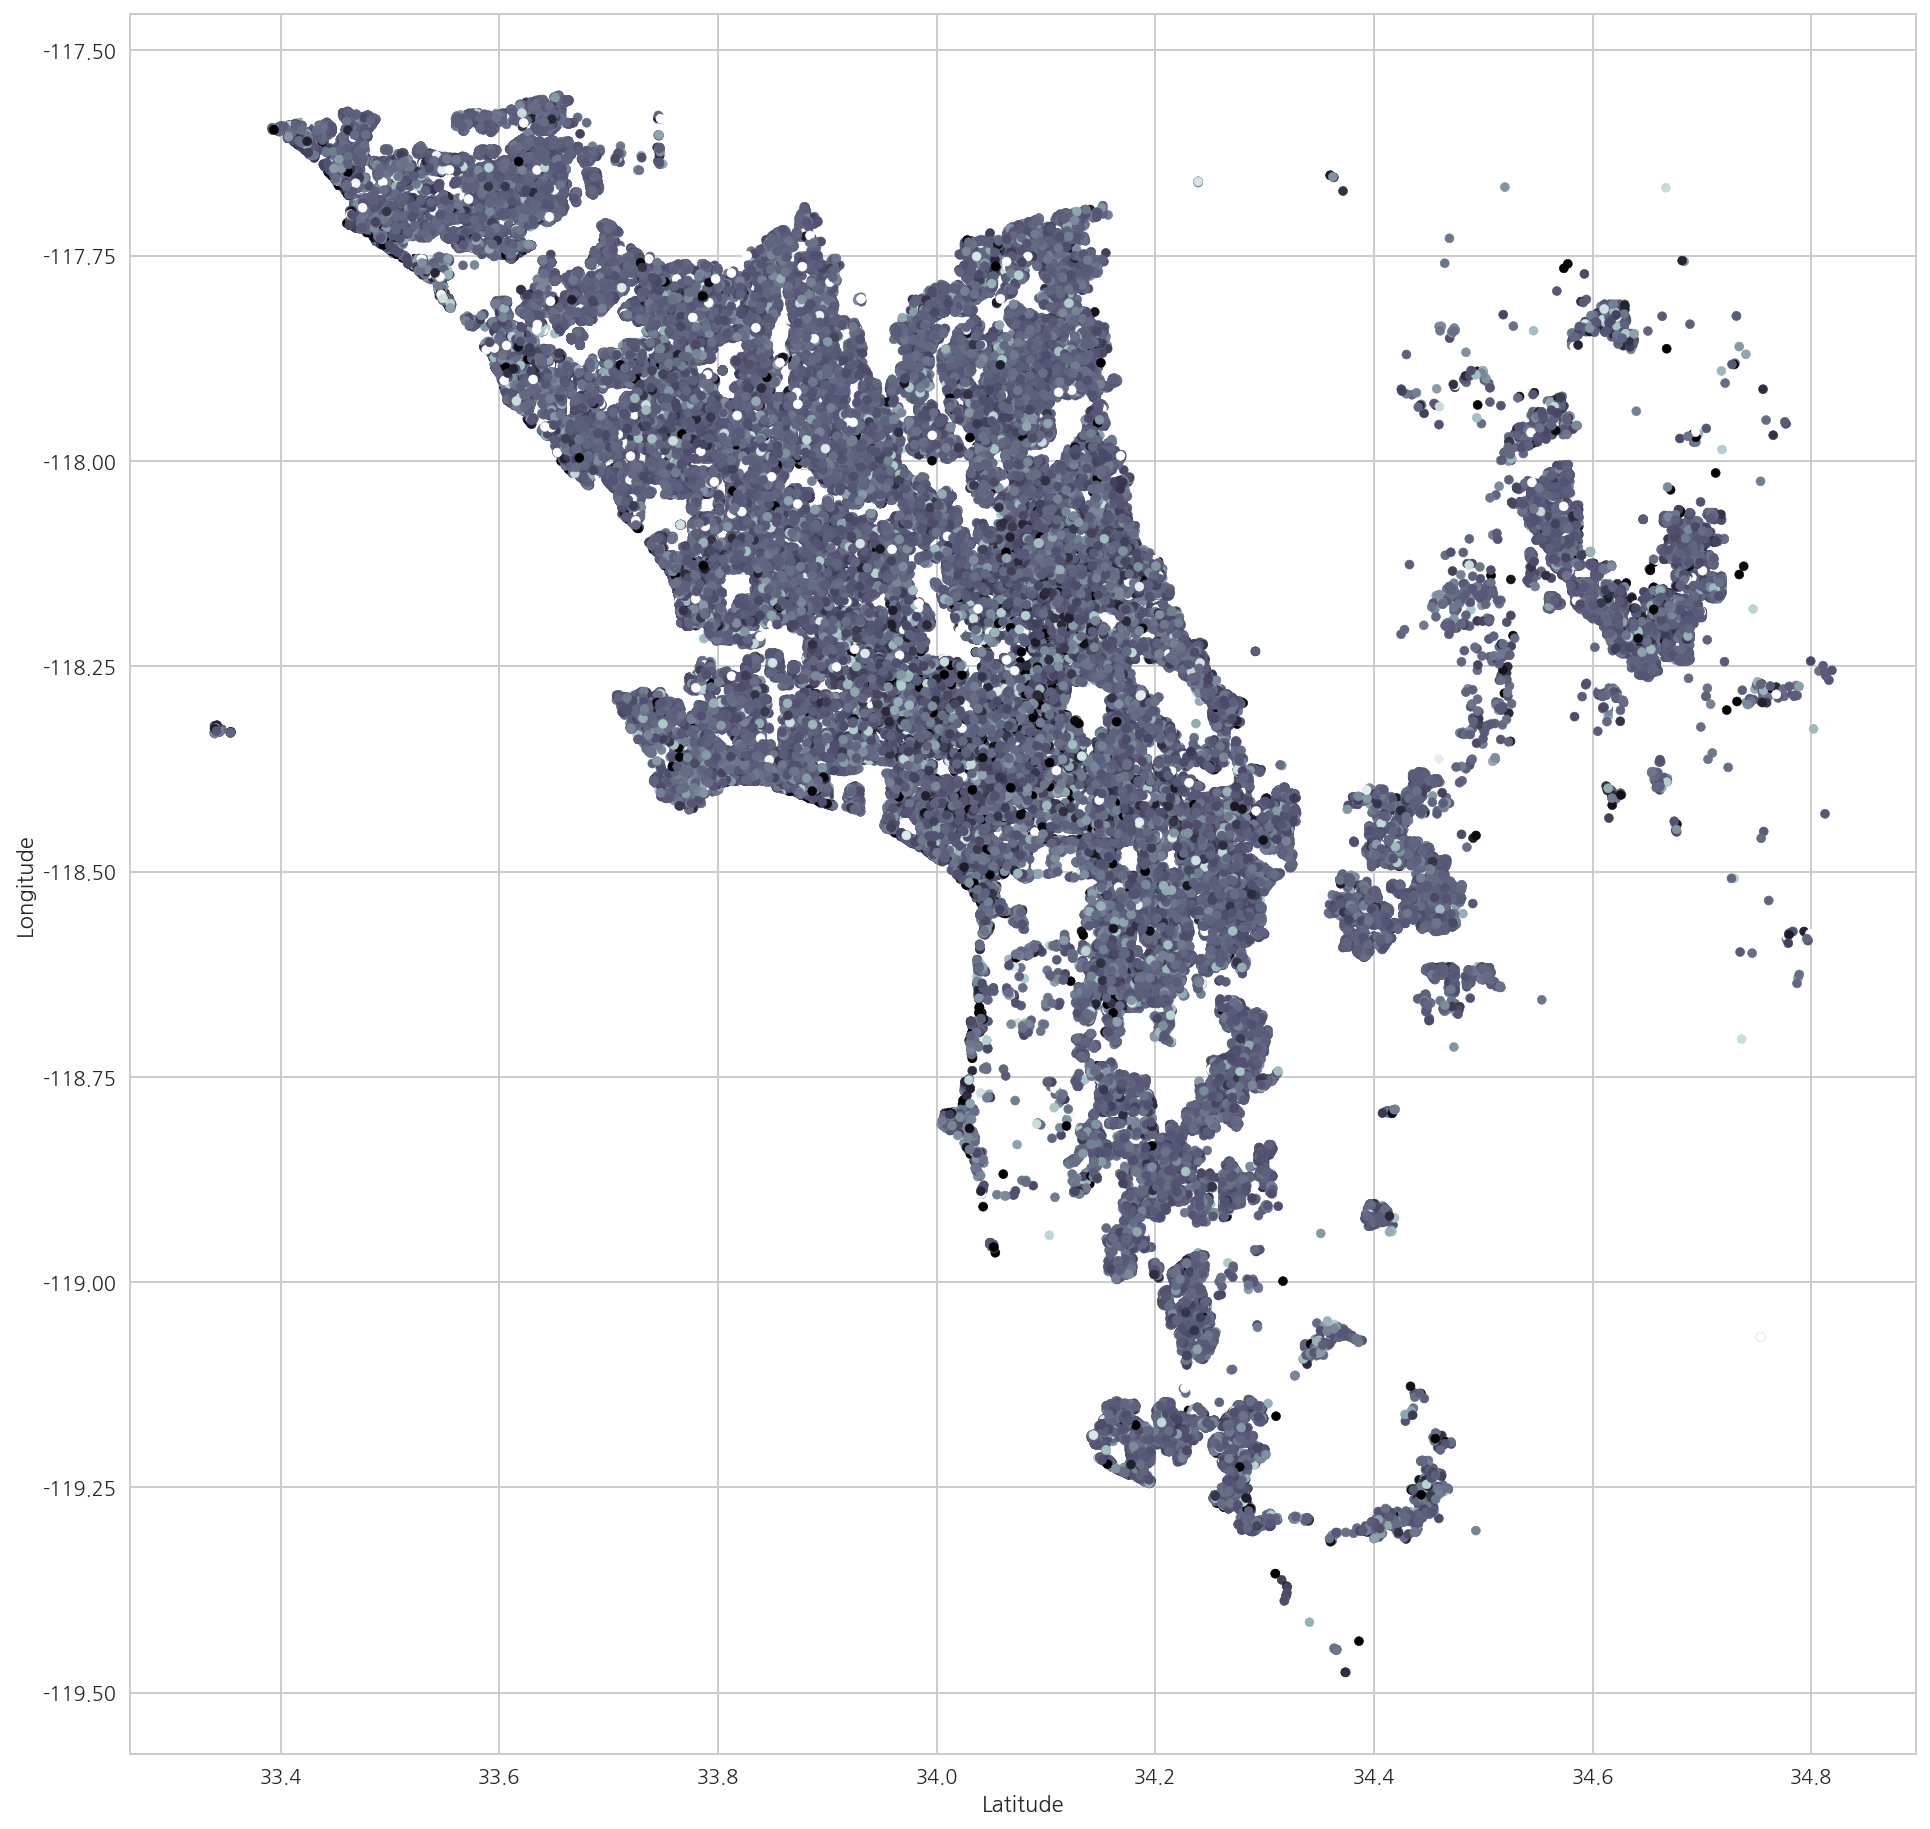

In [39]:
# 위도 경도에 따른 logerror: logerror가 크면 밝은 색, 작으면 어두운 색
plt.figure(figsize=(16,16))
plt.scatter(x=merged.latitude.values, y=merged.longitude.values, c=merged.logerror.values, cmap=mpl.cm.bone, s=20)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

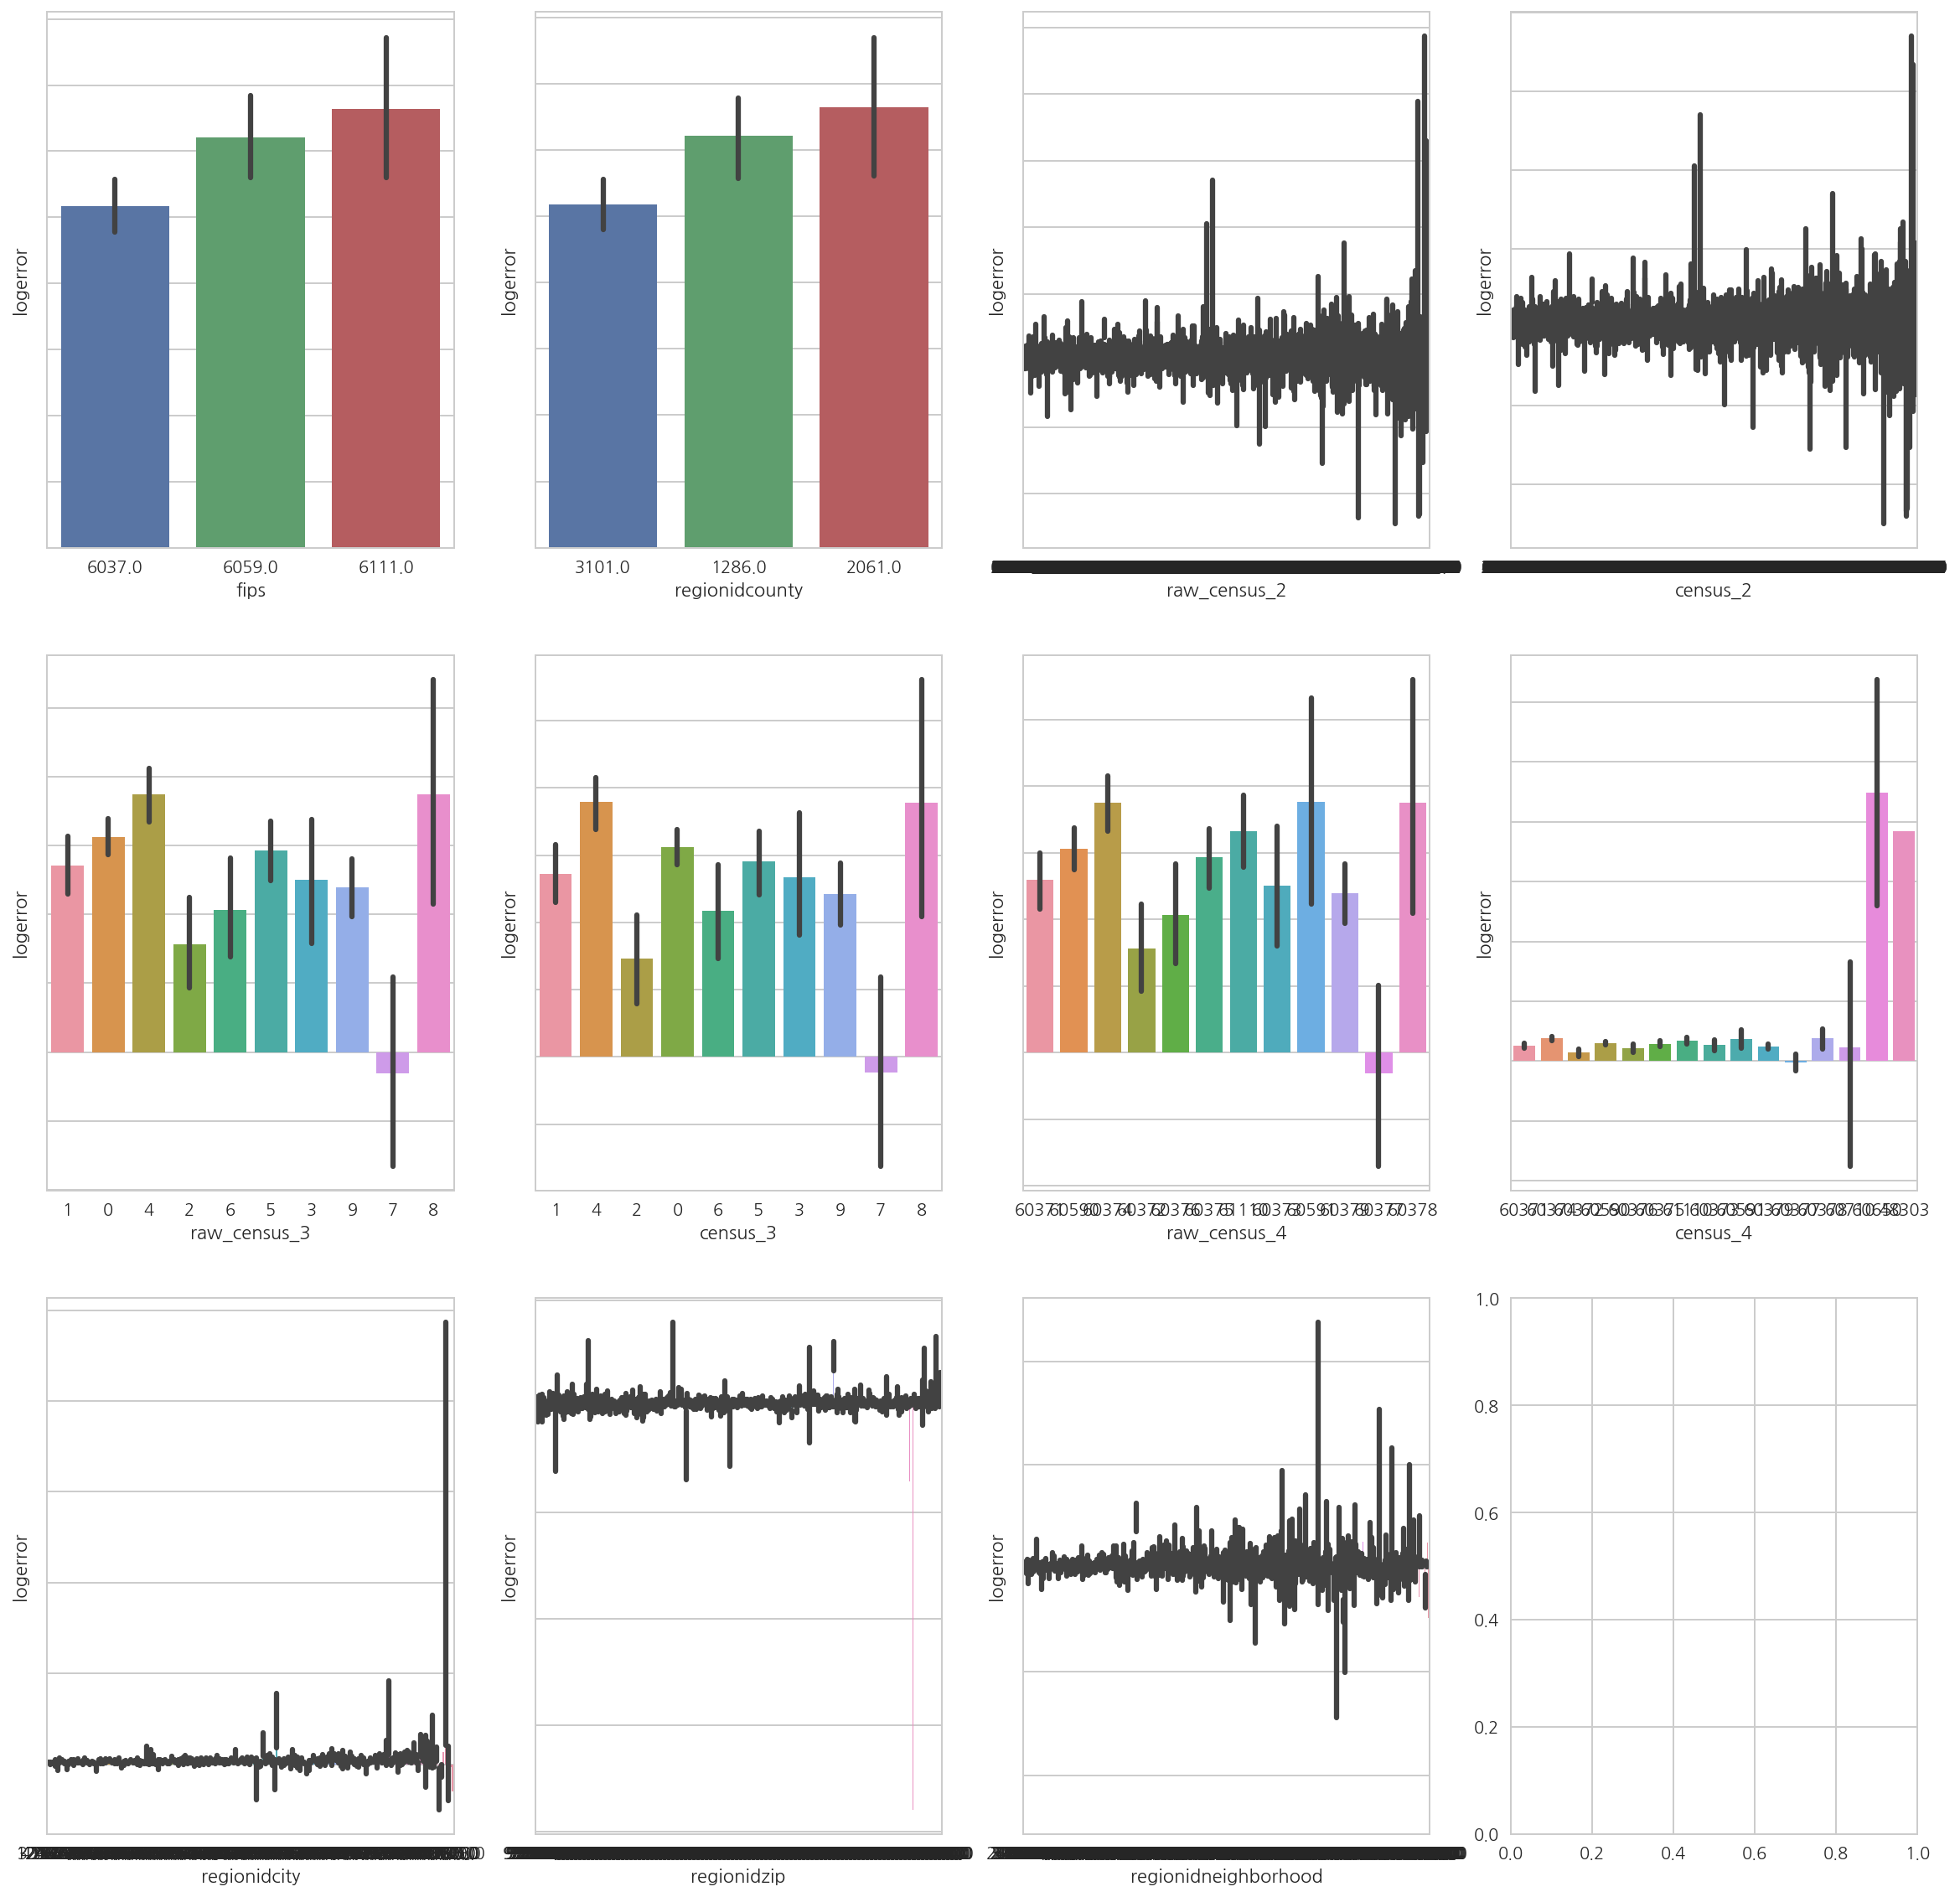

In [140]:
geo_cat = ["fips", "regionidcounty", "raw_census_2", "census_2",
           "raw_census_3", "census_3", "raw_census_4", "census_4",
           "regionidcity", "regionidzip", "regionidneighborhood"]

fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(geo_cat):
    sns.barplot(x = n, y='logerror', data = merged, ax = ax[idx//4, idx % 4])
    ax[idx// 4, idx % 4].set(yticklabels=[])
    
    continue

#### **2) 건물 특징, 타입 등에 대한 변수**

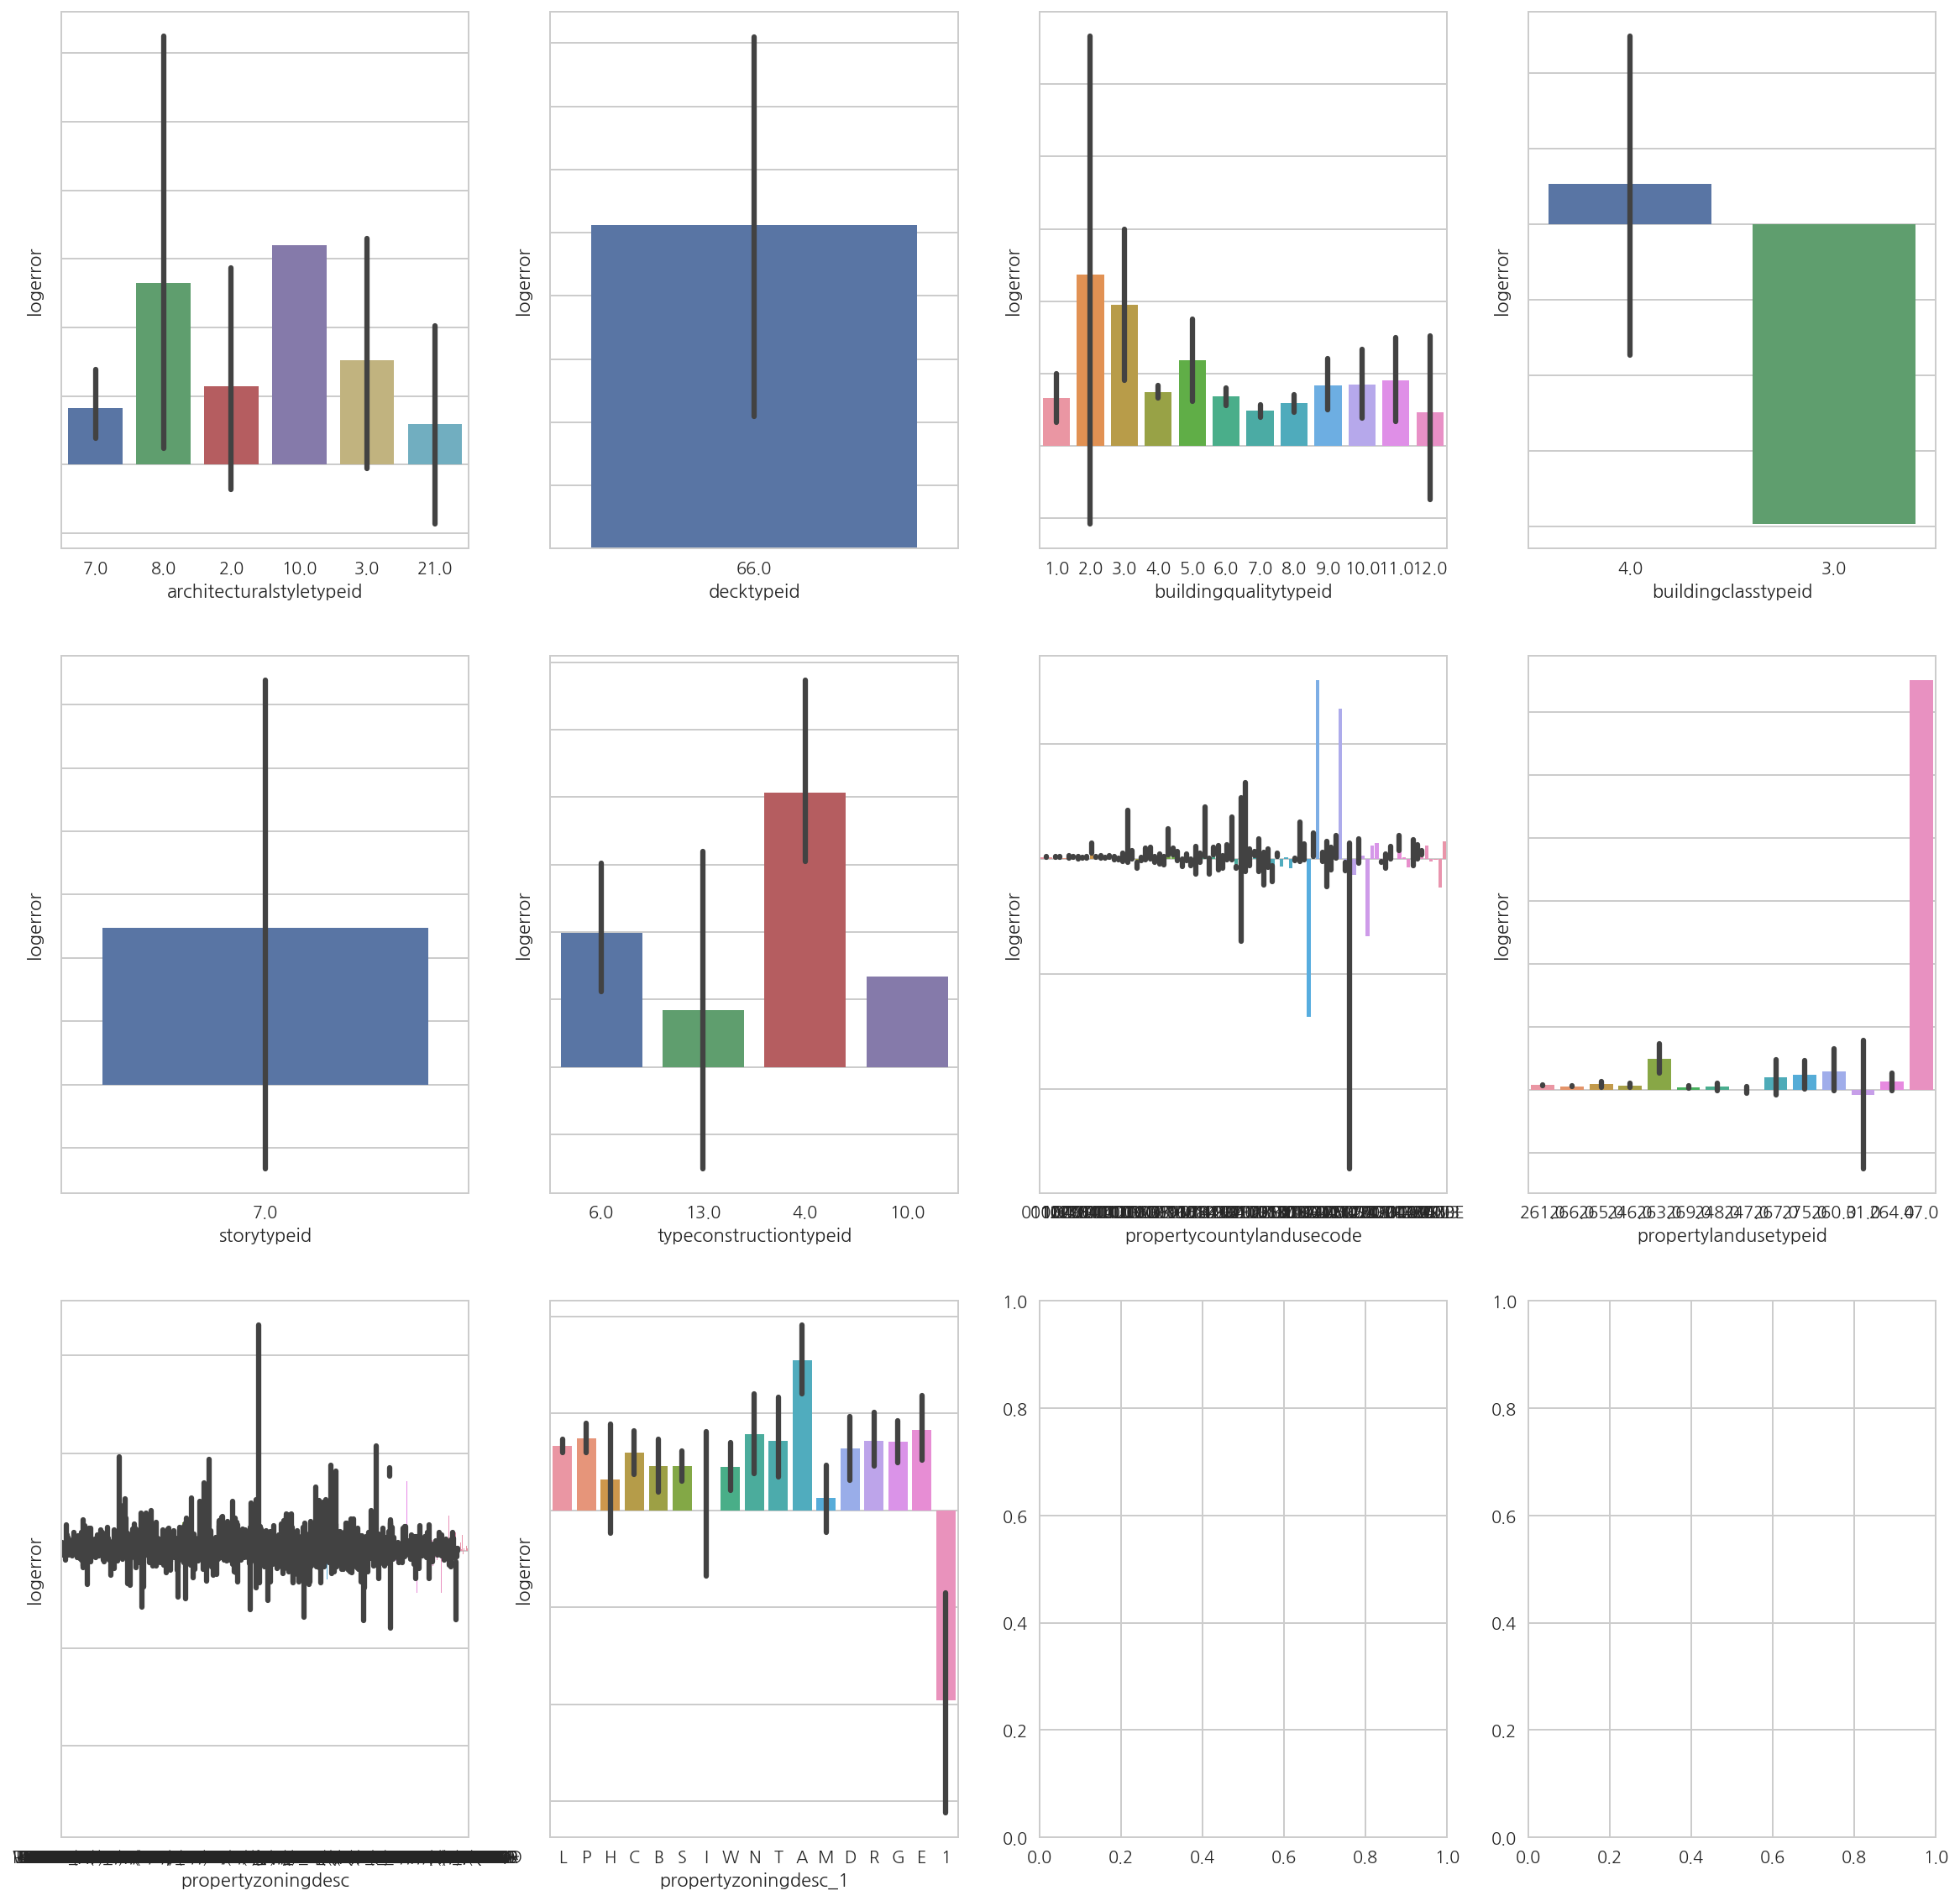

In [69]:
bdg_cat =  ["architecturalstyletypeid", "decktypeid", "buildingqualitytypeid", "buildingclasstypeid", 
            "storytypeid", "typeconstructiontypeid", "propertycountylandusecode", "propertylandusetypeid",
            "propertyzoningdesc", "propertyzoningdesc_1", "propertyzoningdesc_3"]

fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(bdg_cat):
    sns.barplot(x = n, y='logerror', data = merged, ax = ax[idx // 4, idx % 4])
    ax[idx // 4, idx % 4].set(yticklabels=[])
    
    continue

#### **3) 집의 구조, 면적 등에 관련된 변수 **

##### **(1) 집의 면적에 대한 변수**

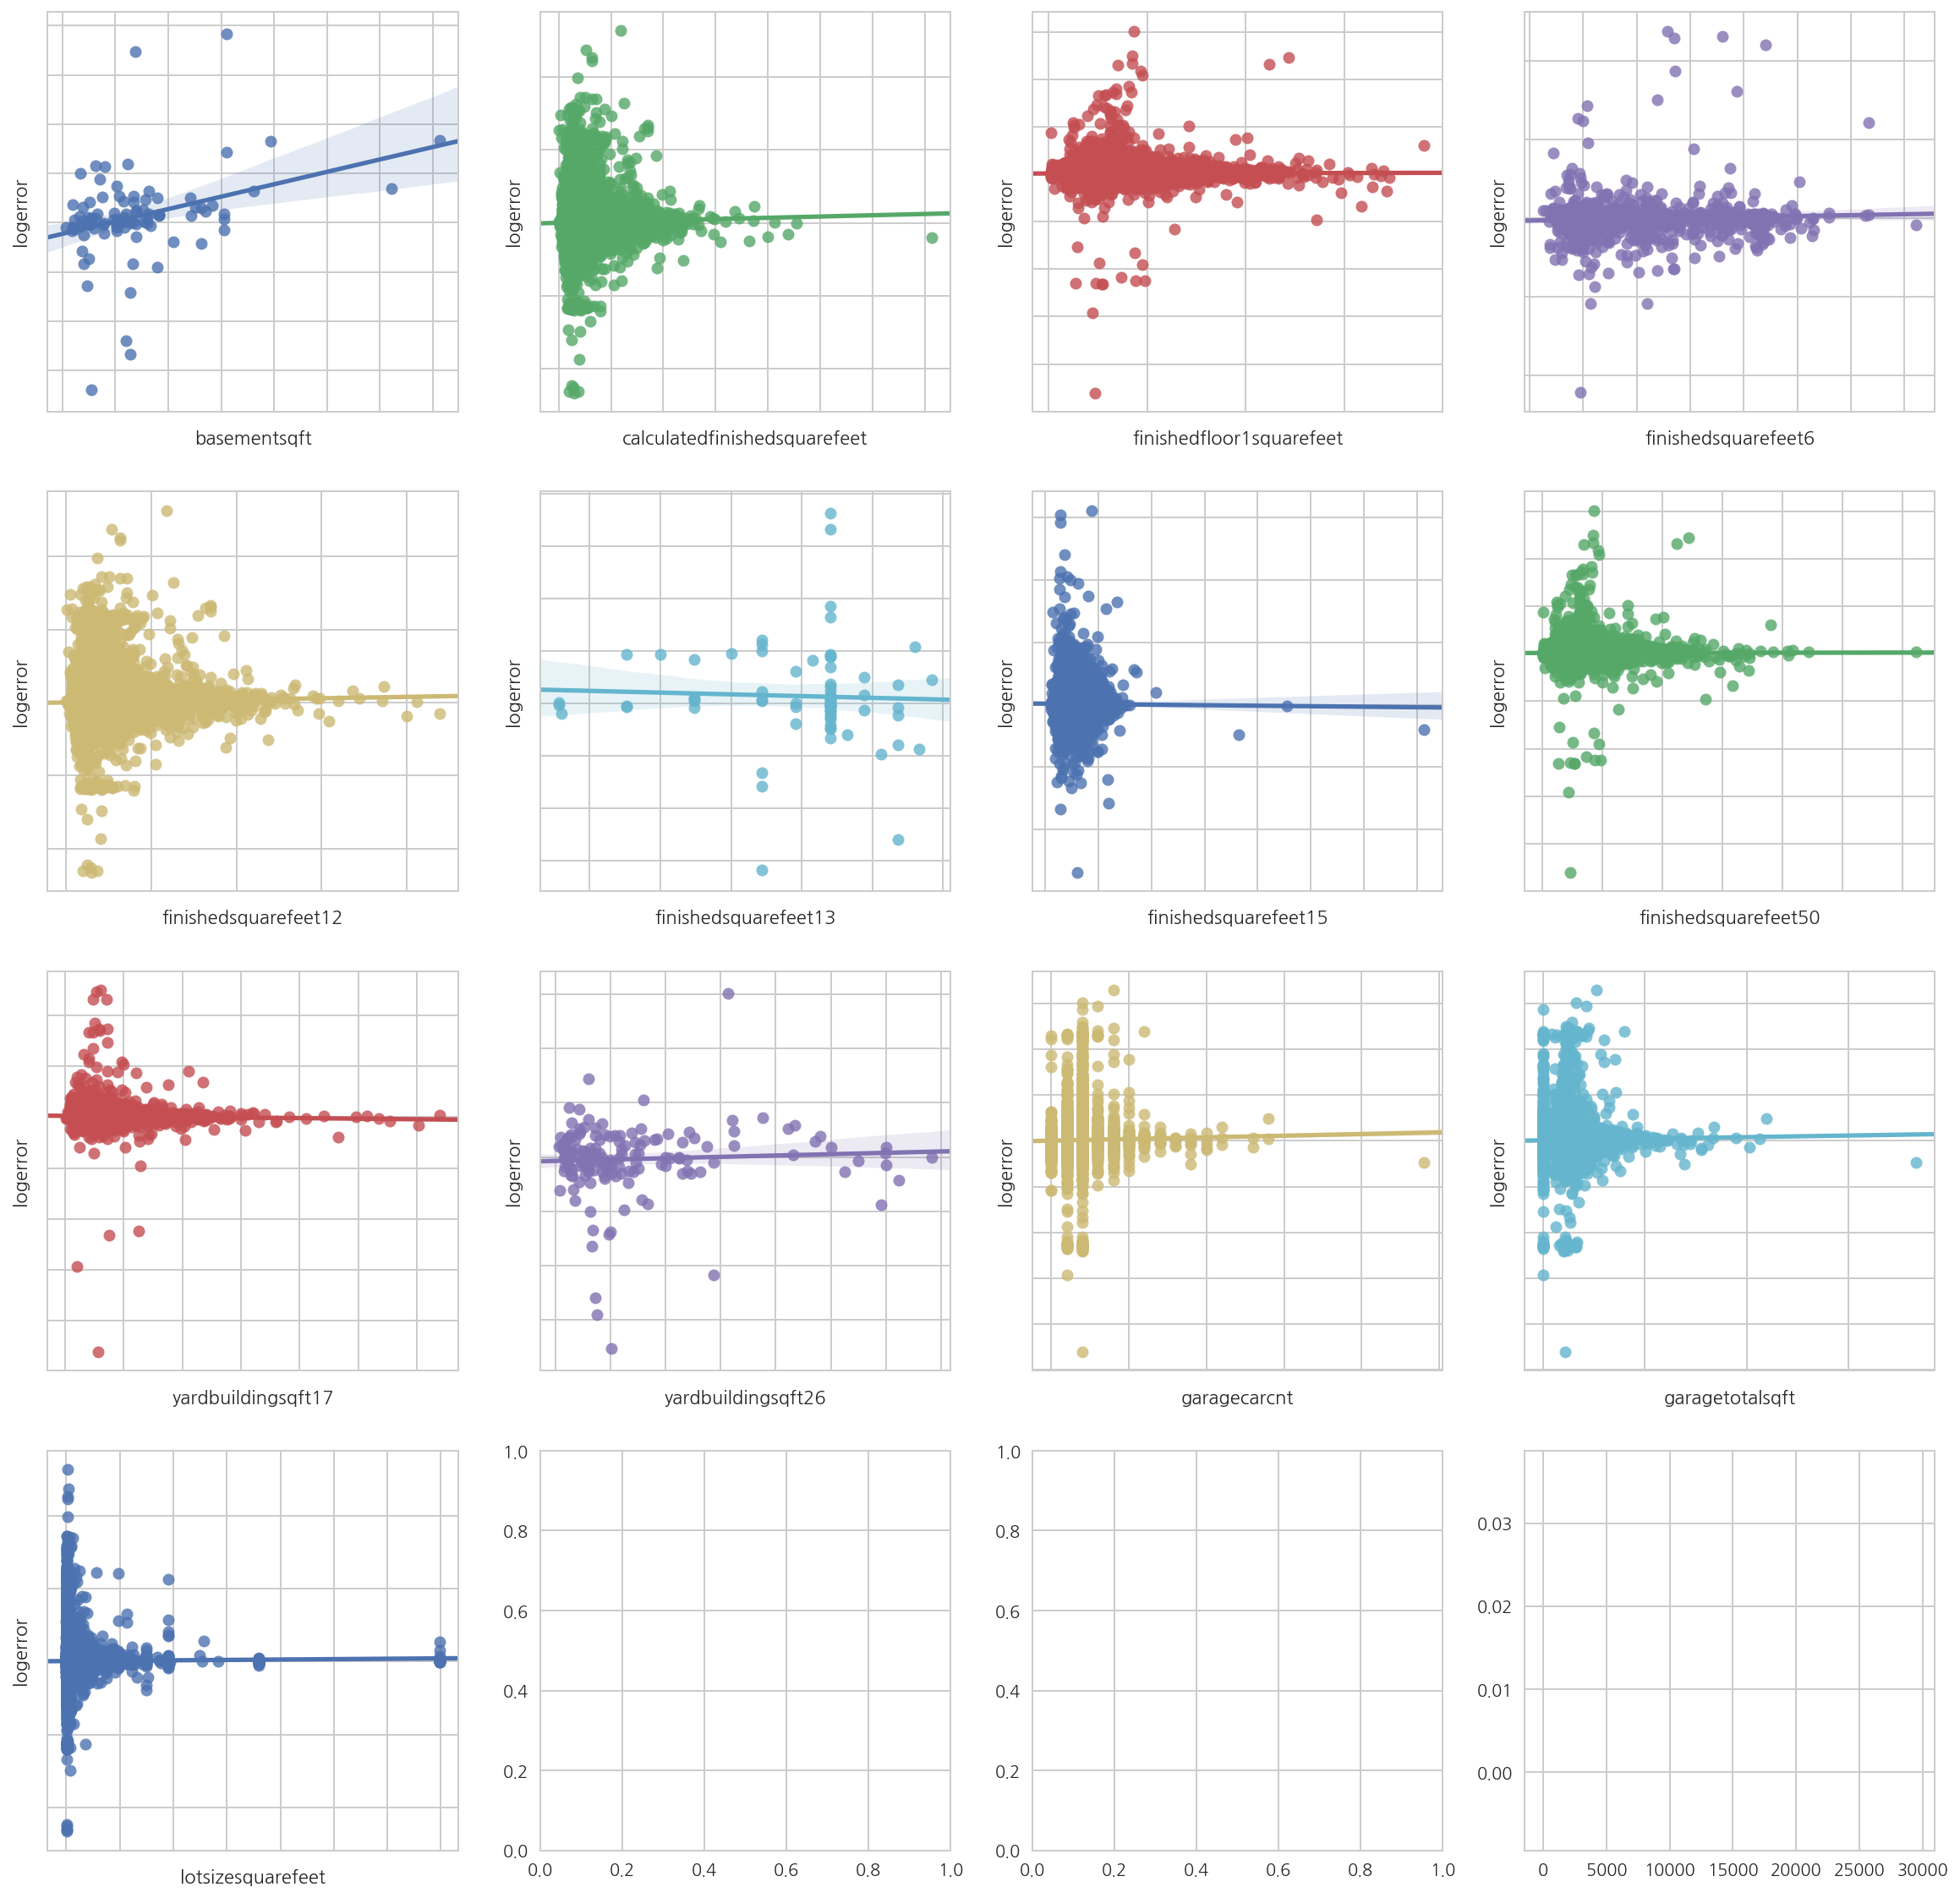

In [256]:
sqft_vars = ["basementsqft", "calculatedfinishedsquarefeet", "finishedfloor1squarefeet", "finishedsquarefeet6",
           "finishedsquarefeet12", "finishedsquarefeet13", "finishedsquarefeet15", "finishedsquarefeet50", "yardbuildingsqft17",
           "yardbuildingsqft26", "garagecarcnt", "garagetotalsqft", "lotsizesquarefeet"]

fig, ax = plt.subplots(4,4, figsize = (20,20))

for idx, n in enumerate(sqft_vars):
    if n == 'logerror':
        continue
    sns.regplot(x=n, y='logerror', data=merged, ax = ax[idx//4,idx%4])
    ax[idx//4, idx%4].set(yticklabels=[])
    ax[idx//4, idx%4].set(xticklabels=[])
    continue

##### (2) 집의 구조에 관련된 실수 변수

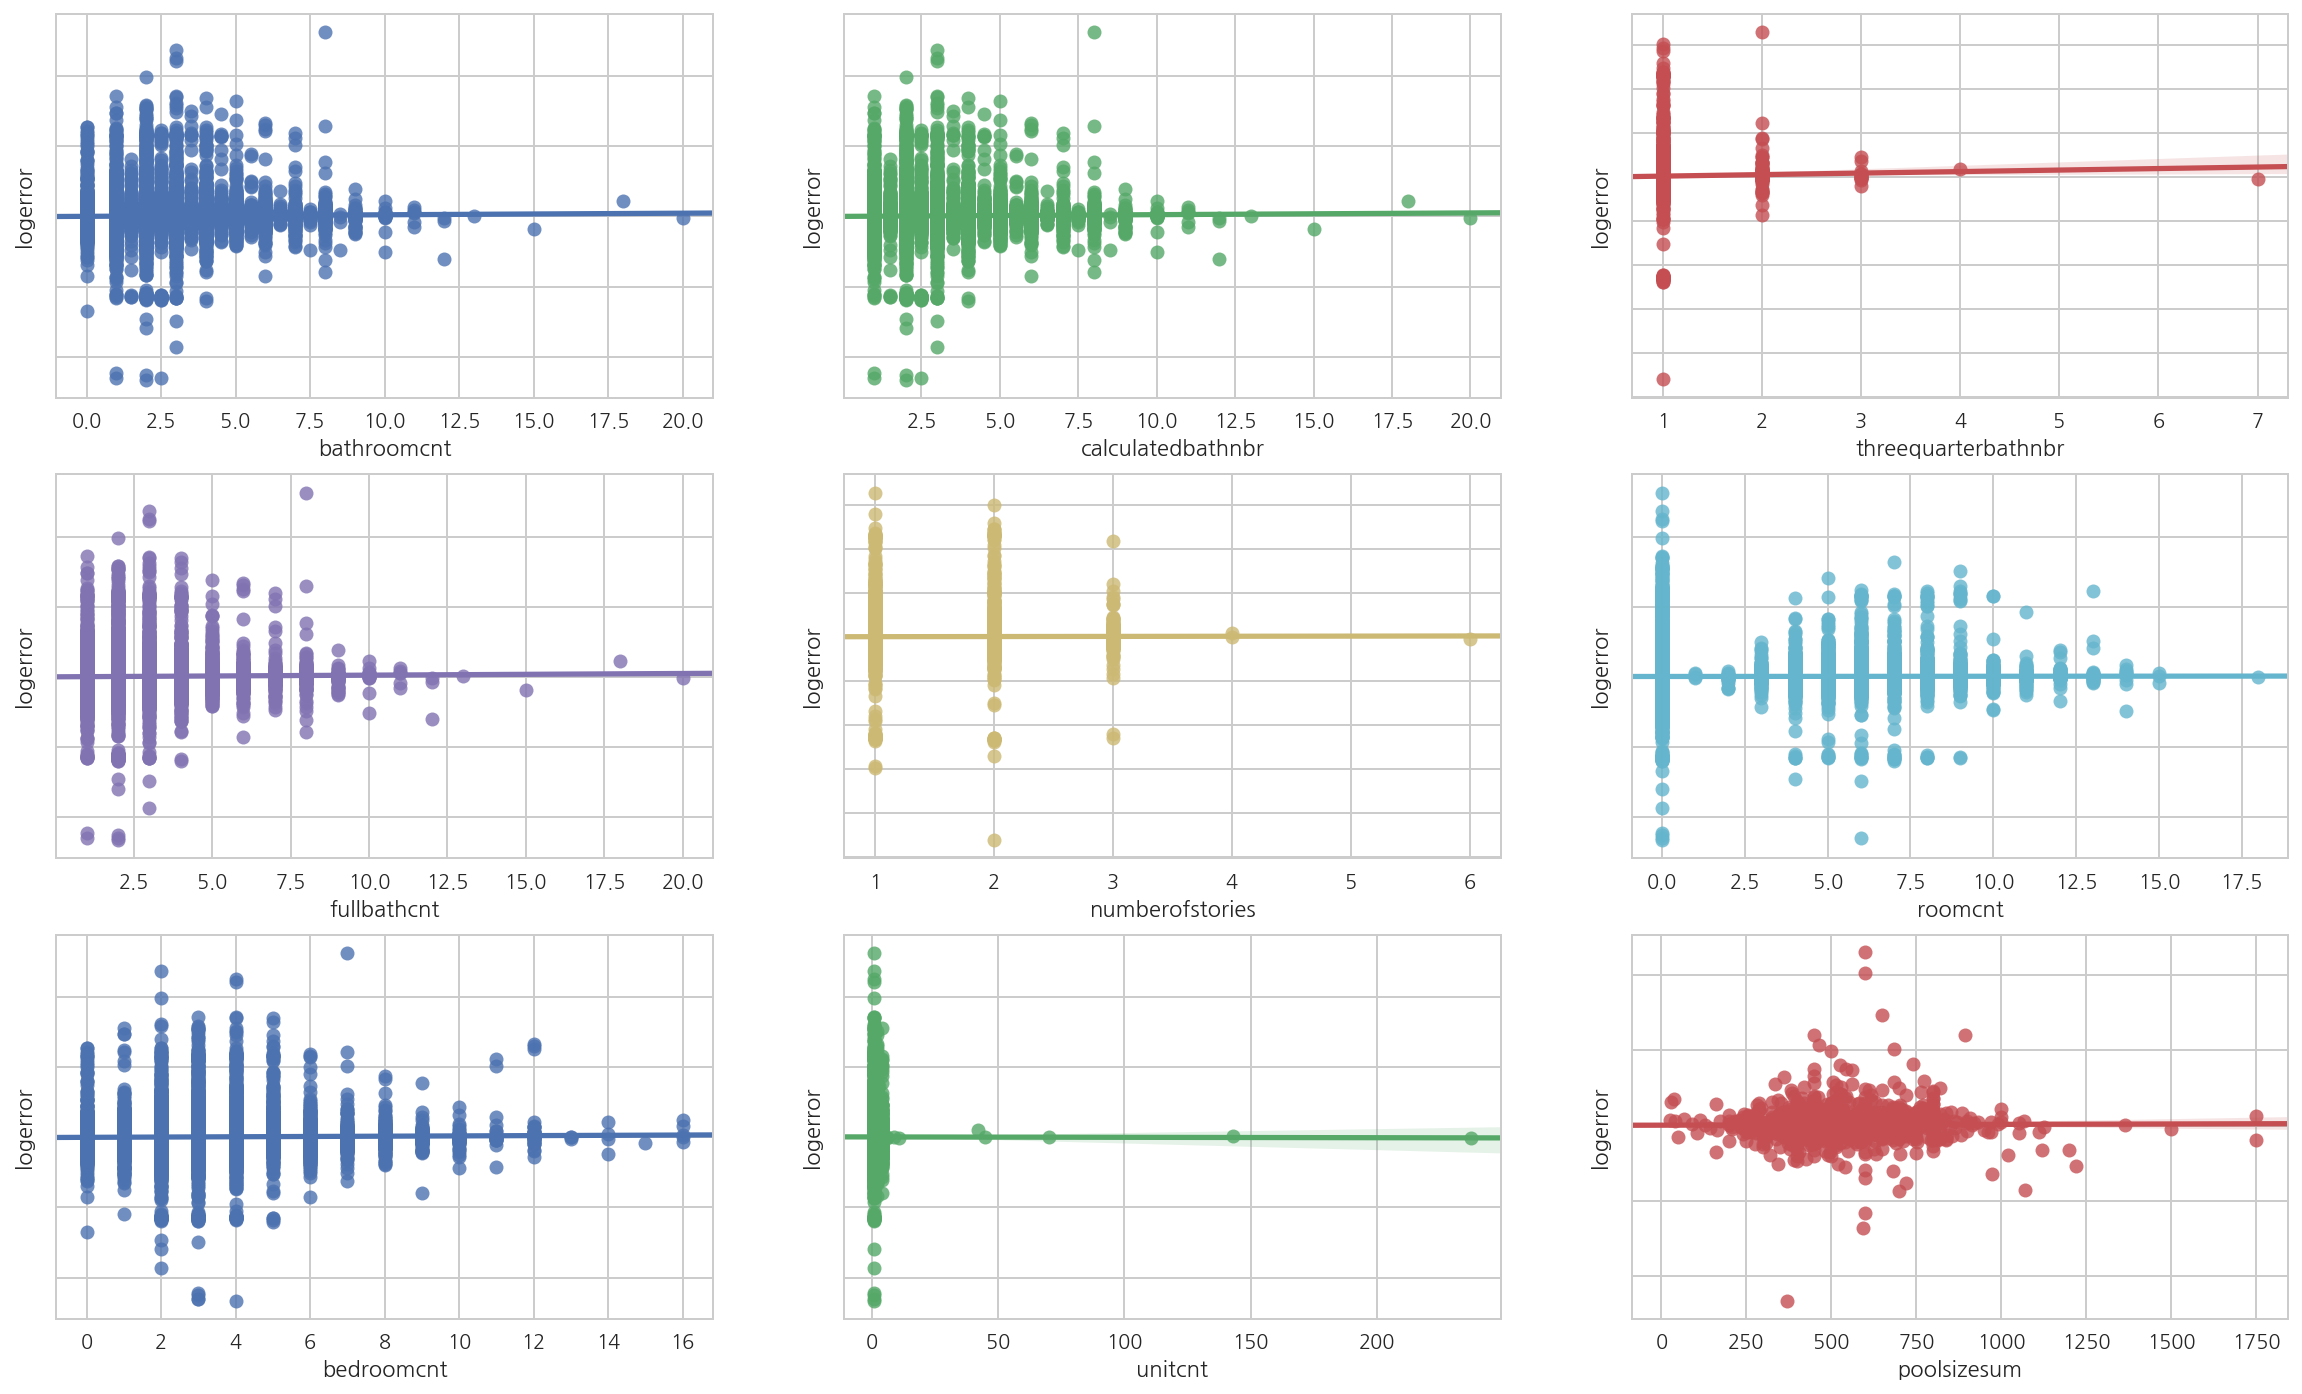

In [46]:
strt_var = ["bathroomcnt", "calculatedbathnbr", "threequarterbathnbr", "fullbathcnt",
            "numberofstories", "roomcnt", "bedroomcnt", "unitcnt", "poolsizesum"]

fig, ax = plt.subplots(3,3, figsize = (20,12))

for idx, n in enumerate(strt_var):
    sns.regplot(x=n, y='logerror', data=merged, ax = ax[idx // 3,idx % 3])
    ax[idx // 3, idx % 3].set(yticklabels=[])
    continue

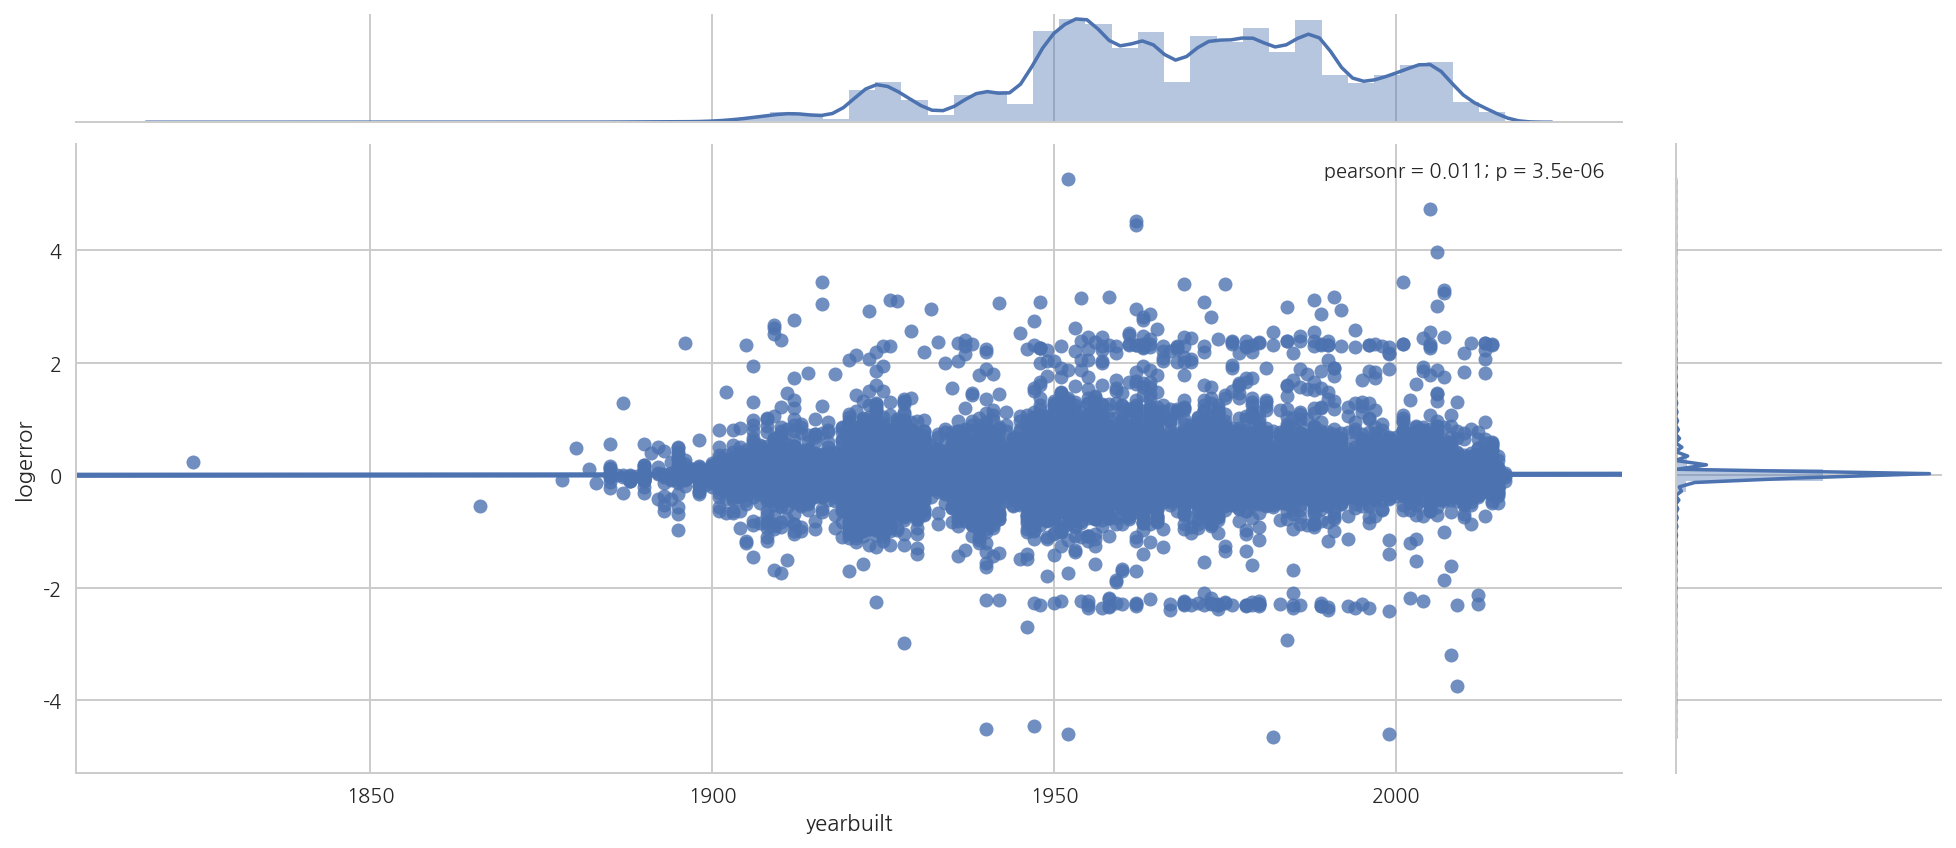

In [45]:
yearbuilt_plot = sns.jointplot(x = "yearbuilt", y = "logerror", data=merged, kind="reg")
yearbuilt_plot.fig.set_size_inches(15,6)

##### **(3) 집의 기타 특징에 관한 변수들**

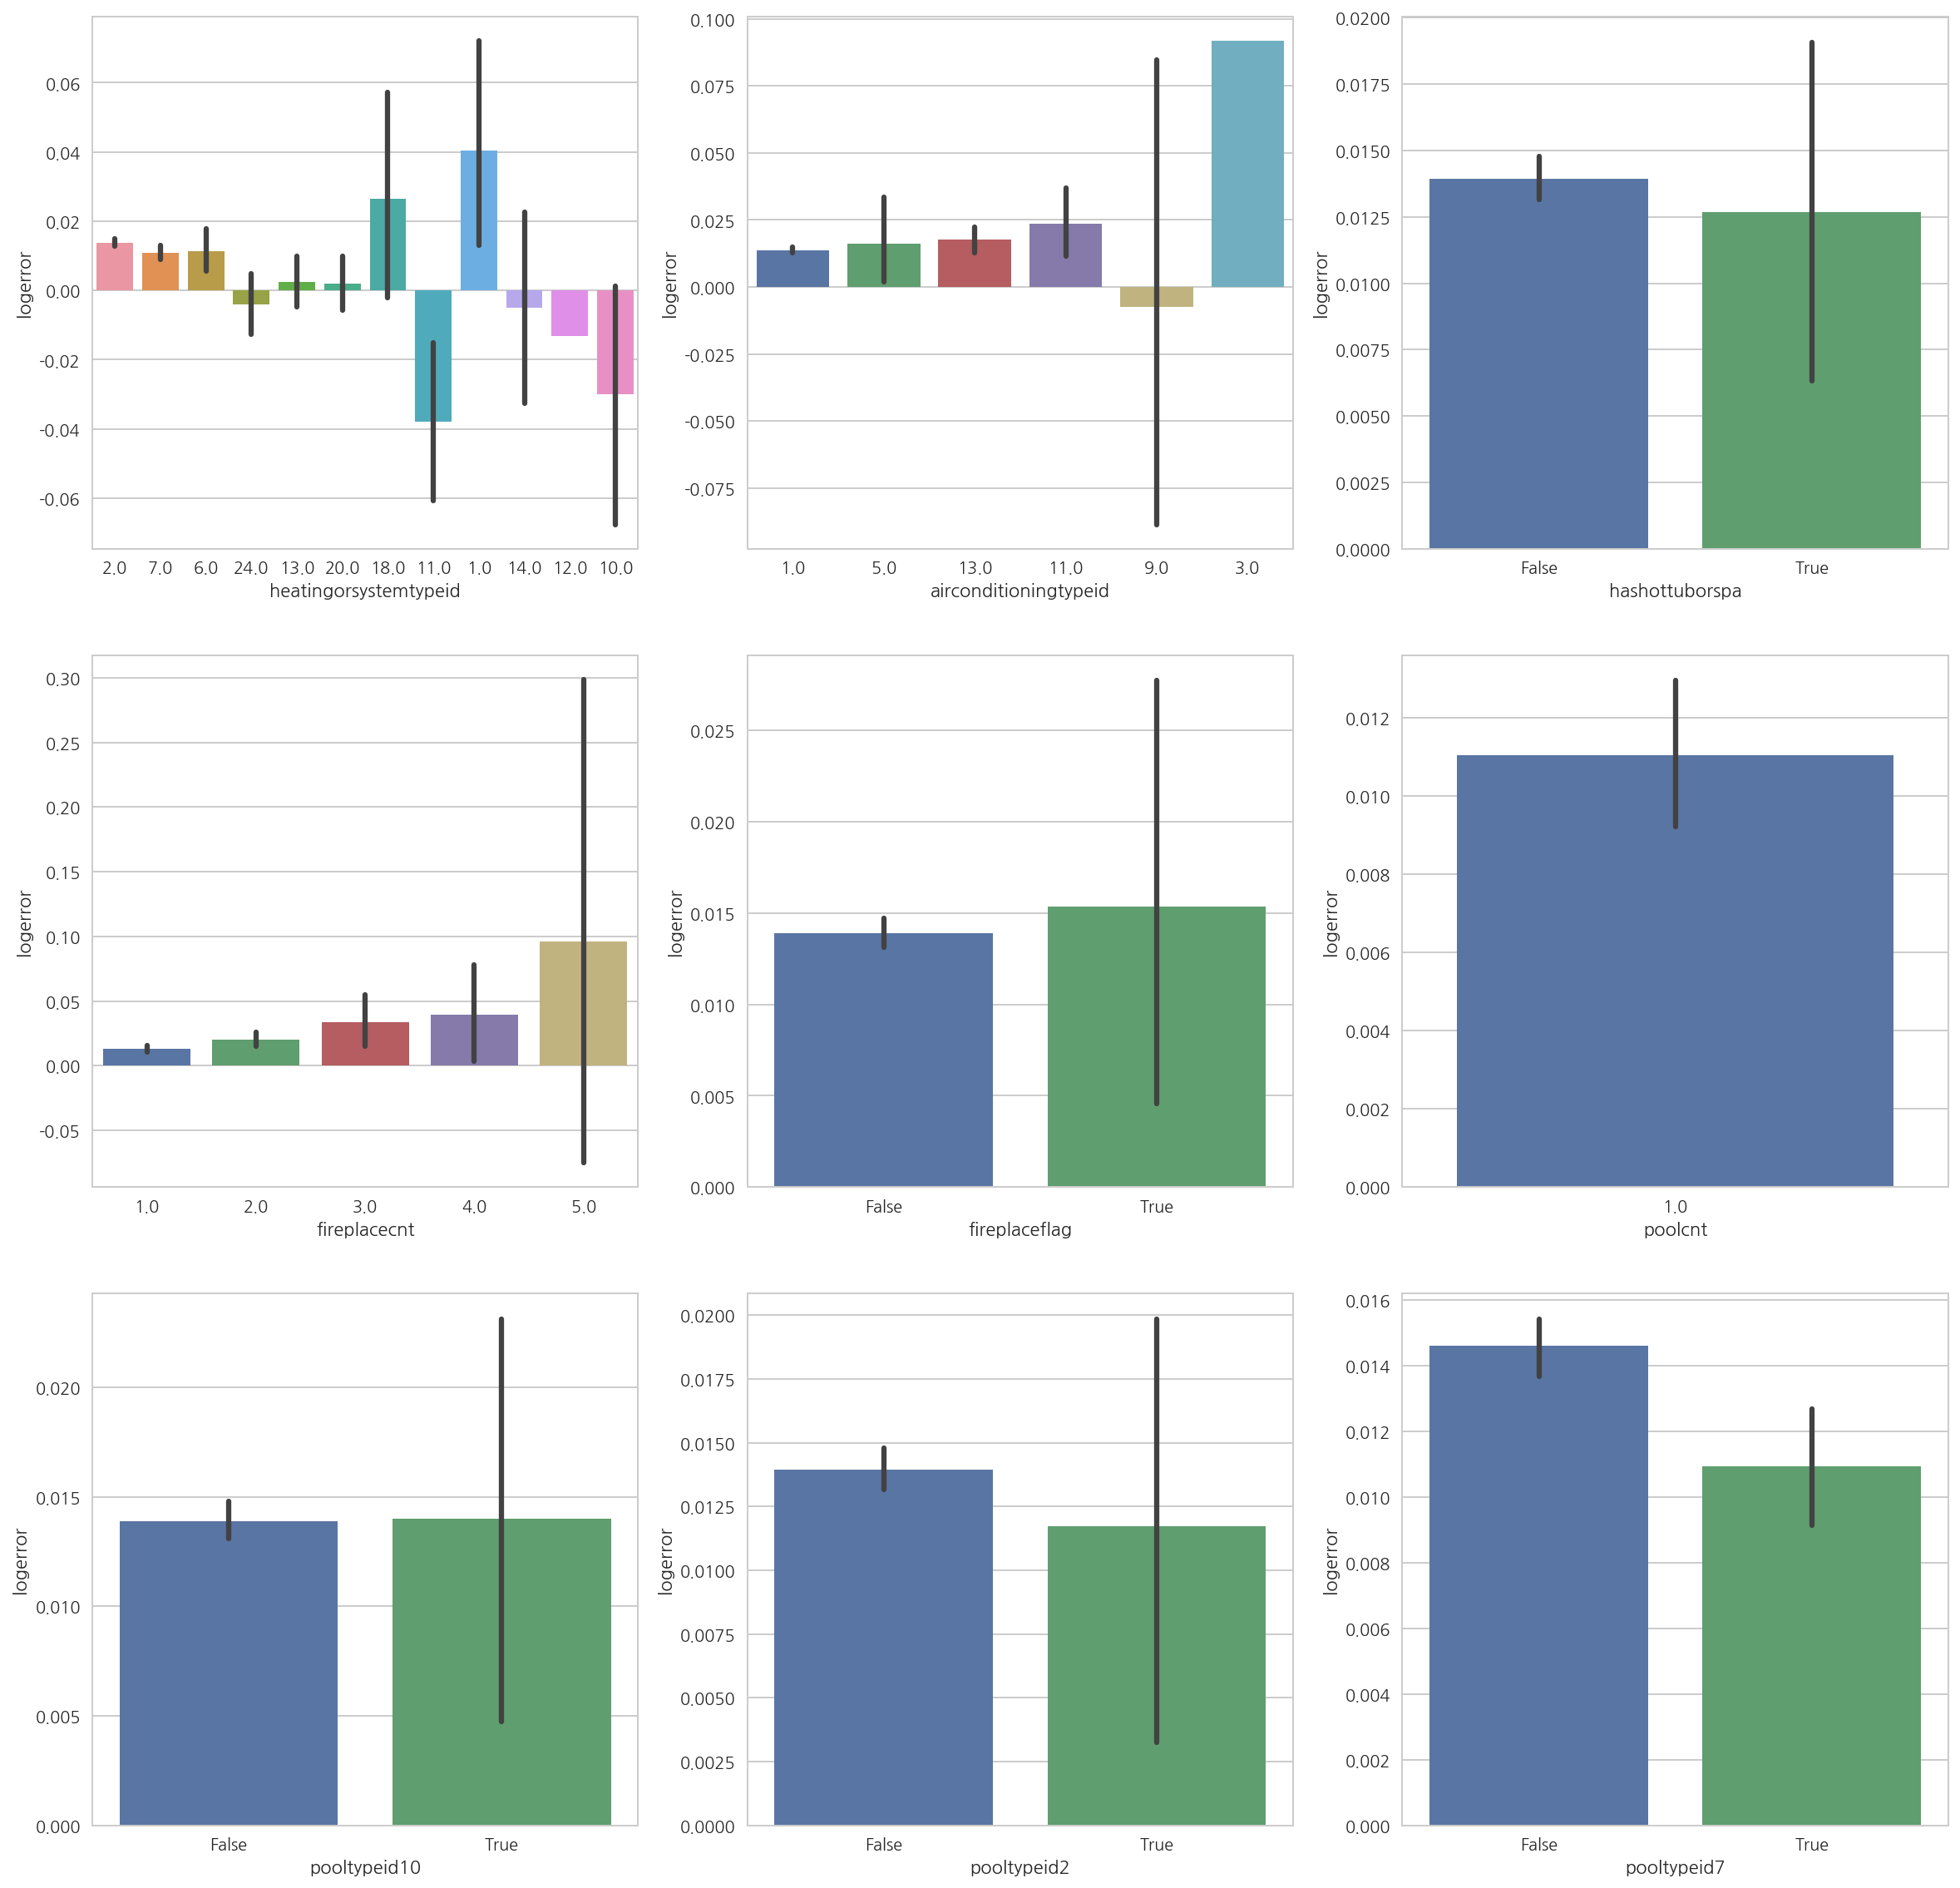

In [49]:
plt.figure(figsize=(20, 20))

ax1 = plt.subplot(3, 3, 1)
sns.barplot(x = 'heatingorsystemtypeid', y='logerror', data = merged, ax = ax1)

ax2 = plt.subplot(3, 3, 2)
sns.barplot(x = 'airconditioningtypeid', y='logerror', data = merged, ax = ax2)

ax3 = plt.subplot(3, 3, 3)
sns.barplot(x = 'hashottuborspa', y='logerror', data = merged, ax = ax3)

ax4 = plt.subplot(3, 3, 4)
sns.barplot(x = 'fireplacecnt', y='logerror', data = merged, ax = ax4)

ax5 = plt.subplot(3, 3, 5)
sns.barplot(x = 'fireplaceflag', y='logerror', data = merged, ax = ax5)

ax6 = plt.subplot(3, 3, 6)
sns.barplot(x = 'poolcnt', y='logerror', data = merged, ax = ax6)

ax7 = plt.subplot(3, 3, 7)
sns.barplot(x = 'pooltypeid10', y='logerror', data = merged, ax = ax7)

ax8 = plt.subplot(3, 3, 8)
sns.barplot(x = 'pooltypeid2', y='logerror', data = merged, ax = ax8)

ax9 = plt.subplot(3, 3, 9)
sns.barplot(x = 'pooltypeid7', y='logerror', data = merged, ax = ax9)

plt.show()

#### **4) tax와 관련된 변수**

##### tax 관련 numerical variable과 loggerror의 관계

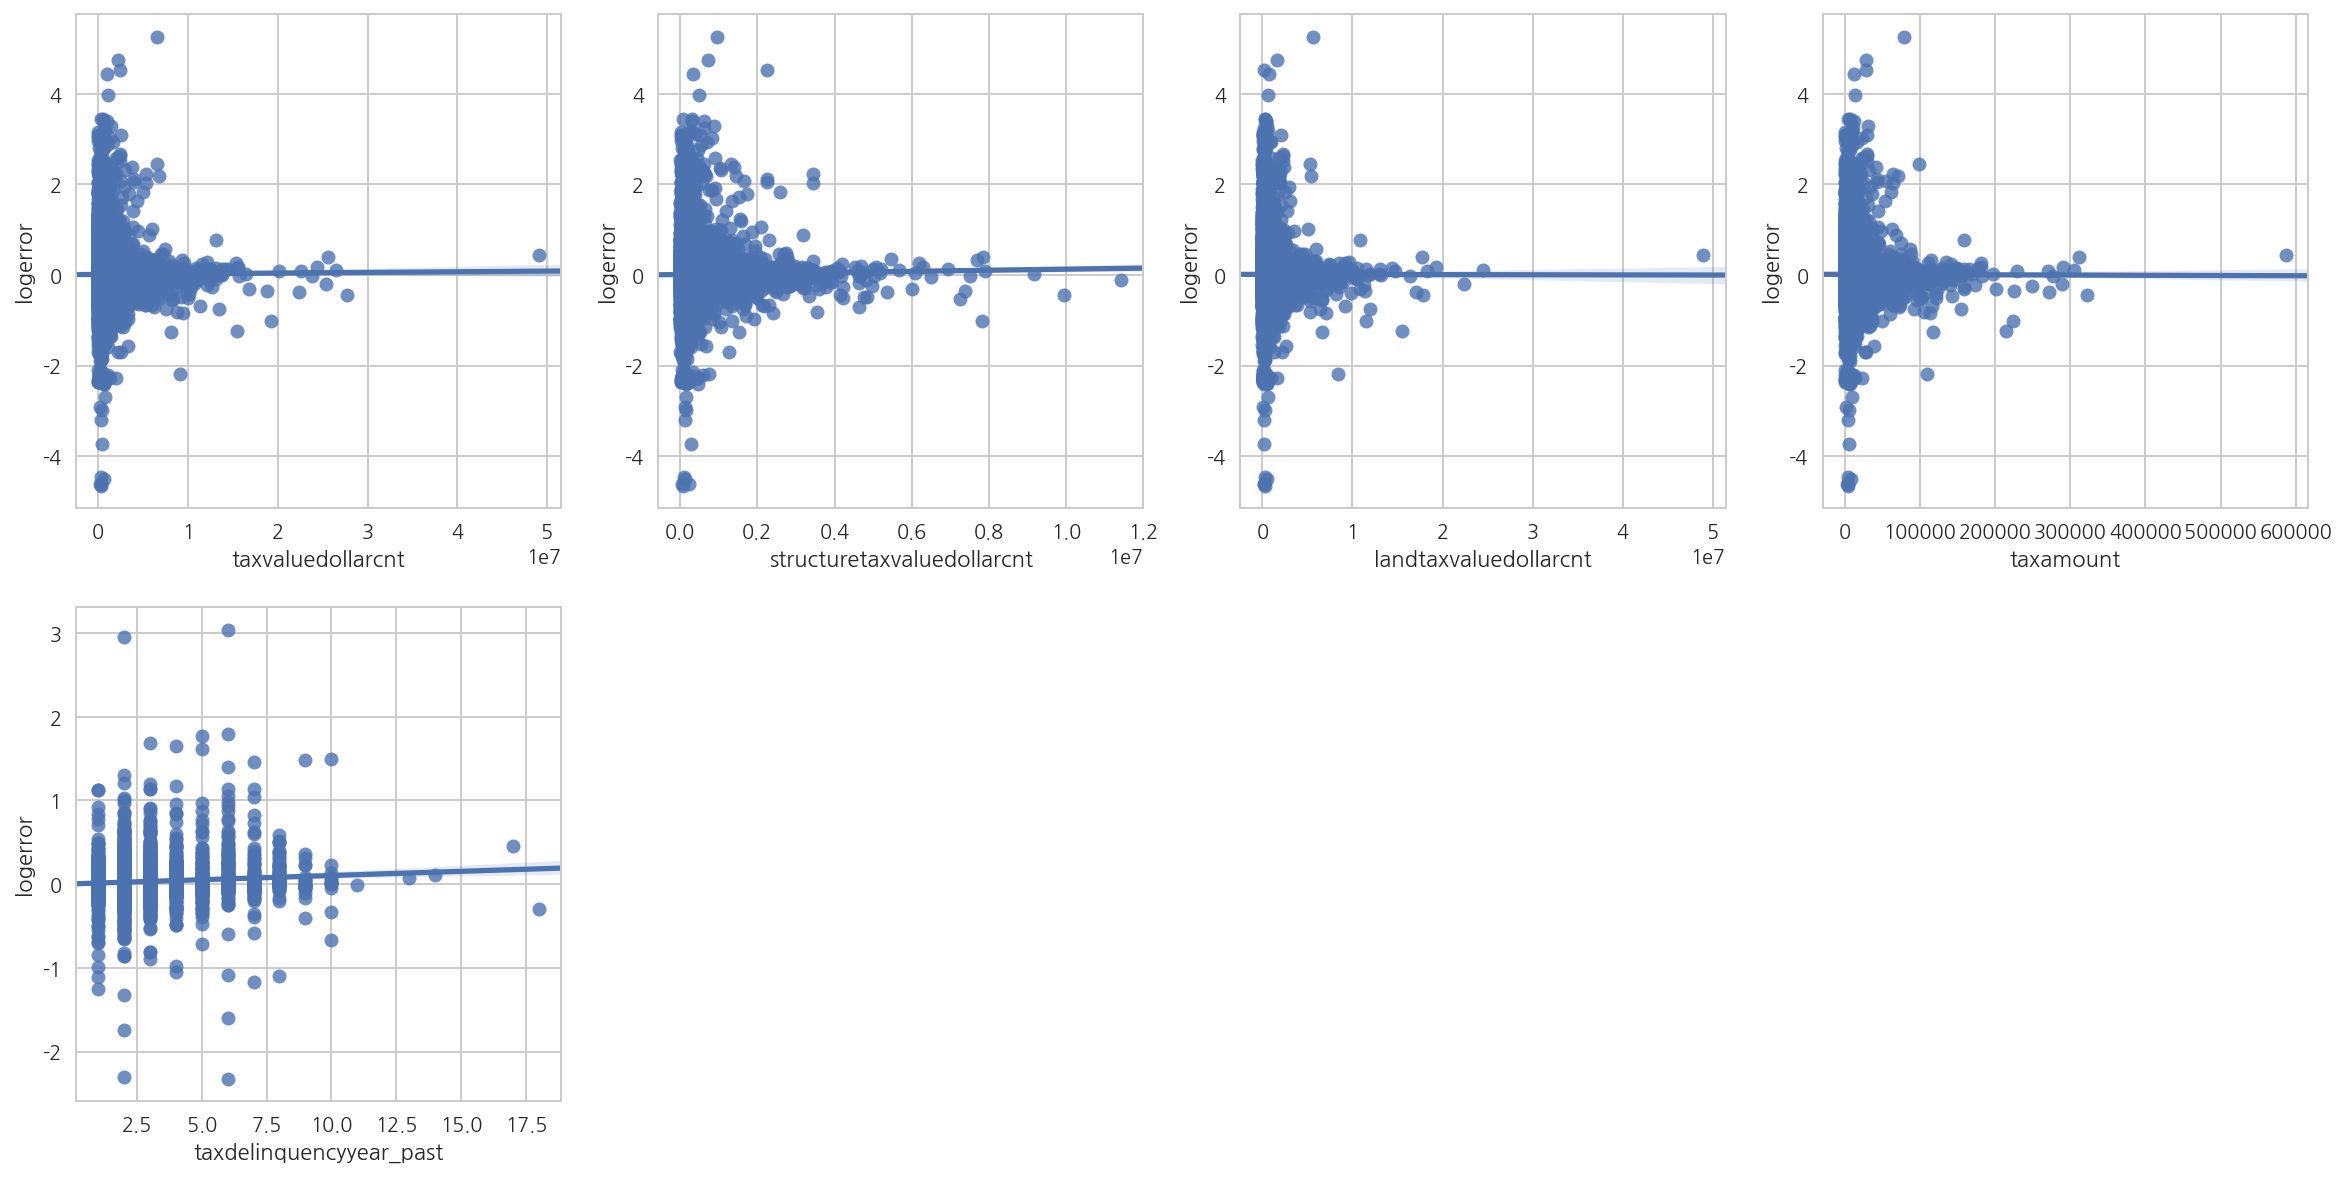

In [66]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2, 4, 1)
sns.regplot(x="taxvaluedollarcnt", y='logerror', data=merged, ax = ax1)

ax2 = plt.subplot(2, 4, 2)
sns.regplot(x="structuretaxvaluedollarcnt", y='logerror', data=merged, ax = ax2)

ax3 = plt.subplot(2, 4, 3)
sns.regplot(x="landtaxvaluedollarcnt", y='logerror', data=merged, ax = ax3)

ax4 = plt.subplot(2, 4, 4)
sns.regplot(x="taxamount", y='logerror', data=merged, ax = ax4)

ax5 = plt.subplot(2, 4, 5)
sns.regplot(x='taxdelinquencyyear_past', y='logerror', data=merged, ax = ax5)

plt.show()

##### tax 관련 categorical variable과 loggerror의 관계

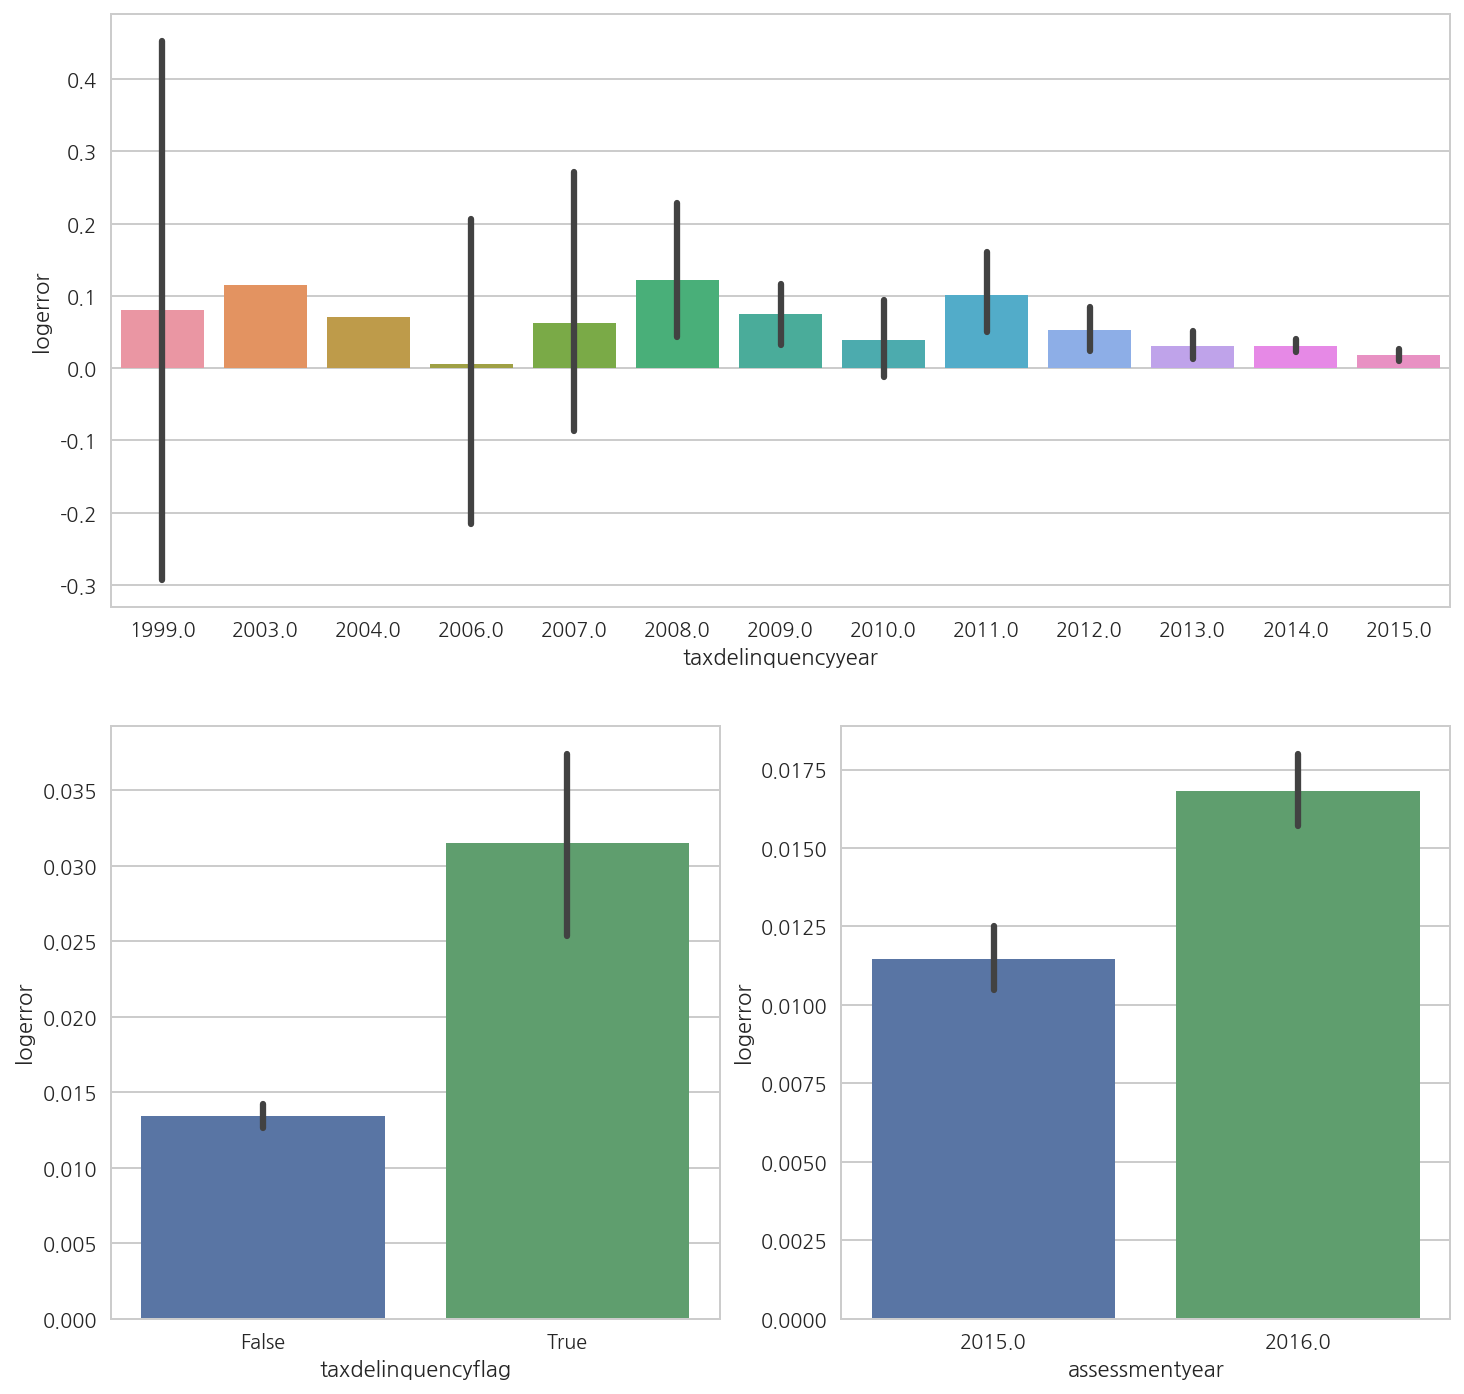

In [154]:
plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 1, 1)
sns.barplot(x = 'taxdelinquencyyear', y='logerror', data = merged.sort_values(by='taxdelinquencyyear'), ax = ax1)

ax2 = plt.subplot2grid((2,2), (1,0))
sns.barplot(x = 'taxdelinquencyflag', y='logerror', data = merged, ax = ax2)

ax3 = plt.subplot2grid((2,2), (1,1))
sns.barplot(x = 'assessmentyear', y='logerror', data = merged, ax = ax3)

plt.show()

# **3. Feature Engineering**

## 3.1 Missing Values

### 3.1.1 Status of missing values
- 데이터에 missing value가 상당히 많음, missing value의 비중을 높은 순으로 살펴보자

In [52]:
merged_missing = pd.DataFrame(merged_des["missing_ratio"].sort_values(ascending=False))
merged_missing.reset_index()

index missing_ratio
0            buildingclasstypeid      0.999815
1           finishedsquarefeet13      0.999553
2                    storytypeid      0.999446
3                   basementsqft      0.999446
4             yardbuildingsqft26      0.999017
5       architecturalstyletypeid      0.997212
6         typeconstructiontypeid      0.996891
7            finishedsquarefeet6      0.995193
8                     decktypeid      0.992424
9                    poolsizesum      0.989052
10            taxdelinquencyyear      0.972106
11            yardbuildingsqft17      0.969986
12          finishedsquarefeet15      0.960742
13          finishedsquarefeet50      0.923205
14      finishedfloor1squarefeet      0.923205
15                  fireplacecnt      0.893405
16           threequarterbathnbr      0.868275
17                       poolcnt      0.797037
18               numberofstories      0.772652
19         airconditioningtypeid       0.67962
20                  garagecarcnt      0.669679
21               garagetotalsqft      0.669679
22          regionidneighborhood      0.601008
23         heatingorsystemtypeid      0.370705
24         buildingqualitytypeid       0.36164
25            propertyzoningdesc      0.352014
26                       unitcnt      0.350424
27             lotsizesquarefeet      0.109847
28          finishedsquarefeet12     0.0498487
29                  regionidcity     0.0197096
..                           ...           ...
32                     yearbuilt    0.00631373
33  calculatedfinishedsquarefeet    0.00533689
34           censustractandblock    0.00527733
35    structuretaxvaluedollarcnt    0.00315091
36                   regionidzip   0.000708806
37                     taxamount   0.000268036
38         landtaxvaluedollarcnt   0.000220385
39             taxvaluedollarcnt   0.000214429
40     propertycountylandusecode   0.000208472
41                assessmentyear   0.000202516
42         propertylandusetypeid   0.000202516
43                          fips   0.000202516
44        rawcensustractandblock   0.000202516
45                    bedroomcnt   0.000202516
46                      latitude   0.000202516
47                     longitude   0.000202516
48                       roomcnt   0.000202516
49                   bathroomcnt   0.000202516
50                regionidcounty   0.000202516
51                      logerror             0
52               transactiondate             0
53             transaction_month             0
54                hashottuborspa             0
55              transaction_year             0
56                  pooltypeid10             0
57                   pooltypeid2             0
58                   pooltypeid7             0
59                 fireplaceflag             0
60            taxdelinquencyflag             0
61                      parcelid             0

[62 rows x 2 columns]

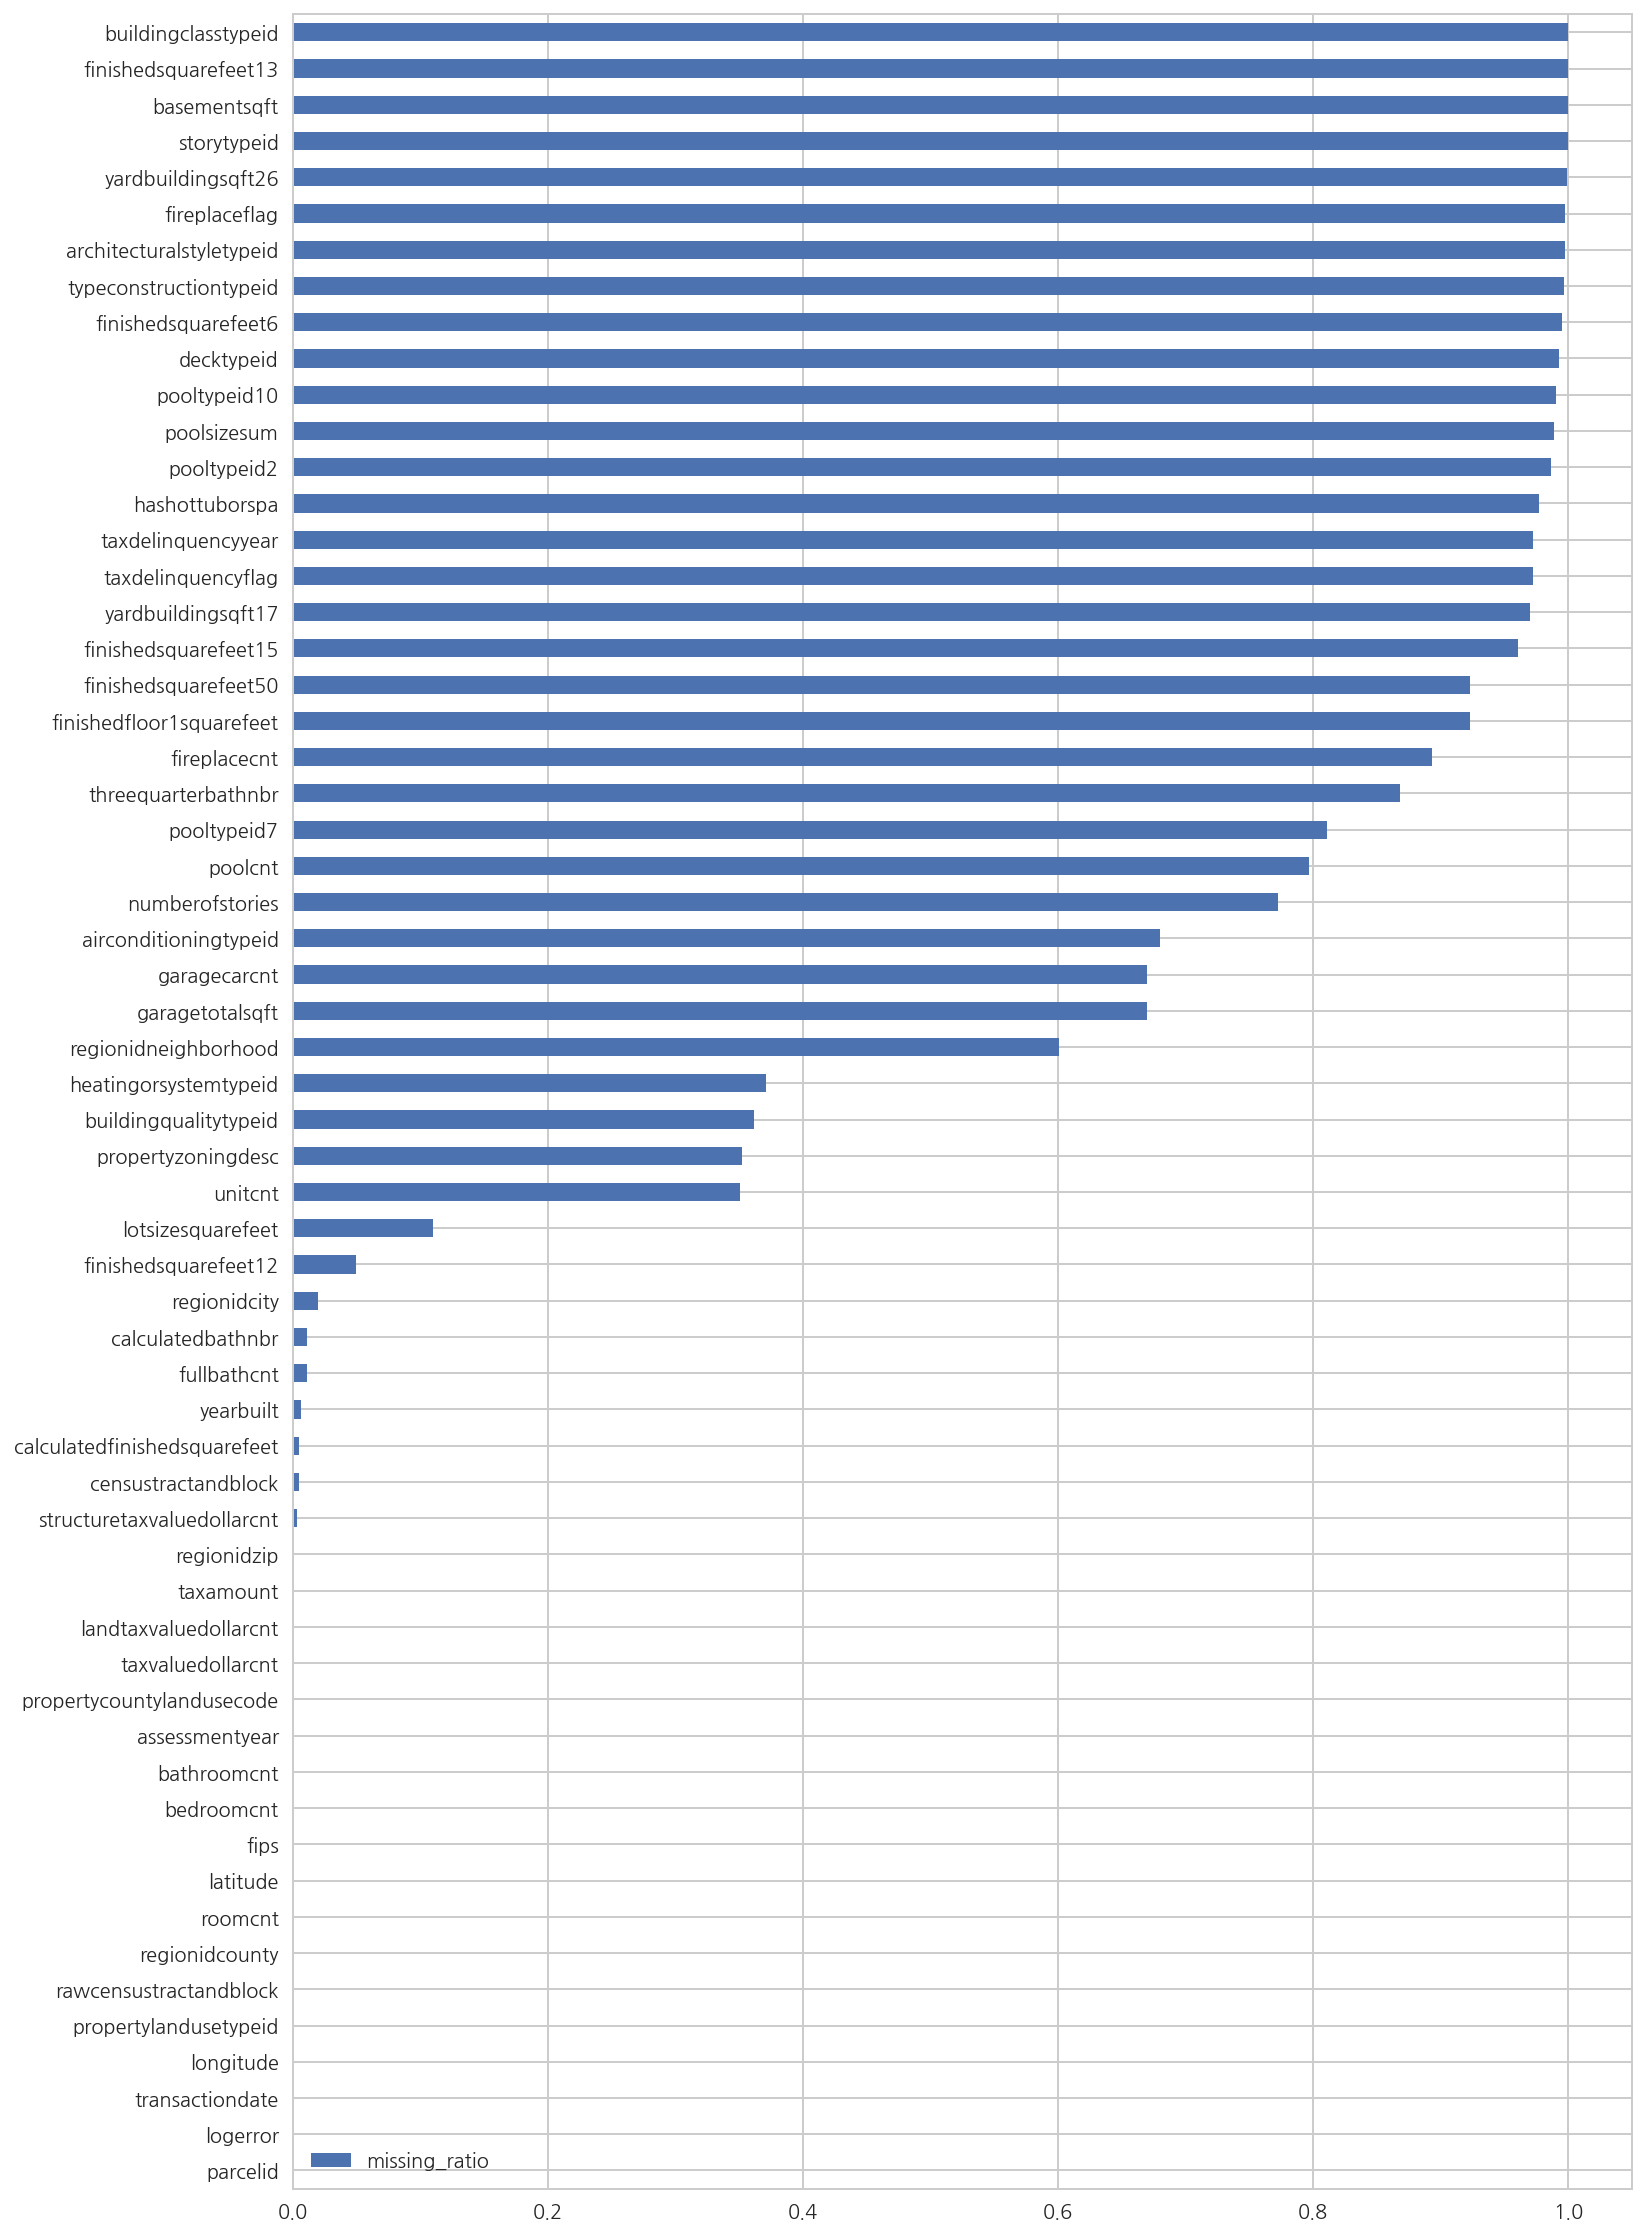

In [42]:
merged_missing.sort_values(by = "missing_ratio", ascending = True).plot(kind = 'barh', figsize=(12,20))

##### Comment:
- missing value ratio가 매우 높은 변수들이 많음
- missing value imputation 방안
    - NaN은 실제로 없어서 그런 것이라고 간주: 0사용
    - 자료가 missing 된 것이라고 볼 경우
        - 연속형 변수: 평균 사용
        - 이산형 변수, 카테고리 변수: 최빈값 사용

### 3.1.3 Missing Values processing

In [53]:
merged_1 = merged.copy()
merged_1.tail()

parcelid  logerror transactiondate airconditioningtypeid  \
167883  10833991 -0.002245      2017-09-20                   1.0   
167884  11000655  0.020615      2017-09-20                   NaN   
167885  17239384  0.013209      2017-09-21                   NaN   
167886  12773139  0.037129      2017-09-21                   1.0   
167887  12826780  0.007204      2017-09-25                   NaN   

       architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
167883                      NaN           NaN          3.0         3.0   
167884                      NaN           NaN          2.0         2.0   
167885                      NaN           NaN          2.0         4.0   
167886                      NaN           NaN          1.0         3.0   
167887                      NaN           NaN          2.0         3.0   

       buildingclasstypeid  buildingqualitytypeid           ...            \
167883                 NaN                    8.0           ...             
167884                 NaN                    6.0           ...             
167885                 NaN                    NaN           ...             
167886                 NaN                    4.0           ...             
167887                 NaN                    6.0           ...             

        raw_census_1 census_2  raw_census_2  census_3  raw_census_3  census_4  \
167883          6037   131900       1319.00         1             1     60371   
167884          6037   101400       1014.00         1             1     60371   
167885          6111   008402       0084.02         0             0     61110   
167886          6037   433802       4338.02         4             4     60374   
167887          6037   503402       5034.02         5             5     60375   

        raw_census_4  propertyzoningdesc_1  propertyzoningdesc_3  \
167883         60371                     L                     R   
167884         60371                     L                     R   
167885         61110                   NaN                   NaN   
167886         60374                     S                     R   
167887         60375                     W                     R   

       taxdelinquencyyear_past  
167883                     NaN  
167884                     NaN  
167885                     NaN  
167886                     NaN  
167887                     NaN  

[5 rows x 73 columns]

#### 일부 변수 추가 후 categorical / numerical 새로 분류
- poolcnt는 dummy variable로 재분류함 (True/False)

In [71]:
vars = merged_des.reset_index()["index"].tolist()
vars.append("taxdelinquencyyear_past")

cat_vars = ['transactiondate',"transaction_year", "transaction_month", 'fips',
            'rawcensustractandblock', 'censustractandblock', "raw_census_1", "census_1",
            "raw_census_2", "census_2", "raw_census_3", "census_3", "raw_census_4", "census_4",
            'regionidcounty', 'regionidcity', 'regionidzip', 'regionidneighborhood', 'architecturalstyletypeid',
            'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 
            'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', "propertyzoningdesc_1", "propertyzoningdesc_3",            
            'taxdelinquencyflag', 'taxdelinquencyyear', 'assessmentyear',
            'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa', 'fireplaceflag',
            'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'poolcnt']

num_vars = [i for i in vars if i not in cat_vars]

num_vars.remove('parcelid')
num_vars.remove('logerror')

print("number of categorical variables:", len(cat_vars))
print("number of numerical variables:", len(num_vars))

number of categorical variables: 39
number of numerical variables: 32


In [58]:
print(num_vars)

['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolsizesum', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear_past']


#### (1) numerical variables:

In [59]:
def num_imputation(df):
    for var in num_vars:
        if var in ["garagecarcnt", "numberofstories"]:
            df[var] = df[var].fillna(1)
        elif var in ["buildingqualitytypeid", "roomcnt", "bedroomcnt", "unitcnt", 'bathroomcnt', 
                     'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr', 'yearbuilt']:
            a = df[var].mode()
            df[var] = df[var].fillna(int(a[0]))
        elif var in ['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
                     'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
                     'finishedsquarefeet50', 'finishedsquarefeet6', 'garagetotalsqft', 'lotsizesquarefeet',
                     'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'taxamount',
                     'latitude', 'longitude']:
            df[var] = df[var].fillna(df[var].mean())
        else:    # ['poolsizesum', 'fireplacecnt', 'yardbuildingsqft17', 'yardbuildingsqft26', "poolsizesum","taxdelinquencyyear_past"]
            df[var] = df[var].fillna(0) 

In [60]:
num_imputation(merged_1)

#### (2) dummy/categorical variables:

In [61]:
def cat_imputation(df):
    for var in cat_vars:                  
        if var in ['taxdelinquencyyear', 'assessmentyear']:
            df[var] = df[var].fillna(0)
        elif var == "poolcnt":
            df[var] = df[var].replace(1, True)
            df[var] = df[var].fillna(False)            
        elif var == "decktypeid":
            df[var] = df[var].replace('66.0', True)
            df[var] = df[var].fillna(False)         
        else:
            a = df[var].mode()
            df[var] = df[var].fillna(a[0])

In [62]:
cat_imputation(merged_1)

#### (3) imputation 후 missing value ratio 다시 체크

In [63]:
merged_1_des = merged_1.describe(include='all').transpose()
merged_1_des["missing_ratio"] = 1-(merged_1_des["count"]/merged_1.shape[0])
merged_1_des["dtype"] = merged_1.dtypes
merged_1_missing = pd.DataFrame(merged_1_des["missing_ratio"].sort_values(ascending=False))
merged_1_missing.reset_index()

index missing_ratio
0      taxdelinquencyyear_past             0
1        propertylandusetypeid             0
2                         fips             0
3                 fireplacecnt             0
4                  fullbathcnt             0
5                 garagecarcnt             0
6              garagetotalsqft             0
7               hashottuborspa             0
8        heatingorsystemtypeid             0
9                     latitude             0
10                   longitude             0
11           lotsizesquarefeet             0
12                     poolcnt             0
13                 poolsizesum             0
14                pooltypeid10             0
15                 pooltypeid2             0
16                 pooltypeid7             0
17         finishedsquarefeet6             0
18        finishedsquarefeet50             0
19        finishedsquarefeet15             0
20                  bedroomcnt             0
21                    logerror             0
22             transactiondate             0
23       airconditioningtypeid             0
24    architecturalstyletypeid             0
25                basementsqft             0
26                 bathroomcnt             0
27         buildingclasstypeid             0
28        finishedsquarefeet13             0
29       buildingqualitytypeid             0
..                         ...           ...
43            transaction_year             0
44           transaction_month             0
45                    census_1             0
46                raw_census_1             0
47                    census_2             0
48                raw_census_2             0
49                    census_3             0
50                raw_census_3             0
51                    census_4             0
52                raw_census_4             0
53        propertyzoningdesc_1             0
54       landtaxvaluedollarcnt             0
55              assessmentyear             0
56           taxvaluedollarcnt             0
57         threequarterbathnbr             0
58                regionidcity             0
59              regionidcounty             0
60        regionidneighborhood             0
61                 regionidzip             0
62                     roomcnt             0
63                 storytypeid             0
64      typeconstructiontypeid             0
65  structuretaxvaluedollarcnt             0
66                     unitcnt             0
67          yardbuildingsqft17             0
68          yardbuildingsqft26             0
69                   yearbuilt             0
70             numberofstories             0
71               fireplaceflag             0
72                    parcelid             0

[73 rows x 2 columns]

## 3.2 Feature Correlation

#### 3.2.1 Numerical Features

- logerror와 높은 선형관계를 가진 numerical feature가 없음
- 서로 높은 관계를 선형관계를 가진 그룹이 보임
    - bedroomcnt & bathroom 관련 변수들, 면적관련 변수들, 세금관련 변수들

In [72]:
num_df = merged_1[num_vars]
num_df["logerror"] = merged_1["logerror"]

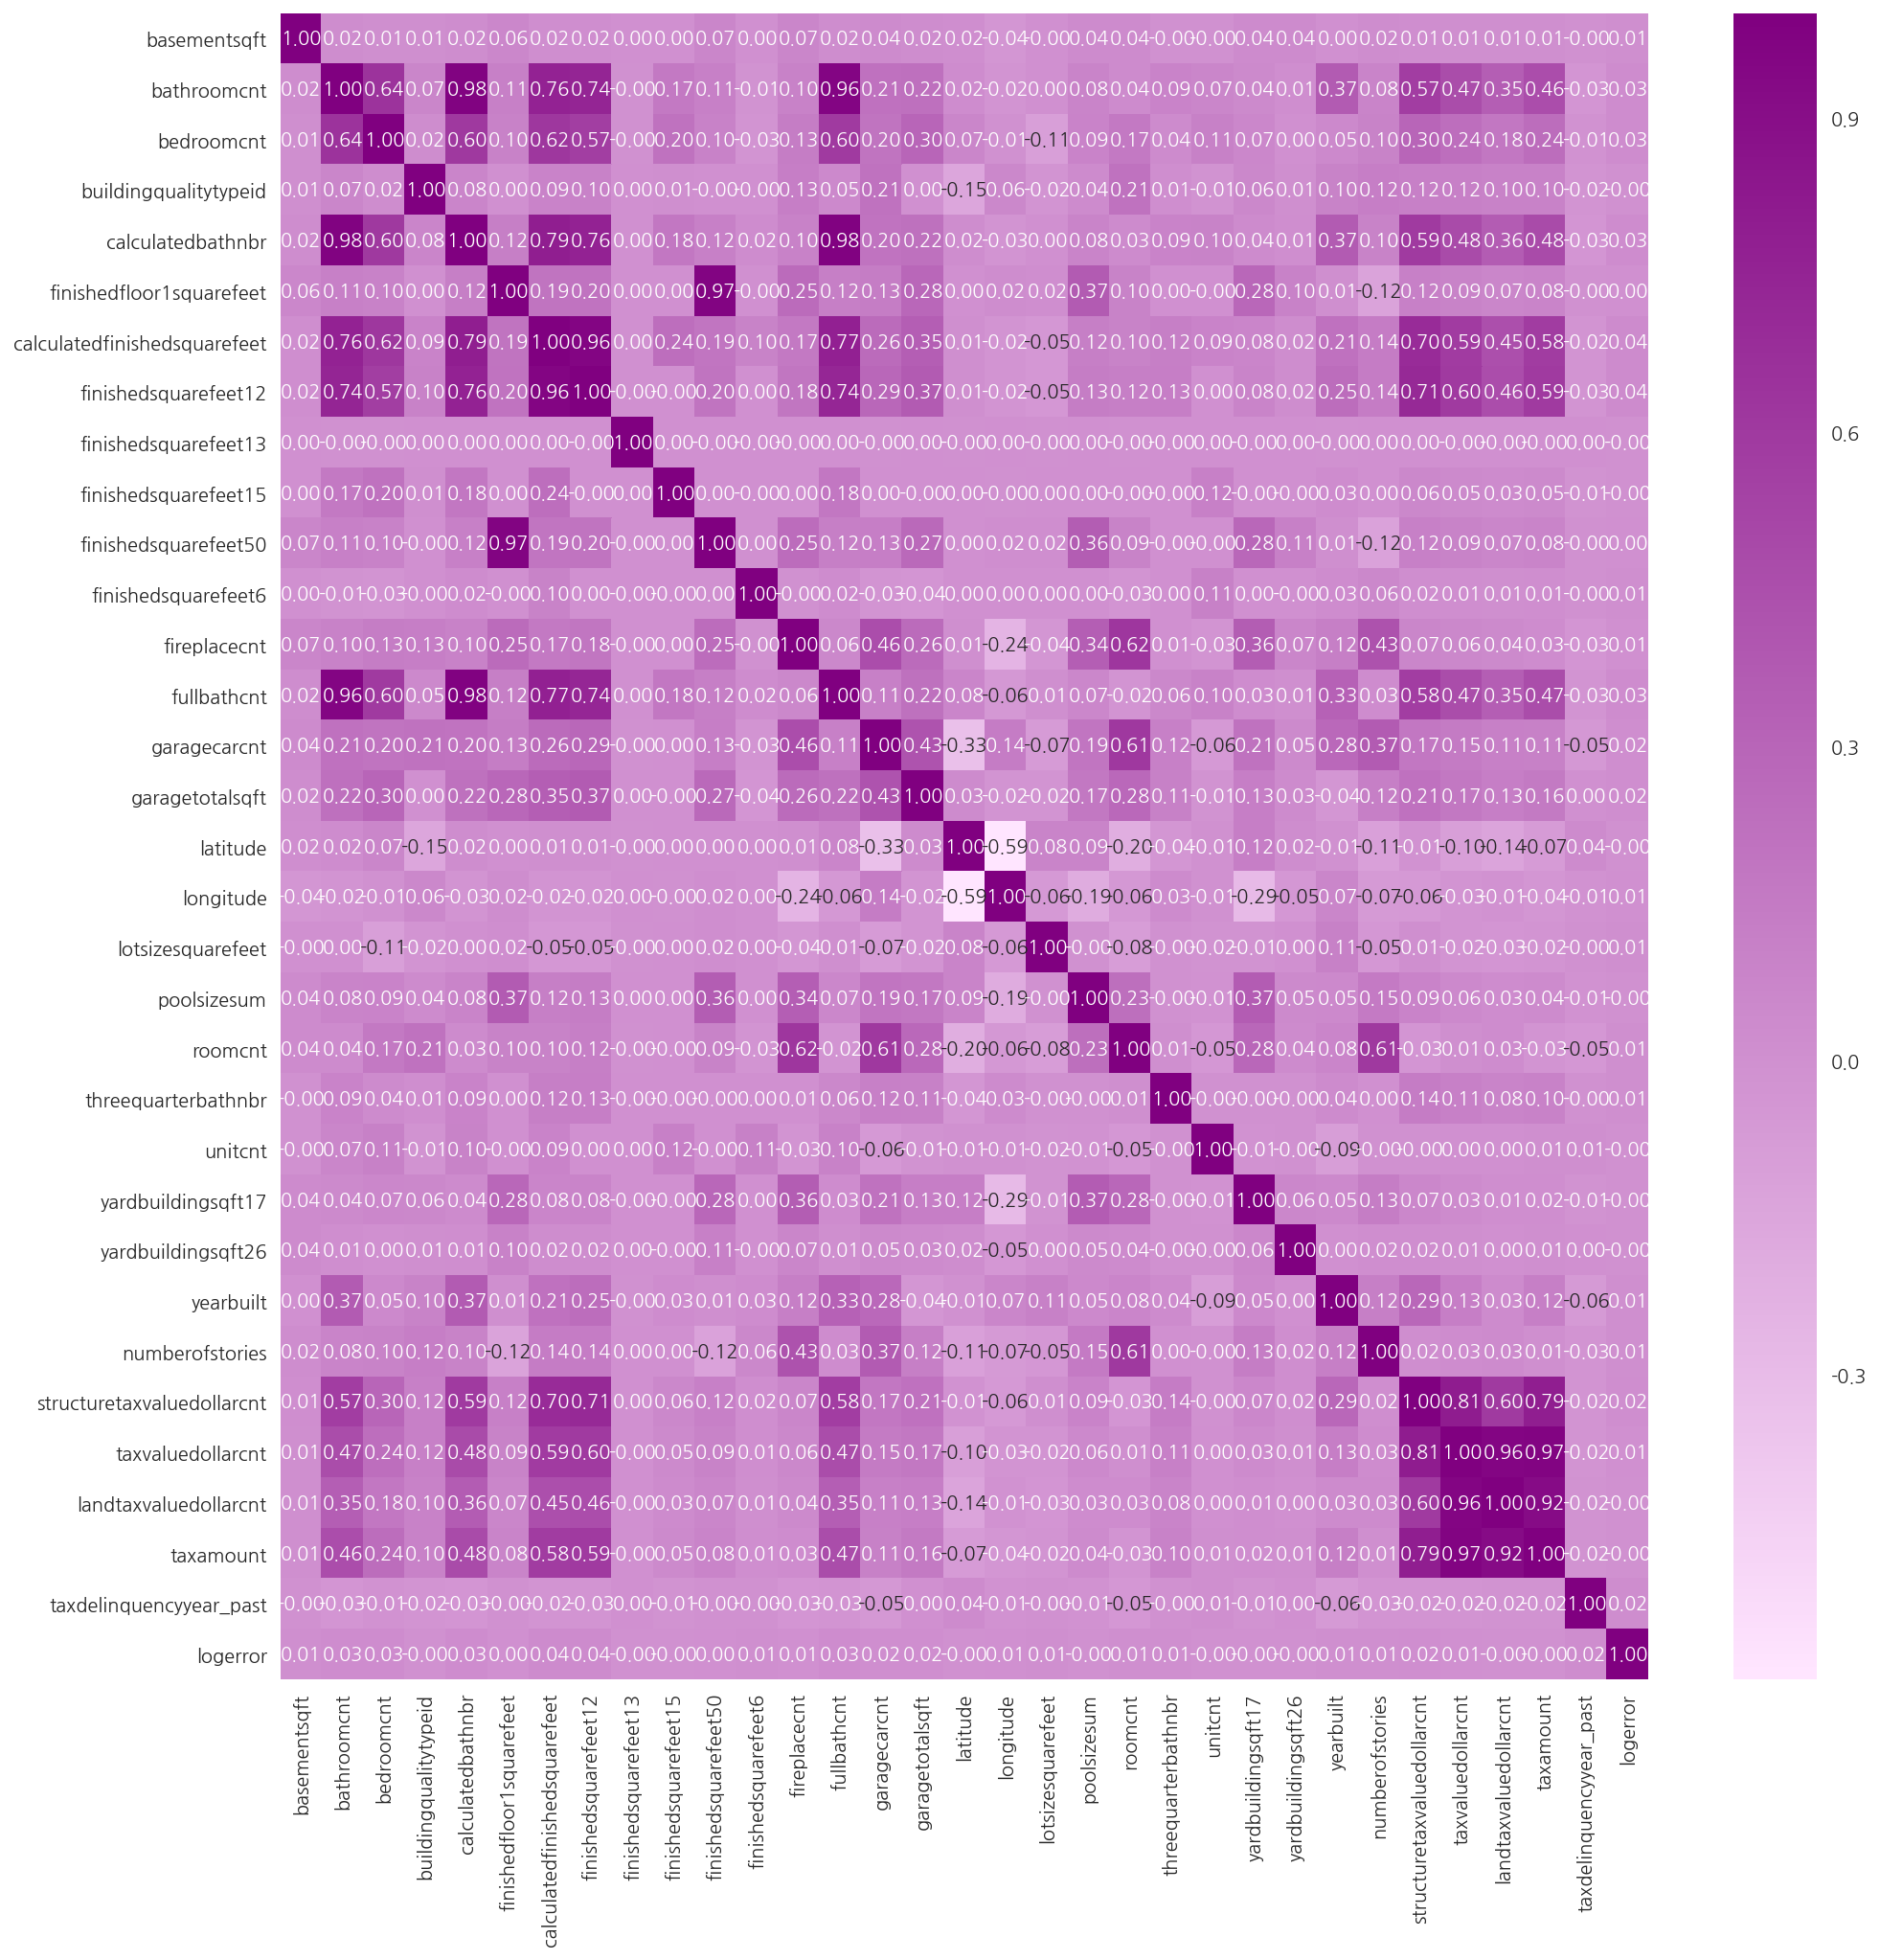

In [73]:
plt.figure(figsize=(16, 16))
cmap = sns.light_palette("purple", as_cmap=True)
sns.heatmap(num_df.corr(), annot=True, fmt='3.2f', cmap=cmap)
plt.show()

#### 3.2.2 Categorical Features

In [74]:
cat_df = merged_1[cat_vars]

### 3.3 Determination of outliers and variables using OLS model

#### 3.3.1 Model by all numerical Features

#### 3.3.2 Model by all categorical Features

#### 3.3.3 Model by numerical and categorical features together

#### 3.3.4 Model by high correlation coefficient numerical features with Logerror

#### 3.3.5 Model by high correlation coefficient numerical features and categorical features 

#### 3.3.6 Multi-collinearity and variance analysis between variables

##### (1) Multi-collinearity

##### (2) Analysis of variance on categorical features

#### 3.3.7 Comparison of model performance by using variables

### 3.4 Outlier

#### 1) Option1 : IQR (Interquartile Range)

#### 2) Option2 : Standardized resids

#### 3) Option3 : Cook's Distance

#### 4) Check all outliers (option 1,2,3)

#### 5) Combination of outliers groups

### 3.5 Data preprocessing

#### 3.5.1 Select numerical variables

#### 3.5.2 Select categorical variables

## **4. Modeling**

### 4.1. Input data

### 4.2 OLS(Ordinary Least Square) Model

#### 4.2.1 Make OLS Model

#### 4.2.2 ANOVA F-test

#### 4.2.3 RMSE

#### 4.2.4 Normalization of residuals

### 4.3 Predict Logerror